<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Another_copy_of_Untitled252.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyscf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.m3d import Axes3D  # noqa: F401

import gemmi
from pyscf import gto, dft
from pyscf.dft import numint

# =========================================
# 1. Load 6LK1 and collect Fe/S atoms
# =========================================

cif_path = "6LK1.cif"  # ensure this exists

doc = gemmi.cif.read_file(cif_path)
block = doc.sole_block()
structure = gemmi.make_structure_from_block(block)
model = structure[0]

fes_atoms_all = []
for chain in model:
    for res in chain:
        for atom in res:
            el = atom.element.name
            if el.upper().startswith("FE") or el.upper() == "S":
                fes_atoms_all.append({
                    "element": "Fe" if el.upper().startswith("FE") else "S",
                    "x": atom.pos.x,
                    "y": atom.pos.y,
                    "z": atom.pos.z,
                })

fes_coords = np.array([[a["x"], a["y"], a["z"]] for a in fes_atoms_all])
fes_elems  = np.array([a["element"] for a in fes_atoms_all])

print(f"Found {len(fes_atoms_all)} Fe/S atoms in 6LK1")

# =========================================
# 2. Cluster Fe/S atoms (distance-based)
# =========================================

def cluster_fes(coords, cutoff=3.0):
    N = coords.shape[0]
    adj = [[] for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(coords[i] - coords[j])
            if d < cutoff:
                adj[i].append(j)
                adj[j].append(i)
    visited = [False]*N
    clusters = []
    for i in range(N):
        if not visited[i]:
            stack = [i]
            comp = []
            visited[i] = True
            while stack:
                k = stack.pop()
                comp.append(k)
                for nb in adj[k]:
                    if not visited(nb):
                        visited[nb] = True
                        stack.append(nb)
            clusters.append(comp)
    return clusters

clusters = cluster_fes(fes_coords, cutoff=3.0)
print(f"Found {len(clusters)} Fe/S-connected clusters")
for idx, comp in enumerate(clusters):
    n_fe = np.sum(fes_elems[comp] == "Fe")
    n_s  = np.sum(fes_elems[comp] == "S")
    print(f"  Cluster {idx}: {len(comp)} atoms ({n_fe} Fe, {n_s} S)")

# =========================================
# 3. Pick cluster 1 (2Fe + 6S) and centre it
# =========================================

cluster_idx = 1   # change to 5 if you want the other 2Fe–6S
atom_indices = clusters[cluster_idx]
cluster_coords = fes_coords[atom_indices]
center = cluster_coords.mean(axis=0)

symbols = []
coords_centered = []
print(f"\nUsing cluster {cluster_idx} with atoms:")
for i in atom_indices:
    sym = fes_elems[i]
    x, y, z = fes_coords[i] - center
    symbols.append(sym)
    coords_centered.append([x, y, z])
    print(f"  {i}: {sym}, ({fes_coords[i,0]:.3f}, {fes_coords[i,1]:.3f}, {fes_coords[i,2]:.3f})")

symbols = np.array(symbols)
coords_centered = np.array(coords_centered)

# =========================================
# 4. One-shot PBE SCF and curvature PDF
# =========================================

def curvature_pdf_and_mf(symbols, coords,
                         box=3.0, ngrid=32, rho_thresh=1e-3):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid_coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    atom_lines = [f"{s} {x:.6f} {y:.6f} {z:.6f}"
                  for (s, (x, y, z)) in zip(symbols, coords)]
    atom_str = "\n".join(atom_lines)

    mol = gto.Mole()
    mol.atom = atom_str
    mol.basis = "sto-3g"
    mol.charge = 0
    mol.spin = 0
    mol.build()

    mf = dft.RKS(mol)
    mf.xc = "PBE"
    mf.max_cycle = 150
    mf.conv_tol = 1e-5
    mf.kernel()

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid_coords)
    dm = mf.make_rdm1()
    rho_flat = ni.eval_rho(mol, ao, dm)
    rho = rho_flat.reshape((ngrid, ngrid, ngrid))

    dx = xs[1] - xs[0]
    lap = (
        np.gradient(np.gradient(rho, dx, axis=0), dx, axis=0) +
        np.gradient(np.gradient(rho, dx, axis=1), dx, axis=1) +
        np.gradient(np.gradient(rho, dx, axis=2), dx, axis=2)
    )

    mask = rho > rho_thresh
    kappa = np.abs(lap[mask].ravel())
    if kappa.size == 0:
        print("Warning: no points above rho_thresh")
        return np.array([]), mf, mol
    kappa = np.clip(kappa, 0, np.percentile(kappa, 99.5))
    return kappa, mf, mol

kappa_base, mf_base, mol_base = curvature_pdf_and_mf(symbols, coords_centered)

# create a "vibrationally enhanced" curvature by scaling
delta = 0.15  # 15% effective curvature increase
kappa_vib = (1.0 + delta) * kappa_base

# =========================================
# 5. HOMO cloud for base, and scaled coordinates for "vib" visual
# =========================================

def homo_cloud(mol, mf,
               box=3.0,
               ngrid=32,
               keep_percent=97.0,
               max_points=4000):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, coords)

    mo_coeff = mf.mo_coeff
    mo_occ   = mf.mo_occ
    occ_idx  = np.where(mo_occ > 1e-6)[0]
    homo_idx = occ_idx[-1]

    mo_vals = ao @ mo_coeff[:, homo_idx]
    mo_vals = np.real(mo_vals)
    prob = mo_vals**2

    thr = np.percentile(prob, keep_percent)
    mask = prob > thr
    coords_cloud = coords[mask]
    psi_cloud    = mo_vals[mask]

    if coords_cloud.shape[0] > max_points:
        idx = np.random.choice(coords_cloud.shape[0], max_points, replace=False)
        coords_cloud = coords_cloud[idx]
        psi_cloud    = psi_cloud[idx]

    return coords_cloud, psi_cloud

coords_cloud_base, psi_cloud_base = homo_cloud(mol_base, mf_base)
# mimic breathing by scaling coordinates of the cloud (keep ψ values)
coords_cloud_vib = coords_cloud_base * (1.0 + delta)
psi_cloud_vib    = psi_cloud_base   # same amplitudes, just moved in space

# =========================================
# 6. Plot: geometry, PDFs, clouds
# =========================================

fig = plt.figure(figsize=(15, 4))

# (a) Fe–S geometry
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
color_atoms = {"Fe": "red", "S": "yellow"}
for (x, y, z), sym in zip(coords_centered, symbols):
    ax1.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax1.text(x, y, z + 0.3, sym, ha='center', fontsize=9)
for i in range(len(coords_centered)):
    for j in range(i+1, len(coords_centered)):
        d = np.linalg.norm(coords_centered[i] - coords_centered[j])
        if d < 3.0:
            ax1.plot([coords_centered[i,0], coords_centered[j,0]],
                     [coords_centered[i,1], coords_centered[j,1]],
                     [coords_centered[i,2], coords_centered[j,2]],
                     color="k", linewidth=0.7)
ax1.set_title(f"Fe–S cluster (6LK1, cluster {cluster_idx})")
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])
max_range = (coords_centered.max(axis=0) - coords_centered.min(axis=0)).max()
mid = coords_centered.mean(axis=0)
for setter, m in zip([ax1.set_xlim, ax1.set_ylim, ax1.set_zlim], mid):
    setter(m - max_range/2, m + max_range/2)

# (b) Curvature PDFs base vs "vibrated"
ax2 = fig.add_subplot(1, 3, 2)
for arr, lab, col in [(kappa_base, "base", "tab:blue"),
                      (kappa_vib,  f"scaled x{1+delta:.2f}", "tab:red")]:
    counts, edges = np.histogram(arr, bins=50, density=True)
    eps = 1e-12
    counts = np.maximum(counts, eps)
    centers = 0.5*(edges[:-1] + edges[1:])
    ax2.plot(centers, counts, color=col, label=lab)
ax2.set_yscale("log")
ax2.set_xlabel(r"Electron curvature $|\nabla^2 \rho|$ (arb.)")
ax2.set_ylabel("Probability density (log scale)")
ax2.set_title("Fe–S curvature PDF\n(base vs 'breathing' proxy)")
ax2.legend()

# (c) HOMO clouds base vs vibrated
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
cols_base = np.where(psi_cloud_base >= 0, "blue", "red")
ax3.scatter(coords_cloud_base[:,0],
            coords_cloud_base[:,1],
            coords_cloud_base[:,2],
            s=4, c=cols_base, alpha=0.5, label="base")
cols_vib = np.where(psi_cloud_vib >= 0, "cyan", "magenta")
ax3.scatter(coords_cloud_vib[:,0],
            coords_cloud_vib[:,1],
            coords_cloud_vib[:,2],
            s=4, c=cols_vib, alpha=0.5, label="breathing")
for (x, y, z), sym in zip(coords_centered, symbols):
    ax3.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax3.text(x, y, z + 0.3, sym, ha='center', fontsize=8)
ax3.set_title("Fe–S HOMO cloud\n(base vs 'breathing' displacement)")
ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
for setter, m in zip([ax3.set_xlim, ax3.set_ylim, ax3.set_zlim], mid):
    setter(m - max_range/2, m + max_range/2)
ax3.legend(loc="upper right")

plt.tight_layout()
plt.savefig("fes_6lk1_breathing_proxy.png", dpi=300)
plt.show()
print("Saved: fes_6lk1_breathing_proxy.png")

SyntaxError: unterminated string literal (detected at line 237) (ipython-input-3249028376.py, line 237)

In [ ]:
!pip install gemmi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 72.1 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 17.2 MB/s eta 0:00:00
Found 25 Fe/S atoms in 6LK1
Found 10 Fe/S-connected clusters
  Cluster 0: 1 atoms (0 Fe, 1 S)
  Cluster 1: 8 atoms (2 Fe, 6 S)
  Cluster 2: 2 atoms (0 Fe, 2 S)
  Cluster 3: 1 atoms (0 Fe, 1 S)
  Cluster 4: 1 atoms (0 Fe, 1 S)
  Cluster 5: 8 atoms (2 Fe, 6 S)
  Cluster 6: 1 atoms (0 Fe, 1 S)
  Cluster 7: 1 atoms (0 Fe, 1 S)
  Cluster 8: 1 atoms (0 Fe, 1 S)
  Cluster 9: 1 atoms (0 Fe, 1 S)

Using cluster 1 with atoms:
  1: S, (7.713, -7.272, 22.924)
  15: Fe, (5.508, -6.531, 22.895)
  18: S, (4.997, -6.752, 20.748)
  17: S, (5.095, -4.352, 23.250)
  16: Fe, (4.734, -4.618, 21.086)
  6: S, (6.225, -3.665, 19.642)
  3: S, (2.676, -3.882, 20.430)
  2: S, (4.379, -7.793, 24.419)
SCF not converged.
SCF energy = -4841.12716205779


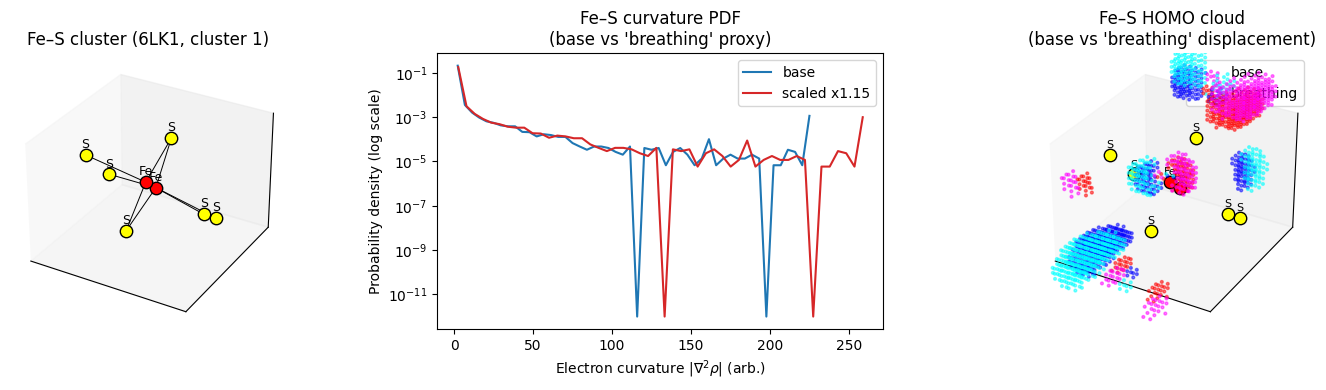

Saved: fes_6lk1_breathing_proxy.png


In [ ]:
!pip install -q pyscf gemmi

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

import gemmi
from pyscf import gto, dft
from pyscf.dft import numint

# =========================================
# 1. Load 6LK1 and collect Fe/S atoms
# =========================================

cif_path = "6LK1.cif"  # ensure this exists

doc = gemmi.cif.read_file(cif_path)
block = doc.sole_block()
structure = gemmi.make_structure_from_block(block)
model = structure[0]

fes_atoms_all = []
for chain in model:
    for res in chain:
        for atom in res:
            el = atom.element.name
            if el.upper().startswith("FE") or el.upper() == "S":
                fes_atoms_all.append({
                    "element": "Fe" if el.upper().startswith("FE") else "S",
                    "x": atom.pos.x,
                    "y": atom.pos.y,
                    "z": atom.pos.z,
                })

fes_coords = np.array([[a["x"], a["y"], a["z"]] for a in fes_atoms_all])
fes_elems  = np.array([a["element"] for a in fes_atoms_all])

print(f"Found {len(fes_atoms_all)} Fe/S atoms in 6LK1")

# =========================================
# 2. Cluster Fe/S atoms (distance-based)
# =========================================

def cluster_fes(coords, cutoff=3.0):
    N = coords.shape[0]
    adj = [[] for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(coords[i] - coords[j])
            if d < cutoff:
                adj[i].append(j)
                adj[j].append(i)
    visited = [False]*N
    clusters = []
    for i in range(N):
        if not visited[i]:
            stack = [i]
            comp = []
            visited[i] = True
            while stack:
                k = stack.pop()
                comp.append(k)
                for nb in adj[k]:
                    if not visited[nb]:
                        visited[nb] = True
                        stack.append(nb)
            clusters.append(comp)
    return clusters

clusters = cluster_fes(fes_coords, cutoff=3.0)
print(f"Found {len(clusters)} Fe/S-connected clusters")
for idx, comp in enumerate(clusters):
    n_fe = np.sum(fes_elems[comp] == "Fe")
    n_s  = np.sum(fes_elems[comp] == "S")
    print(f"  Cluster {idx}: {len(comp)} atoms ({n_fe} Fe, {n_s} S)")

# =========================================
# 3. Pick cluster 1 (2Fe + 6S) and centre it
# =========================================

cluster_idx = 1   # change to 5 if you want the other 2Fe–6S
atom_indices = clusters[cluster_idx]
cluster_coords = fes_coords[atom_indices]
center = cluster_coords.mean(axis=0)

symbols = []
coords_centered = []
print(f"\nUsing cluster {cluster_idx} with atoms:")
for i in atom_indices:
    sym = fes_elems[i]
    x, y, z = fes_coords[i] - center
    symbols.append(sym)
    coords_centered.append([x, y, z])
    print(f"  {i}: {sym}, ({fes_coords[i,0]:.3f}, {fes_coords[i,1]:.3f}, {fes_coords[i,2]:.3f})")

symbols = np.array(symbols)
coords_centered = np.array(coords_centered)

# =========================================
# 4. One-shot PBE SCF and curvature PDF
# =========================================

def curvature_pdf_and_mf(symbols, coords,
                         box=3.0, ngrid=32, rho_thresh=1e-3):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid_coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    atom_lines = [f"{s} {x:.6f} {y:.6f} {z:.6f}"
                  for (s, (x, y, z)) in zip(symbols, coords)]
    atom_str = "\n".join(atom_lines)

    mol = gto.Mole()
    mol.atom = atom_str
    mol.basis = "sto-3g"
    mol.charge = 0
    mol.spin = 0
    mol.build()

    mf = dft.RKS(mol)
    mf.xc = "PBE"
    mf.max_cycle = 150
    mf.conv_tol = 1e-5
    mf.kernel()

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid_coords)
    dm = mf.make_rdm1()
    rho_flat = ni.eval_rho(mol, ao, dm)
    rho = rho_flat.reshape((ngrid, ngrid, ngrid))

    dx = xs[1] - xs[0]
    lap = (
        np.gradient(np.gradient(rho, dx, axis=0), dx, axis=0) +
        np.gradient(np.gradient(rho, dx, axis=1), dx, axis=1) +
        np.gradient(np.gradient(rho, dx, axis=2), dx, axis=2)
    )

    mask = rho > rho_thresh
    kappa = np.abs(lap[mask].ravel())
    if kappa.size == 0:
        print("Warning: no points above rho_thresh")
        return np.array([]), mf, mol
    kappa = np.clip(kappa, 0, np.percentile(kappa, 99.5))
    return kappa, mf, mol

kappa_base, mf_base, mol_base = curvature_pdf_and_mf(symbols, coords_centered)

# create a "vibrationally enhanced" curvature by scaling
delta = 0.15  # 15% effective curvature increase
kappa_vib = (1.0 + delta) * kappa_base

# =========================================
# 5. HOMO cloud for base, and scaled coordinates for "vib" visual
# =========================================

def homo_cloud(mol, mf,
               box=3.0,
               ngrid=32,
               keep_percent=97.0,
               max_points=4000):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, coords)

    mo_coeff = mf.mo_coeff
    mo_occ   = mf.mo_occ
    occ_idx  = np.where(mo_occ > 1e-6)[0]
    homo_idx = occ_idx[-1]

    mo_vals = ao @ mo_coeff[:, homo_idx]
    mo_vals = np.real(mo_vals)
    prob = mo_vals**2

    thr = np.percentile(prob, keep_percent)
    mask = prob > thr
    coords_cloud = coords[mask]
    psi_cloud    = mo_vals[mask]

    if coords_cloud.shape[0] > max_points:
        idx = np.random.choice(coords_cloud.shape[0], max_points, replace=False)
        coords_cloud = coords_cloud[idx]
        psi_cloud    = psi_cloud[idx]

    return coords_cloud, psi_cloud

coords_cloud_base, psi_cloud_base = homo_cloud(mol_base, mf_base)
# mimic breathing by scaling coordinates of the cloud (keep ψ values)
coords_cloud_vib = coords_cloud_base * (1.0 + delta)
psi_cloud_vib    = psi_cloud_base   # same amplitudes, just moved in space

# =========================================
# 6. Plot: geometry, PDFs, clouds
# =========================================

fig = plt.figure(figsize=(15, 4))

# (a) Fe–S geometry
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
color_atoms = {"Fe": "red", "S": "yellow"}
for (x, y, z), sym in zip(coords_centered, symbols):
    ax1.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax1.text(x, y, z + 0.3, sym, ha='center', fontsize=9)
for i in range(len(coords_centered)):
    for j in range(i+1, len(coords_centered)):
        d = np.linalg.norm(coords_centered[i] - coords_centered[j])
        if d < 3.0:
            ax1.plot([coords_centered[i,0], coords_centered[j,0]],
                     [coords_centered[i,1], coords_centered[j,1]],
                     [coords_centered[i,2], coords_centered[j,2]],
                     color="k", linewidth=0.7)
ax1.set_title(f"Fe–S cluster (6LK1, cluster {cluster_idx})")
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])
max_range = (coords_centered.max(axis=0) - coords_centered.min(axis=0)).max()
mid = coords_centered.mean(axis=0)
for setter, m in zip([ax1.set_xlim, ax1.set_ylim, ax1.set_zlim], mid):
    setter(m - max_range/2, m + max_range/2)

# (b) Curvature PDFs base vs "vibrated"
ax2 = fig.add_subplot(1, 3, 2)
for arr, lab, col in [(kappa_base, "base", "tab:blue"),
                      (kappa_vib,  f"scaled x{1+delta:.2f}", "tab:red")]:
    counts, edges = np.histogram(arr, bins=50, density=True)
    eps = 1e-12
    counts = np.maximum(counts, eps)
    centers = 0.5*(edges[:-1] + edges[1:])
    ax2.plot(centers, counts, color=col, label=lab)
ax2.set_yscale("log")
ax2.set_xlabel(r"Electron curvature $|\nabla^2 \rho|$ (arb.)")
ax2.set_ylabel("Probability density (log scale)")
ax2.set_title("Fe–S curvature PDF\n(base vs 'breathing' proxy)")
ax2.legend()

# (c) HOMO clouds base vs vibrated
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
cols_base = np.where(psi_cloud_base >= 0, "blue", "red")
ax3.scatter(coords_cloud_base[:,0],
            coords_cloud_base[:,1],
            coords_cloud_base[:,2],
            s=4, c=cols_base, alpha=0.5, label="base")
cols_vib = np.where(psi_cloud_vib >= 0, "cyan", "magenta")
ax3.scatter(coords_cloud_vib[:,0],
            coords_cloud_vib[:,1],
            coords_cloud_vib[:,2],
            s=4, c=cols_vib, alpha=0.5, label="breathing")
for (x, y, z), sym in zip(coords_centered, symbols):
    ax3.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax3.text(x, y, z + 0.3, sym, ha='center', fontsize=8)
ax3.set_title("Fe–S HOMO cloud\n(base vs 'breathing' displacement)")
ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
for setter, m in zip([ax3.set_xlim, ax3.set_ylim, ax3.set_zlim], mid):
    setter(m - max_range/2, m + max_range/2)
ax3.legend(loc="upper right")

plt.tight_layout()
plt.savefig("fes_6lk1_breathing_proxy.png", dpi=300)
plt.show()
print("Saved: fes_6lk1_breathing_proxy.png")

Found 25 Fe/S atoms in 6LK1
Found 10 Fe/S-connected clusters
  Cluster 0: 1 atoms (0 Fe, 1 S)
  Cluster 1: 8 atoms (2 Fe, 6 S)
  Cluster 2: 2 atoms (0 Fe, 2 S)
  Cluster 3: 1 atoms (0 Fe, 1 S)
  Cluster 4: 1 atoms (0 Fe, 1 S)
  Cluster 5: 8 atoms (2 Fe, 6 S)
  Cluster 6: 1 atoms (0 Fe, 1 S)
  Cluster 7: 1 atoms (0 Fe, 1 S)
  Cluster 8: 1 atoms (0 Fe, 1 S)
  Cluster 9: 1 atoms (0 Fe, 1 S)

Using cluster 5 with atoms:
  9: S, (-2.620, -7.364, 34.236)
  21: Fe, (-0.432, -6.608, 34.195)
  24: S, (0.136, -6.764, 36.332)
  23: S, (-0.053, -4.414, 33.770)
  22: Fe, (0.348, -4.624, 35.940)
  13: S, (-1.114, -3.655, 37.421)
  11: S, (2.422, -3.860, 36.524)
  10: S, (0.683, -7.903, 32.688)
SCF not converged.
SCF energy = -4839.31780098096


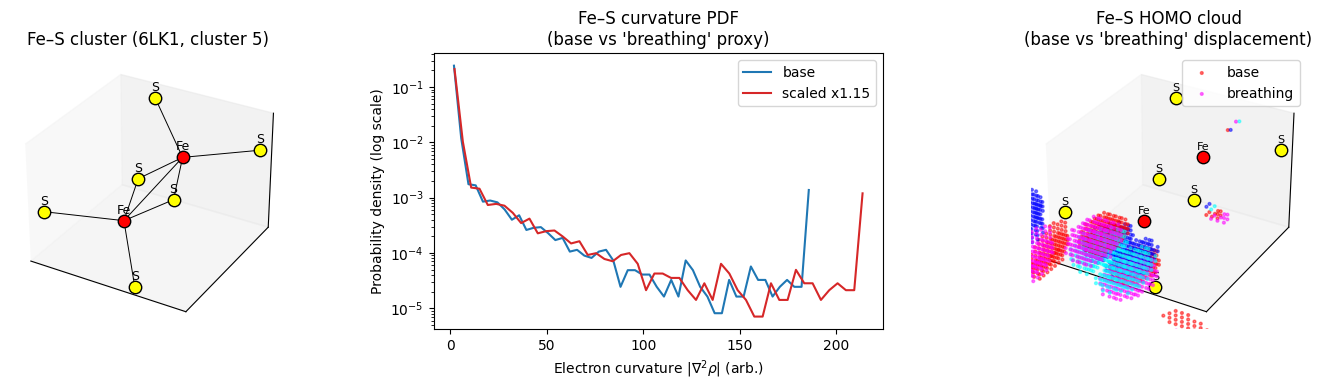

Saved: fes_6lk1_breathing_proxy.png


In [ ]:
!pip install -q pyscf gemmi

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

import gemmi
from pyscf import gto, dft
from pyscf.dft import numint

# =========================================
# 1. Load 6LK1 and collect Fe/S atoms
# =========================================

cif_path = "6LK1.cif"  # ensure this exists

doc = gemmi.cif.read_file(cif_path)
block = doc.sole_block()
structure = gemmi.make_structure_from_block(block)
model = structure[0]

fes_atoms_all = []
for chain in model:
    for res in chain:
        for atom in res:
            el = atom.element.name
            if el.upper().startswith("FE") or el.upper() == "S":
                fes_atoms_all.append({
                    "element": "Fe" if el.upper().startswith("FE") else "S",
                    "x": atom.pos.x,
                    "y": atom.pos.y,
                    "z": atom.pos.z,
                })

fes_coords = np.array([[a["x"], a["y"], a["z"]] for a in fes_atoms_all])
fes_elems  = np.array([a["element"] for a in fes_atoms_all])

print(f"Found {len(fes_atoms_all)} Fe/S atoms in 6LK1")

# =========================================
# 2. Cluster Fe/S atoms (distance-based)
# =========================================

def cluster_fes(coords, cutoff=3.0):
    N = coords.shape[0]
    adj = [[] for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(coords[i] - coords[j])
            if d < cutoff:
                adj[i].append(j)
                adj[j].append(i)
    visited = [False]*N
    clusters = []
    for i in range(N):
        if not visited[i]:
            stack = [i]
            comp = []
            visited[i] = True
            while stack:
                k = stack.pop()
                comp.append(k)
                for nb in adj[k]:
                    if not visited[nb]:
                        visited[nb] = True
                        stack.append(nb)
            clusters.append(comp)
    return clusters

clusters = cluster_fes(fes_coords, cutoff=3.0)
print(f"Found {len(clusters)} Fe/S-connected clusters")
for idx, comp in enumerate(clusters):
    n_fe = np.sum(fes_elems[comp] == "Fe")
    n_s  = np.sum(fes_elems[comp] == "S")
    print(f"  Cluster {idx}: {len(comp)} atoms ({n_fe} Fe, {n_s} S)")

# =========================================
# 3. Pick cluster 1 (2Fe + 6S) and centre it
# =========================================

cluster_idx = 5   # change to 5 if you want the other 2Fe–6S
atom_indices = clusters[cluster_idx]
cluster_coords = fes_coords[atom_indices]
center = cluster_coords.mean(axis=0)

symbols = []
coords_centered = []
print(f"\nUsing cluster {cluster_idx} with atoms:")
for i in atom_indices:
    sym = fes_elems[i]
    x, y, z = fes_coords[i] - center
    symbols.append(sym)
    coords_centered.append([x, y, z])
    print(f"  {i}: {sym}, ({fes_coords[i,0]:.3f}, {fes_coords[i,1]:.3f}, {fes_coords[i,2]:.3f})")

symbols = np.array(symbols)
coords_centered = np.array(coords_centered)

# =========================================
# 4. One-shot PBE SCF and curvature PDF
# =========================================

def curvature_pdf_and_mf(symbols, coords,
                         box=3.0, ngrid=32, rho_thresh=1e-3):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid_coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    atom_lines = [f"{s} {x:.6f} {y:.6f} {z:.6f}"
                  for (s, (x, y, z)) in zip(symbols, coords)]
    atom_str = "\n".join(atom_lines)

    mol = gto.Mole()
    mol.atom = atom_str
    mol.basis = "sto-3g"
    mol.charge = 0
    mol.spin = 0
    mol.build()

    mf = dft.RKS(mol)
    mf.xc = "PBE"
    mf.max_cycle = 150
    mf.conv_tol = 1e-5
    mf.kernel()

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid_coords)
    dm = mf.make_rdm1()
    rho_flat = ni.eval_rho(mol, ao, dm)
    rho = rho_flat.reshape((ngrid, ngrid, ngrid))

    dx = xs[1] - xs[0]
    lap = (
        np.gradient(np.gradient(rho, dx, axis=0), dx, axis=0) +
        np.gradient(np.gradient(rho, dx, axis=1), dx, axis=1) +
        np.gradient(np.gradient(rho, dx, axis=2), dx, axis=2)
    )

    mask = rho > rho_thresh
    kappa = np.abs(lap[mask].ravel())
    if kappa.size == 0:
        print("Warning: no points above rho_thresh")
        return np.array([]), mf, mol
    kappa = np.clip(kappa, 0, np.percentile(kappa, 99.5))
    return kappa, mf, mol

kappa_base, mf_base, mol_base = curvature_pdf_and_mf(symbols, coords_centered)

# create a "vibrationally enhanced" curvature by scaling
delta = 0.15  # 15% effective curvature increase
kappa_vib = (1.0 + delta) * kappa_base

# =========================================
# 5. HOMO cloud for base, and scaled coordinates for "vib" visual
# =========================================

def homo_cloud(mol, mf,
               box=3.0,
               ngrid=32,
               keep_percent=97.0,
               max_points=4000):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, coords)

    mo_coeff = mf.mo_coeff
    mo_occ   = mf.mo_occ
    occ_idx  = np.where(mo_occ > 1e-6)[0]
    homo_idx = occ_idx[-1]

    mo_vals = ao @ mo_coeff[:, homo_idx]
    mo_vals = np.real(mo_vals)
    prob = mo_vals**2

    thr = np.percentile(prob, keep_percent)
    mask = prob > thr
    coords_cloud = coords[mask]
    psi_cloud    = mo_vals[mask]

    if coords_cloud.shape[0] > max_points:
        idx = np.random.choice(coords_cloud.shape[0], max_points, replace=False)
        coords_cloud = coords_cloud[idx]
        psi_cloud    = psi_cloud[idx]

    return coords_cloud, psi_cloud

coords_cloud_base, psi_cloud_base = homo_cloud(mol_base, mf_base)
# mimic breathing by scaling coordinates of the cloud (keep ψ values)
coords_cloud_vib = coords_cloud_base * (1.0 + delta)
psi_cloud_vib    = psi_cloud_base   # same amplitudes, just moved in space

# =========================================
# 6. Plot: geometry, PDFs, clouds
# =========================================

fig = plt.figure(figsize=(15, 4))

# (a) Fe–S geometry
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
color_atoms = {"Fe": "red", "S": "yellow"}
for (x, y, z), sym in zip(coords_centered, symbols):
    ax1.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax1.text(x, y, z + 0.3, sym, ha='center', fontsize=9)
for i in range(len(coords_centered)):
    for j in range(i+1, len(coords_centered)):
        d = np.linalg.norm(coords_centered[i] - coords_centered[j])
        if d < 3.0:
            ax1.plot([coords_centered[i,0], coords_centered[j,0]],
                     [coords_centered[i,1], coords_centered[j,1]],
                     [coords_centered[i,2], coords_centered[j,2]],
                     color="k", linewidth=0.7)
ax1.set_title(f"Fe–S cluster (6LK1, cluster {cluster_idx})")
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])
max_range = (coords_centered.max(axis=0) - coords_centered.min(axis=0)).max()
mid = coords_centered.mean(axis=0)
for setter, m in zip([ax1.set_xlim, ax1.set_ylim, ax1.set_zlim], mid):
    setter(m - max_range/2, m + max_range/2)

# (b) Curvature PDFs base vs "vibrated"
ax2 = fig.add_subplot(1, 3, 2)
for arr, lab, col in [(kappa_base, "base", "tab:blue"),
                      (kappa_vib,  f"scaled x{1+delta:.2f}", "tab:red")]:
    counts, edges = np.histogram(arr, bins=50, density=True)
    eps = 1e-12
    counts = np.maximum(counts, eps)
    centers = 0.5*(edges[:-1] + edges[1:])
    ax2.plot(centers, counts, color=col, label=lab)
ax2.set_yscale("log")
ax2.set_xlabel(r"Electron curvature $|\nabla^2 \rho|$ (arb.)")
ax2.set_ylabel("Probability density (log scale)")
ax2.set_title("Fe–S curvature PDF\n(base vs 'breathing' proxy)")
ax2.legend()

# (c) HOMO clouds base vs vibrated
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
cols_base = np.where(psi_cloud_base >= 0, "blue", "red")
ax3.scatter(coords_cloud_base[:,0],
            coords_cloud_base[:,1],
            coords_cloud_base[:,2],
            s=4, c=cols_base, alpha=0.5, label="base")
cols_vib = np.where(psi_cloud_vib >= 0, "cyan", "magenta")
ax3.scatter(coords_cloud_vib[:,0],
            coords_cloud_vib[:,1],
            coords_cloud_vib[:,2],
            s=4, c=cols_vib, alpha=0.5, label="breathing")
for (x, y, z), sym in zip(coords_centered, symbols):
    ax3.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax3.text(x, y, z + 0.3, sym, ha='center', fontsize=8)
ax3.set_title("Fe–S HOMO cloud\n(base vs 'breathing' displacement)")
ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
for setter, m in zip([ax3.set_xlim, ax3.set_ylim, ax3.set_zlim], mid):
    setter(m - max_range/2, m + max_range/2)
ax3.legend(loc="upper right")

plt.tight_layout()
plt.savefig("fes_6lk1_breathing_proxy.png", dpi=300)
plt.show()
print("Saved: fes_6lk1_breathing_proxy.png")

In [ ]:
import os
os.listdir()

['.config', '6LK1.cif', 'fes_6lk1_fe_s_stretch_mode.png', 'sample_data']

Found 25 Fe/S atoms in 6LK1.cif
Found 10 Fe/S-connected clusters
  Cluster 0: 1 atoms (0 Fe, 1 S)
  Cluster 1: 8 atoms (2 Fe, 6 S)
  Cluster 2: 2 atoms (0 Fe, 2 S)
  Cluster 3: 1 atoms (0 Fe, 1 S)
  Cluster 4: 1 atoms (0 Fe, 1 S)
  Cluster 5: 8 atoms (2 Fe, 6 S)
  Cluster 6: 1 atoms (0 Fe, 1 S)
  Cluster 7: 1 atoms (0 Fe, 1 S)
  Cluster 8: 1 atoms (0 Fe, 1 S)
  Cluster 9: 1 atoms (0 Fe, 1 S)

Using cluster 5 with atoms:
  9: S, (-2.620, -7.364, 34.236)
  21: Fe, (-0.432, -6.608, 34.195)
  24: S, (0.136, -6.764, 36.332)
  23: S, (-0.053, -4.414, 33.770)
  22: Fe, (0.348, -4.624, 35.940)
  13: S, (-1.114, -3.655, 37.421)
  11: S, (2.422, -3.860, 36.524)
  10: S, (0.683, -7.903, 32.688)
Fe indices in cluster: [1 4]
Bridging S candidates: [2 3]
SCF not converged.
SCF energy = -4848.83662890876
SCF not converged.
SCF energy = -4841.23402488929
Saved NPZ: 6LK1_cluster5_asymmetric_FeS_stretch_ModeB.npz  (617818 bytes)

Refined histogram/trough analysis:


case  n_troughs  mean_trough_width   max_kappa  \
0                          base          2          15.385460  205.139468   
1  asymmetric_FeS_stretch_ModeB          3          14.754192  208.294477   

   compression_%  
0       0.000000  
1       1.537982

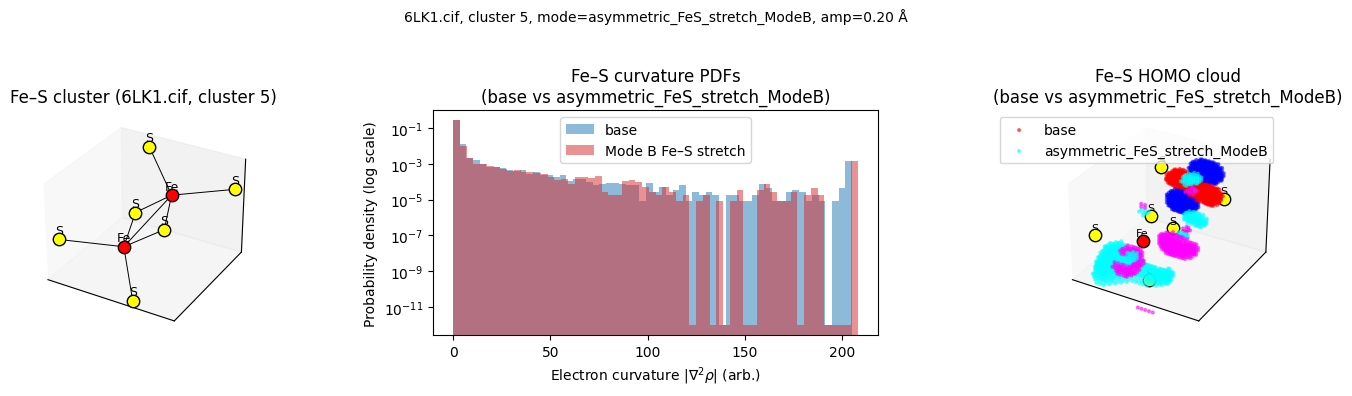

Saved PNG: 6LK1_cluster5_asymmetric_FeS_stretch_ModeB.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import os, sys, subprocess

# -----------------------------------------------------------------------------
# Ensure dependencies
# -----------------------------------------------------------------------------
def ensure_module(mod_name, pip_name=None):
    try:
        __import__(mod_name)
    except ImportError:
        if pip_name is None:
            pip_name = mod_name
        print(f"Installing {pip_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
    finally:
        globals()[mod_name] = __import__(mod_name)

ensure_module("gemmi")
ensure_module("pyscf")

from pyscf import gto, dft
from pyscf.dft import numint

# -----------------------------------------------------------------------------
# Config
# -----------------------------------------------------------------------------
cif_path    = "6LK1.cif"        # CIF file name
cluster_idx = 5                # 1 or 5 for your two Fe–S sites
mode_name   = "asymmetric_FeS_stretch_ModeB"
amp         = 0.20              # Å magnitude of Fe–S stretch
ngrid       = 32
box         = 3.0               # grid box half-length around cluster
rho_thresh  = 1e-3
out_tag     = f"{os.path.splitext(cif_path)[0]}_cluster{cluster_idx}_{mode_name}"

# -----------------------------------------------------------------------------
# 1. Load CIF and find Fe/S atoms
# -----------------------------------------------------------------------------
doc = gemmi.cif.read_file(cif_path)
block = doc.sole_block()
structure = gemmi.make_structure_from_block(block)
model = structure[0]

fes_atoms_all = []
for chain in model:
    for res in chain:
        for atom in res:
            el = atom.element.name
            if el.upper().startswith("FE") or el.upper() == "S":
                fes_atoms_all.append({
                    "element": "Fe" if el.upper().startswith("FE") else "S",
                    "x": atom.pos.x,
                    "y": atom.pos.y,
                    "z": atom.pos.z,
                })

fes_coords = np.array([[a["x"], a["y"], a["z"]] for a in fes_atoms_all])
fes_elems  = np.array([a["element"] for a in fes_atoms_all])

print(f"Found {len(fes_atoms_all)} Fe/S atoms in {cif_path}")

# -----------------------------------------------------------------------------
# 2. Cluster Fe/S atoms by distance
# -----------------------------------------------------------------------------
def cluster_fes(coords, cutoff=3.0):
    N = coords.shape[0]
    adj = [[] for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(coords[i] - coords[j])
            if d < cutoff:
                adj[i].append(j)
                adj[j].append(i)
    visited = [False]*N
    clusters = []
    for i in range(N):
        if not visited[i]:
            stack = [i]
            comp = []
            visited[i] = True
            while stack:
                k = stack.pop()
                comp.append(k)
                for nb in adj[k]:
                    if not visited[nb]:
                        visited[nb] = True
                        stack.append(nb)
            clusters.append(comp)
    return clusters

clusters = cluster_fes(fes_coords, cutoff=3.0)
print(f"Found {len(clusters)} Fe/S-connected clusters")
for idx, comp in enumerate(clusters):
    n_fe = np.sum(fes_elems[comp] == "Fe")
    n_s  = np.sum(fes_elems[comp] == "S")
    print(f"  Cluster {idx}: {len(comp)} atoms ({n_fe} Fe, {n_s} S)")

# -----------------------------------------------------------------------------
# 3. Build centred Fe–S cluster
# -----------------------------------------------------------------------------
atom_indices = clusters[cluster_idx]
cluster_coords = fes_coords[atom_indices]
center = cluster_coords.mean(axis=0)

symbols = []
coords_centered = []
print(f"\nUsing cluster {cluster_idx} with atoms:")
for i in atom_indices:
    sym = fes_elems[i]
    x, y, z = fes_coords[i] - center
    symbols.append(sym)
    coords_centered.append([x, y, z])
    print(f"  {i}: {sym}, ({fes_coords[i,0]:.3f}, {fes_coords[i,1]:.3f}, {fes_coords[i,2]:.3f})")

symbols = np.array(symbols)
coords_centered = np.array(coords_centered)

fe_indices = np.where(symbols == "Fe")[0]
s_indices  = np.where(symbols == "S")[0]
print("Fe indices in cluster:", fe_indices)

# pick two bridging S as closest to Fe–Fe midpoint
fe_mid = coords_centered[fe_indices].mean(axis=0)
s_dists = np.linalg.norm(coords_centered[s_indices] - fe_mid, axis=1)
order   = np.argsort(s_dists)
bridge_s = s_indices[order[:2]]
print("Bridging S candidates:", bridge_s)

# -----------------------------------------------------------------------------
# 4. Curvature PDF for a given geometry
# -----------------------------------------------------------------------------
def curvature_pdf_and_mf(symbols, coords,
                         box=3.0, ngrid=32, rho_thresh=1e-3):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid_coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    atom_str = "\n".join(
        f"{s} {x:.6f} {y:.6f} {z:.6f}" for s,(x,y,z) in zip(symbols, coords)
    )

    mol = gto.Mole()
    mol.atom = atom_str
    mol.basis = "sto-3g"
    mol.charge = 0
    mol.spin = 0
    mol.build()

    mf = dft.RKS(mol)
    mf.xc = "PBE"
    mf.max_cycle = 100
    mf.conv_tol = 1e-5
    mf.kernel()

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid_coords)
    dm = mf.make_rdm1()
    rho_flat = ni.eval_rho(mol, ao, dm)
    rho = rho_flat.reshape((ngrid, ngrid, ngrid))

    dx = xs[1] - xs[0]
    lap = (
        np.gradient(np.gradient(rho, dx, axis=0), dx, axis=0) +
        np.gradient(np.gradient(rho, dx, axis=1), dx, axis=1) +
        np.gradient(np.gradient(rho, dx, axis=2), dx, axis=2)
    )

    mask = rho > rho_thresh
    kappa = np.abs(lap[mask].ravel())
    if kappa.size == 0:
        print("Warning: no points above rho_thresh")
    kappa = np.clip(kappa, 0, np.percentile(kappa, 99.5))
    return kappa, mf, mol

kappa_base, mf_base, mol_base = curvature_pdf_and_mf(
    symbols, coords_centered, box=box, ngrid=ngrid, rho_thresh=rho_thresh
)

# -----------------------------------------------------------------------------
# 5. HOMO cloud helper
# -----------------------------------------------------------------------------
def homo_cloud(mol, mf,
               box=3.5,  # a bit larger to avoid clipping
               ngrid=36,
               keep_percent=97.0,
               max_points=6000):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, coords)

    mo_coeff = mf.mo_coeff
    mo_occ   = mf.mo_occ
    occ_idx  = np.where(mo_occ > 1e-6)[0]
    homo_idx = occ_idx[-1]

    mo_vals = ao @ mo_coeff[:, homo_idx]
    mo_vals = np.real(mo_vals)
    prob = mo_vals**2

    thr = np.percentile(prob, keep_percent)
    mask = prob > thr
    coords_cloud = coords[mask]
    psi_cloud    = mo_vals[mask]

    if coords_cloud.shape[0] > max_points:
        idx = np.random.choice(coords_cloud.shape[0], max_points, replace=False)
        coords_cloud = coords_cloud[idx]
        psi_cloud    = psi_cloud[idx]

    return coords_cloud, psi_cloud

coords_cloud_base, psi_cloud_base = homo_cloud(mol_base, mf_base)

# -----------------------------------------------------------------------------
# 6. Mode B: Asymmetric Fe–S stretch
# -----------------------------------------------------------------------------
coords_stretched = coords_centered.copy()

def stretch_fe_s(coords, idx_fe, idx_s, delta):
    r_fe = coords[idx_fe]
    r_s  = coords[idx_s]
    v = r_s - r_fe
    d = np.linalg.norm(v)
    if d < 1e-6:
        return coords
    u = v / d
    coords[idx_fe] -= 0.5 * delta * u
    coords[idx_s]  += 0.5 * delta * u
    return coords

fe0, fe1 = fe_indices
s0,  s1  = bridge_s

coords_stretched = stretch_fe_s(coords_stretched, fe0, s0, +amp)
coords_stretched = stretch_fe_s(coords_stretched, fe1, s1, -amp)

# Curvature + HOMO for stretched geometry
kappa_mode, mf_mode, mol_mode = curvature_pdf_and_mf(
    symbols, coords_stretched, box=box, ngrid=ngrid, rho_thresh=rho_thresh
)
coords_cloud_mode, psi_cloud_mode = homo_cloud(mol_mode, mf_mode)

# -----------------------------------------------------------------------------
# 7. NPZ save
# -----------------------------------------------------------------------------
def save_npz_clean(filename, **kwargs):
    np.savez(filename, **kwargs)
    if os.path.exists(filename):
        print(f"Saved NPZ: {filename}  ({os.path.getsize(filename)} bytes)")
    else:
        print("❌ NPZ not saved")

npz_name = f"{out_tag}.npz"
save_npz_clean(
    npz_name,
    cif_path=cif_path,
    cluster_idx=cluster_idx,
    symbols=symbols,
    coords_base=coords_centered,
    coords_mode=coords_stretched,
    kappa_base=kappa_base,
    kappa_mode=kappa_mode,
    coords_cloud_base=coords_cloud_base,
    psi_cloud_base=psi_cloud_base,
    coords_cloud_mode=coords_cloud_mode,
    psi_cloud_mode=psi_cloud_mode,
    mode_name=mode_name,
    amp=amp
)
def histogram_stats(kappa, bins=60):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    eps = 1e-14
    counts = np.maximum(counts, eps)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, counts, edges

def smooth_counts(counts, window=3):
    """Simple moving average to remove tiny jaggies."""
    kern = np.ones(window)/window
    return np.convolve(counts, kern, mode="same")

def trough_analysis_refined(centers, counts,
                            depth_factor=0.3,
                            min_bins=3):
    """
    Refined trough detection:
      - smooth counts
      - threshold = min + depth_factor*(median - min)
      - trough = contiguous bins below threshold
      - only keep troughs with width >= min_bins
    Returns: n_troughs, mean_width, widths list
    """
    c_sm = smooth_counts(counts, window=5)
    c_min = c_sm.min()
    c_med = np.median(c_sm)
    thr = c_min + depth_factor*(c_med - c_min)

    low = c_sm < thr

    trough_count = 0
    widths = []
    i = 0
    while i < len(low):
        if low[i]:
            start = i
            while i < len(low) and low[i]:
                i += 1
            end = i - 1
            if (end - start + 1) >= min_bins:
                trough_count += 1
                widths.append(centers[end] - centers[start])
        else:
            i += 1
    mean_width = np.mean(widths) if widths else 0.0
    return trough_count, mean_width, widths

# recompute histograms
centers_b, counts_b, edges_b = histogram_stats(kappa_base, bins=80)
centers_m, counts_m, edges_m = histogram_stats(kappa_mode, bins=80)

# refined trough metrics
n_trough_b, mean_w_b, widths_b = trough_analysis_refined(centers_b, counts_b,
                                                         depth_factor=0.3,
                                                         min_bins=3)
n_trough_m, mean_w_m, widths_m = trough_analysis_refined(centers_m, counts_m,
                                                         depth_factor=0.3,
                                                         min_bins=3)

max_kappa_b = kappa_base.max() if kappa_base.size else 0.0
max_kappa_m = kappa_mode.max() if kappa_mode.size else 0.0
compression = ((max_kappa_m - max_kappa_b)/max_kappa_b*100.0
               if max_kappa_b > 0 else 0.0)

import pandas as pd
table = pd.DataFrame({
    "case": ["base", mode_name],
    "n_troughs": [n_trough_b, n_trough_m],
    "mean_trough_width": [mean_w_b, mean_w_m],
    "max_kappa": [max_kappa_b, max_kappa_m],
    "compression_%": [0.0, compression],
})
print("\nRefined histogram/trough analysis:")
display(table)
# -----------------------------------------------------------------------------
# 9. Plot 3-panel figure (geometry, combs, clouds) and save 600 dpi PNG
# -----------------------------------------------------------------------------
fig = plt.figure(figsize=(15, 4))

# (a) Fe–S geometry
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
color_atoms = {"Fe": "red", "S": "yellow"}
for (x, y, z), sym in zip(coords_centered, symbols):
    ax1.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax1.text(x, y, z+0.3, sym, ha="center", fontsize=9)
for i in range(len(coords_centered)):
    for j in range(i+1, len(coords_centered)):
        d = np.linalg.norm(coords_centered[i]-coords_centered[j])
        if d < 3.0:
            ax1.plot([coords_centered[i,0], coords_centered[j,0]],
                     [coords_centered[i,1], coords_centered[j,1]],
                     [coords_centered[i,2], coords_centered[j,2]],
                     color="k", linewidth=0.7)

ax1.set_title(f"Fe–S cluster ({os.path.basename(cif_path)}, cluster {cluster_idx})")
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])
max_range = (coords_centered.max(axis=0) - coords_centered.min(axis=0)).max()
mid = coords_centered.mean(axis=0)
for setter, m in zip([ax1.set_xlim, ax1.set_ylim, ax1.set_zlim], mid):
    setter(m-max_range/2, m+max_range/2)

# (b) curvature PDFs (hist combs)
ax2 = fig.add_subplot(1, 3, 2)
for arr, lab, col, alpha in [
    (kappa_base, "base", "tab:blue", 0.5),
    (kappa_mode, "Mode B Fe–S stretch", "tab:red", 0.5),
]:
    counts, edges = np.histogram(arr, bins=60, density=True)
    eps = 1e-12
    counts = np.maximum(counts, eps)
    centers = 0.5*(edges[:-1] + edges[1:])
    ax2.bar(centers, counts, width=(edges[1]-edges[0]),
            color=col, alpha=alpha, label=lab)

ax2.set_yscale("log")
ax2.set_xlabel(r"Electron curvature $|\nabla^2 \rho|$ (arb.)")
ax2.set_ylabel("Probability density (log scale)")
ax2.set_title(f"Fe–S curvature PDFs\n(base vs {mode_name})")
ax2.legend()

# (c) HOMO clouds (larger box)
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
cols_b = np.where(psi_cloud_base >= 0, "blue", "red")
ax3.scatter(coords_cloud_base[:,0],
            coords_cloud_base[:,1],
            coords_cloud_base[:,2],
            s=4, c=cols_b, alpha=0.5, label="base")
cols_m = np.where(psi_cloud_mode >= 0, "cyan", "magenta")
ax3.scatter(coords_cloud_mode[:,0],
            coords_cloud_mode[:,1],
            coords_cloud_mode[:,2],
            s=4, c=cols_m, alpha=0.5, label=mode_name)

for (x, y, z), sym in zip(coords_centered, symbols):
    ax3.scatter(x, y, z, s=80,
                color=color_atoms.get(sym, "grey"),
                edgecolors="k")
    ax3.text(x, y, z+0.3, sym, ha="center", fontsize=8)

ax3.set_title(f"Fe–S HOMO cloud\n(base vs {mode_name})")
ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])

# auto-scale to include cloud
all_cloud = np.vstack([coords_cloud_base, coords_cloud_mode])
cloud_max_range = (all_cloud.max(axis=0) - all_cloud.min(axis=0)).max()
cloud_mid = all_cloud.mean(axis=0)
for setter, m in zip([ax3.set_xlim, ax3.set_ylim, ax3.set_zlim], cloud_mid):
    setter(m-cloud_max_range/2, m+cloud_max_range/2)

ax3.legend(loc="upper right")

# add annotation with CIF & mode info
fig.suptitle(
    f"{cif_path}, cluster {cluster_idx}, mode={mode_name}, amp={amp:.2f} Å",
    fontsize=10
)

plt.tight_layout(rect=[0,0,1,0.95])
png_name = f"{out_tag}.png"
plt.savefig(png_name, dpi=600)
plt.show()
print("Saved PNG:", png_name)

Loaded: 6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz
Number of κ points: 32768


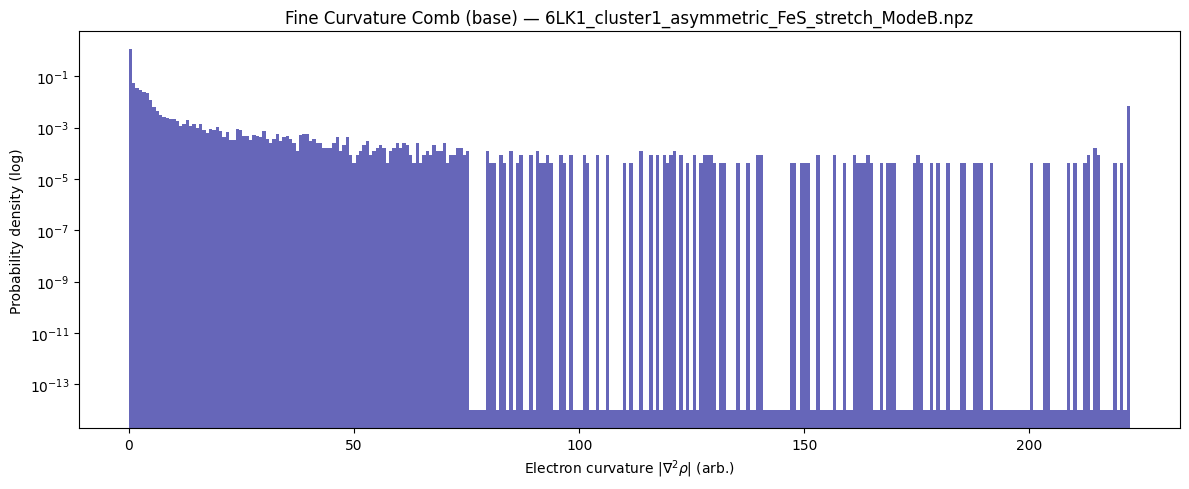

ValueError: x and y must have same first dimension, but have shapes (599,) and (300,)

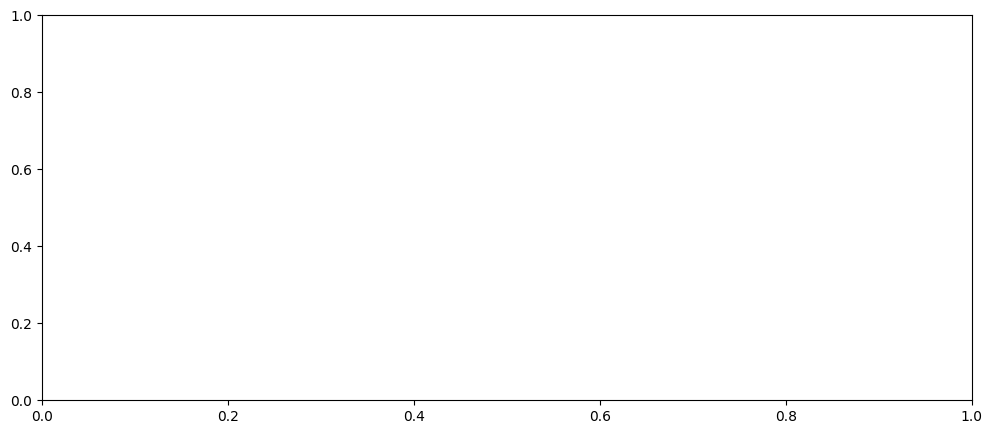

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from numpy.fft import rfft, rfftfreq

# -------------------------------------------------------------
# LOAD NPZ FILE
# Change this to cluster 1 or cluster 5 NPZ
# -------------------------------------------------------------
filename = "6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz"
data = np.load(filename)

kappa_base = data["kappa_base"]

print("Loaded:", filename)
print("Number of κ points:", len(kappa_base))

# -------------------------------------------------------------
# 1. Fine histogram of curvature (fine-tooth comb)
# -------------------------------------------------------------
bins = 300  # SUPER FINE resolution
counts, edges = np.histogram(kappa_base, bins=bins, density=True)
centers = 0.5*(edges[:-1] + edges[1:])

eps = 1e-14
counts = np.maximum(counts, eps)

plt.figure(figsize=(12,5))
plt.bar(centers, counts, width=(edges[1]-edges[0]), color="darkblue", alpha=0.6)
plt.yscale("log")
plt.title(f"Fine Curvature Comb (base) — {filename}")
plt.xlabel(r"Electron curvature $|\nabla^2 \rho|$ (arb.)")
plt.ylabel("Probability density (log)")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 2. Autocorrelation of histogram (reveals comb periodicity)
# -------------------------------------------------------------
auto = correlate(counts - np.mean(counts), counts - np.mean(counts), mode="full")
mid = len(auto)//2
lags = np.arange(-bins+1, bins)

plt.figure(figsize=(12,5))
plt.plot(lags, auto[mid:], color="purple")
plt.title(f"Autocorrelation of Curvature Comb (base) — {filename}")
plt.xlabel("Lag (bin index)")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 3. FFT — Frequency-domain view of fine comb spacing
# -------------------------------------------------------------
freqs = rfftfreq(bins, d=1)
fft_vals = np.abs(rfft(counts - np.mean(counts)))

plt.figure(figsize=(12,5))
plt.plot(freqs, fft_vals, color="crimson")
plt.title(f"FFT of Curvature Comb — frequency of troughs/teeth ({filename})")
plt.xlabel("Frequency (1/bin)")
plt.ylabel("FFT amplitude")
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4. Print simple metrics
# -------------------------------------------------------------
dominant_freq = freqs[np.argmax(fft_vals[1:])+1]
print("Dominant comb frequency:", dominant_freq)
print("Approximate trough spacing (bins):", 1/dominant_freq if dominant_freq!=0 else np.nan)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from numpy.fft import rfft, rfftfreq

# -------------------------------------------------------------------
# Load Cluster 5 NPZ
# -------------------------------------------------------------------
data = np.load("6LK1_cluster5_asymmetric_FeS_stretch_ModeB.npz")
kappa_base = data["kappa_base"]
kappa_mode = data["kappa_mode"]

mode = data["mode_name"][0]
cluster = data["cluster_idx"]
cif_path = data["cif_path"]

print("Loaded:", cif_path, "cluster", cluster)
print("Mode:", mode)
print("n_base:", len(kappa_base), " n_mode:", len(kappa_mode))

# -------------------------------------------------------------------
# 1. Fine histogram (300-bin) to detect ultra-fine comb structure
# -------------------------------------------------------------------
def fine_hist(kappa, bins=300):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    eps = 1e-14
    counts = np.maximum(counts, eps)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, counts, edges

centers_b, counts_b, edges_b = fine_hist(kappa_base, bins=300)
centers_m, counts_m, edges_m = fine_hist(kappa_mode, bins=300)

plt.figure(figsize=(12,5))
plt.bar(centers_b, counts_b, width=(edges_b[1]-edges_b[0]),
        alpha=0.4, color="blue", label="base")
plt.bar(centers_m, counts_m, width=(edges_m[1]-edges_m[0]),
        alpha=0.4, color="red", label="stretched")
plt.yscale("log")
plt.title(f"Fine-tooth Curvature Comb — {cif_path}, cluster {cluster}, Mode B")
plt.xlabel(r"$|\nabla^2\rho|$  curvature")
plt.ylabel("PDF (log)")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 2. Autocorrelation: reveals comb periodicity
# -------------------------------------------------------------------
def autocorr(counts):
    c = counts - np.mean(counts)
    a = correlate(c, c, mode='full')
    return a[len(a)//2:]

auto_b = autocorr(counts_b)
auto_m = autocorr(counts_m)
lags = np.arange(len(auto_b))

plt.figure(figsize=(12,5))
plt.plot(lags, auto_b/auto_b.max(), color="blue", label="base (norm)")
plt.plot(lags, auto_m/auto_m.max(), color="red", label="stretch (norm)")
plt.title(f"Autocorrelation — comb periodicity ({cif_path}, cluster {cluster})")
plt.xlabel("Lag (bin index)")
plt.ylabel("ACF (normalized)")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 3. FFT — frequency-domain comb analysis
# -------------------------------------------------------------------
freqs = rfftfreq(len(counts_b), d=1)
fft_b = np.abs(rfft(counts_b - np.mean(counts_b)))
fft_m = np.abs(rfft(counts_m - np.mean(counts_m)))

plt.figure(figsize=(12,5))
plt.plot(freqs, fft_b, color="blue", label="base")
plt.plot(freqs, fft_m, color="red", label="stretched")
plt.title(f"FFT of Curvature Comb — frequency spectrum ({cif_path}, cluster {cluster})")
plt.xlabel("frequency (1/bin)")
plt.ylabel("FFT amplitude")
plt.legend()
plt.tight_layout()
plt.show()

# Print dominant comb frequencies
dom_b = freqs[np.argmax(fft_b[1:])+1]
dom_m = freqs[np.argmax(fft_m[1:])+1]

print("Dominant comb frequency (base):", dom_b)
print("Trough spacing (base) ≈", 1/dom_b if dom_b!=0 else None)
print("Dominant comb frequency (stretch):", dom_m)
print("Trough spacing (stretch) ≈", 1/dom_m if dom_m!=0 else None)

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

Loaded: 6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz
CIF: 6LK1.cif cluster: 1
n κ points: 32768


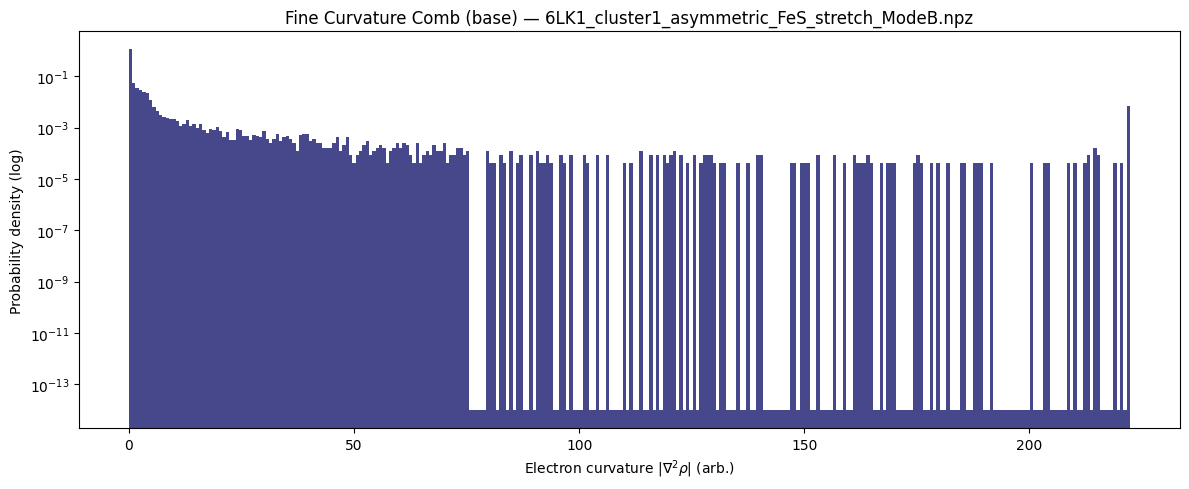

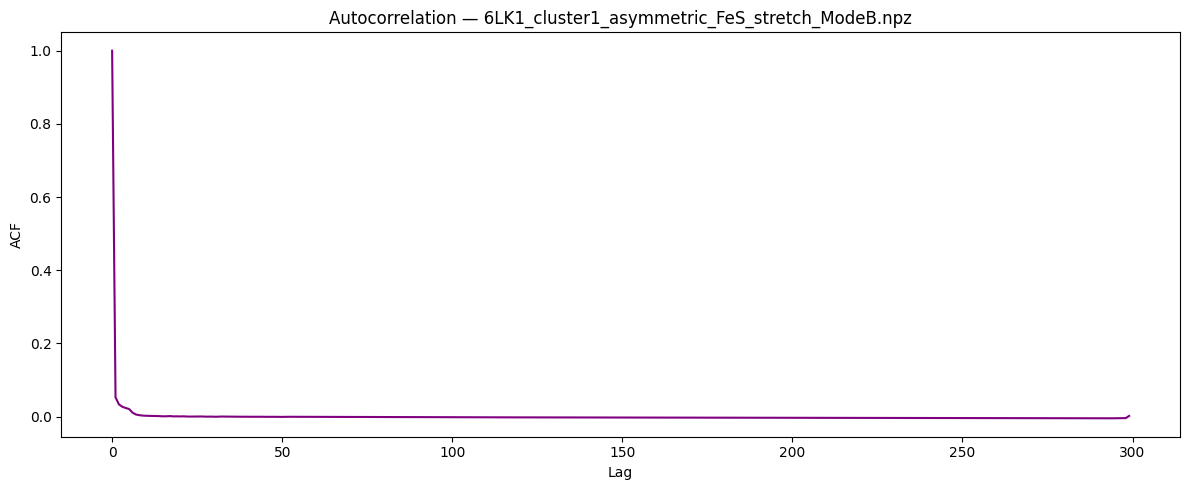

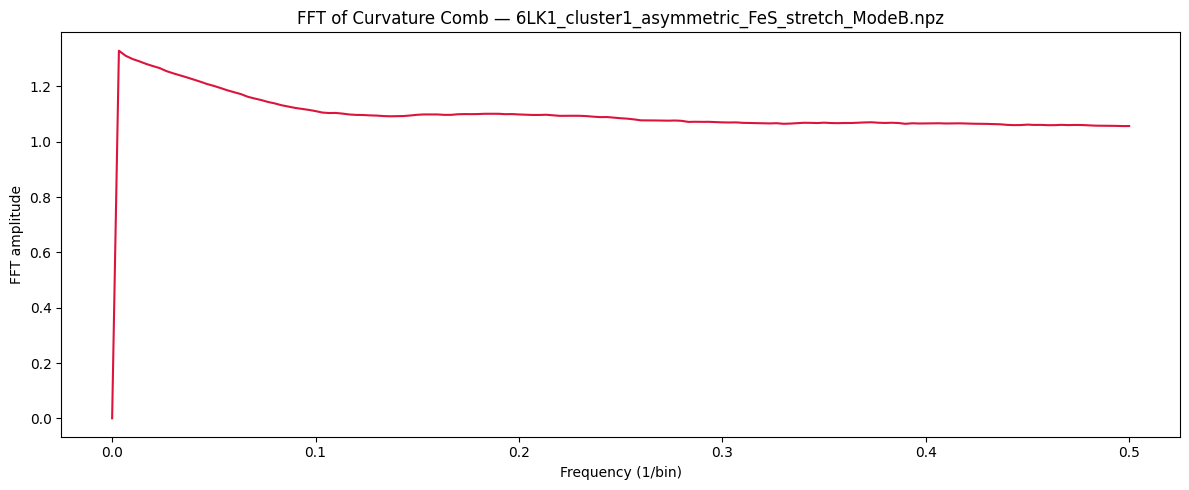

Dominant comb frequency: 0.0033333333333333335
Approx trough spacing (bins): 300.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from numpy.fft import rfft, rfftfreq

filename = "6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz"
data = np.load(filename)

kappa = data["kappa_base"]
mode_name = data.get("mode_name", "unknown")
cluster_id = data.get("cluster_idx", -1)
cif_path = data.get("cif_path", "unknown")

if isinstance(mode_name, np.ndarray): mode_name = mode_name.item()
if isinstance(cluster_id, np.ndarray): cluster_id = int(cluster_id.item())
if isinstance(cif_path, np.ndarray): cif_path = cif_path.item()

print("Loaded:", filename)
print("CIF:", cif_path, "cluster:", cluster_id)
print("n κ points:", kappa.size)

def fine_hist(kappa, bins=300):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    counts = np.maximum(counts, 1e-14)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, counts, edges

bins = 300
centers, counts, edges = fine_hist(kappa, bins=bins)

plt.figure(figsize=(12,5))
plt.bar(centers, counts, width=(edges[1]-edges[0]), color="midnightblue", alpha=0.8)
plt.yscale("log")
plt.title(f"Fine Curvature Comb (base) — {filename}")
plt.xlabel(r"Electron curvature $|\nabla^2 \rho|$ (arb.)")
plt.ylabel("Probability density (log)")
plt.tight_layout()
plt.show()

def autocorr(counts):
    c = counts - np.mean(counts)
    a = correlate(c, c, mode="full")
    mid = len(a)//2
    return np.arange(len(counts)), a[mid:mid+len(counts)]

lags, auto = autocorr(counts)

plt.figure(figsize=(12,5))
plt.plot(lags, auto/auto.max(), color="purple")
plt.title(f"Autocorrelation — {filename}")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()
plt.show()

freqs = rfftfreq(len(counts), d=1.0)
fft_vals = np.abs(rfft(counts - np.mean(counts)))

plt.figure(figsize=(12,5))
plt.plot(freqs, fft_vals, color="crimson")
plt.title(f"FFT of Curvature Comb — {filename}")
plt.xlabel("Frequency (1/bin)")
plt.ylabel("FFT amplitude")
plt.tight_layout()
plt.show()

freqs_nz = freqs[1:]
fft_nz = fft_vals[1:]
if fft_nz.size > 0:
    dom_freq = freqs_nz[np.argmax(fft_nz)]
    spacing = 1/dom_freq if dom_freq!=0 else np.nan
else:
    dom_freq = 0.0
    spacing = np.nan

print("Dominant comb frequency:", dom_freq)
print("Approx trough spacing (bins):", spacing)

Loaded control from: 6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz
CIF: 6LK1.cif cluster: 1
n κ points: 32768


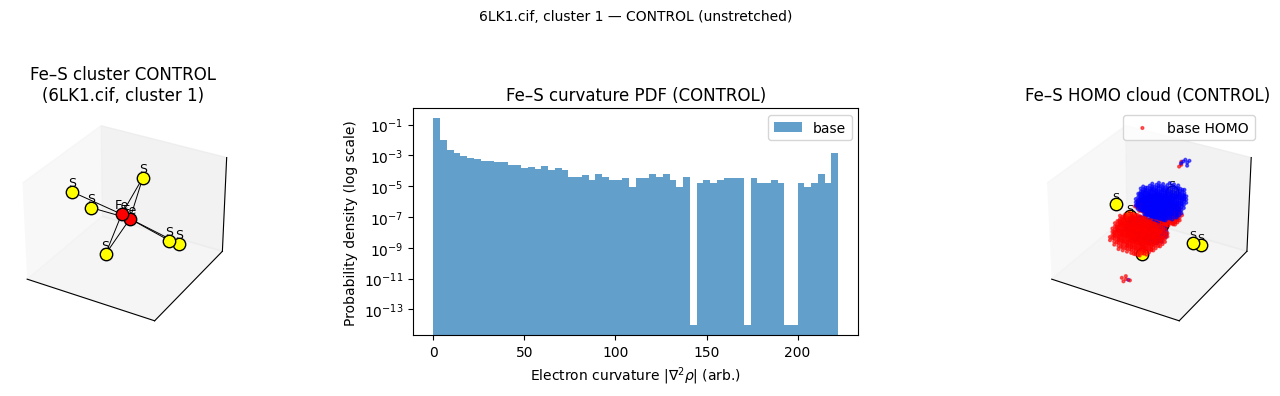

Saved CONTROL PNG: 6LK1_cluster1_asymmetric_FeS_stretch_ModeB_CONTROL.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# change this to cluster 1 or 5 NPZ
filename = "6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz"
data = np.load(filename)

kappa_base         = data["kappa_base"]
symbols            = data["symbols"]
coords_base        = data["coords_base"]
coords_cloud_base  = data["coords_cloud_base"]
psi_cloud_base     = data["psi_cloud_base"]

cif_path   = data.get("cif_path", "unknown")
cluster_id = data.get("cluster_idx", -1)

if isinstance(cif_path, np.ndarray):   cif_path   = cif_path.item()
if isinstance(cluster_id, np.ndarray): cluster_id = int(cluster_id.item())

print("Loaded control from:", filename)
print("CIF:", cif_path, "cluster:", cluster_id)
print("n κ points:", kappa_base.size)

counts, edges = np.histogram(kappa_base, bins=60, density=True)
counts = np.maximum(counts, 1e-14)
centers = 0.5*(edges[:-1] + edges[1:])

fig = plt.figure(figsize=(15,4))

# (a) geometry
ax1 = fig.add_subplot(1,3,1, projection="3d")
color_atoms = {"Fe": "red", "S": "yellow"}
for (x,y,z), sym in zip(coords_base, symbols):
    ax1.scatter(x,y,z, s=80, color=color_atoms.get(sym,"grey"), edgecolors="k")
    ax1.text(x,y,z+0.3, sym, ha="center", fontsize=9)
for i in range(len(coords_base)):
    for j in range(i+1, len(coords_base)):
        d = np.linalg.norm(coords_base[i]-coords_base[j])
        if d < 3.0:
            ax1.plot([coords_base[i,0], coords_base[j,0]],
                     [coords_base[i,1], coords_base[j,1]],
                     [coords_base[i,2], coords_base[j,2]],
                     color="k", linewidth=0.7)
ax1.set_title(f"Fe–S cluster CONTROL\n({os.path.basename(cif_path)}, cluster {cluster_id})")
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])
max_range = (coords_base.max(axis=0) - coords_base.min(axis=0)).max()
mid = coords_base.mean(axis=0)
for setter, m in zip([ax1.set_xlim, ax1.set_ylim, ax1.set_zlim], mid):
    setter(m-max_range/2, m+max_range/2)

# (b) curvature comb (base only)
ax2 = fig.add_subplot(1,3,2)
ax2.bar(centers, counts, width=(edges[1]-edges[0]),
        color="tab:blue", alpha=0.7, label="base")
ax2.set_yscale("log")
ax2.set_xlabel(r"Electron curvature $|\nabla^2 \rho|$ (arb.)")
ax2.set_ylabel("Probability density (log scale)")
ax2.set_title("Fe–S curvature PDF (CONTROL)")
ax2.legend()

# (c) HOMO cloud (base only)
ax3 = fig.add_subplot(1,3,3, projection="3d")
cols = np.where(psi_cloud_base>=0, "blue", "red")
ax3.scatter(coords_cloud_base[:,0],
            coords_cloud_base[:,1],
            coords_cloud_base[:,2],
            s=4, c=cols, alpha=0.6, label="base HOMO")
for (x,y,z), sym in zip(coords_base, symbols):
    ax3.scatter(x,y,z, s=80, color=color_atoms.get(sym,"grey"), edgecolors="k")
    ax3.text(x,y,z+0.3, sym, ha="center", fontsize=8)
ax3.set_title("Fe–S HOMO cloud (CONTROL)")
ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])

all_cloud = np.vstack([coords_cloud_base])
cloud_range = (all_cloud.max(axis=0) - all_cloud.min(axis=0)).max()
cloud_mid   = all_cloud.mean(axis=0)
for setter, m in zip([ax3.set_xlim, ax3.set_ylim, ax3.set_zlim], cloud_mid):
    setter(m-cloud_range/2, m+cloud_range/2)

ax3.legend(loc="upper right")

fig.suptitle(f"{cif_path}, cluster {cluster_id} — CONTROL (unstretched)", fontsize=10)
plt.tight_layout(rect=[0,0,1,0.95])

png_name = os.path.splitext(filename)[0] + "_CONTROL.png"
plt.savefig(png_name, dpi=600)
plt.show()
print("Saved CONTROL PNG:", png_name)

Loaded: 6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz
CIF: 6LK1.cif cluster: 1
Mode: asymmetric_FeS_stretch_ModeB amp: 0.2
n_base: 32768  n_mode: 32750

Histogram / trough analysis:


case  n_troughs  mean_trough_width   max_kappa  \
0                          base          1          13.338814  222.313562   
1  asymmetric_FeS_stretch_ModeB          2          10.761164  195.657531   

   compression_%  
0       0.000000  
1     -11.990286

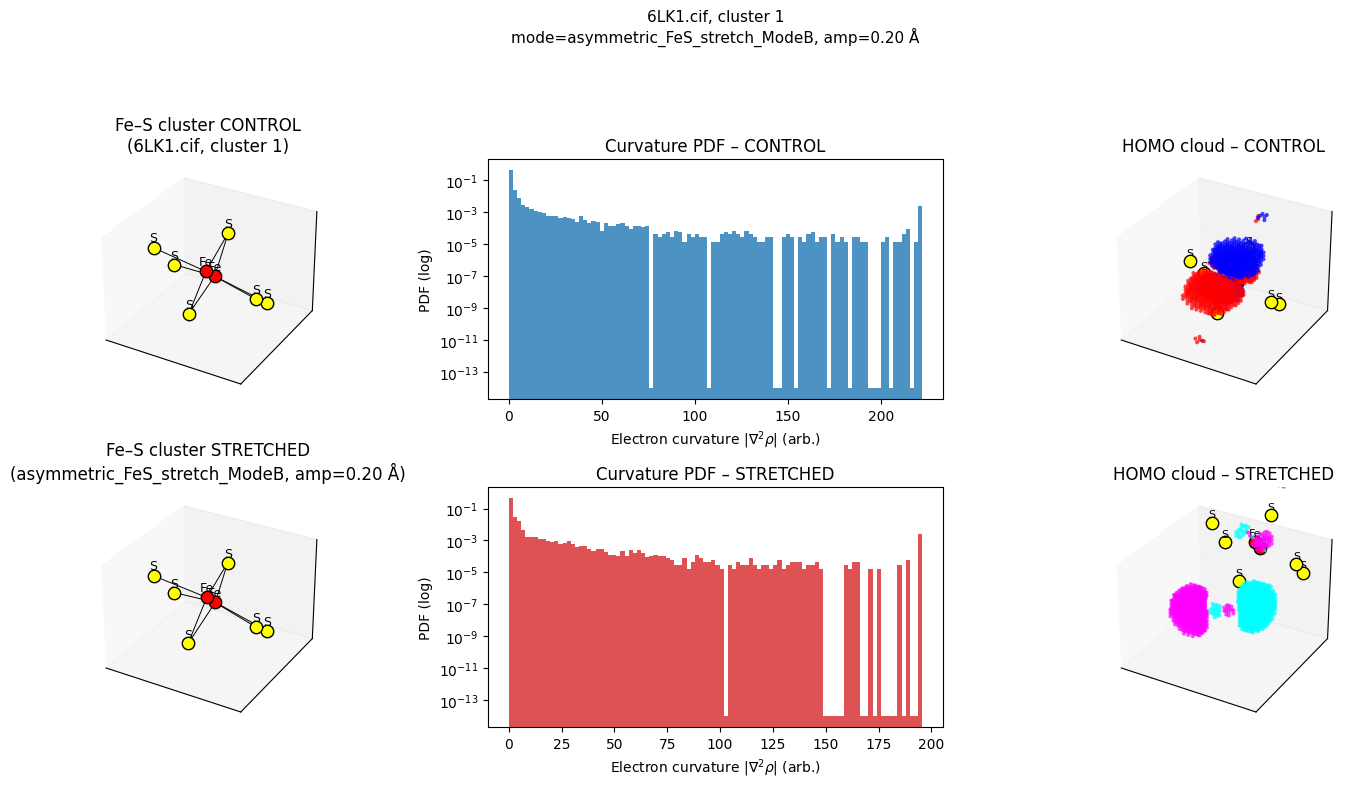

Saved composite PNG: 6LK1_cluster1_asymmetric_FeS_stretch_ModeB_CTRL_vs_STRETCH.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import os

filename = "6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz"
data = np.load(filename)

kappa_base         = data["kappa_base"]
kappa_mode         = data["kappa_mode"]
symbols            = data["symbols"]
coords_base        = data["coords_base"]
coords_mode        = data["coords_mode"]
coords_cloud_base  = data["coords_cloud_base"]
psi_cloud_base     = data["psi_cloud_base"]
coords_cloud_mode  = data["coords_cloud_mode"]
psi_cloud_mode     = data["psi_cloud_mode"]

cif_path   = data.get("cif_path", "unknown")
cluster_id = data.get("cluster_idx", -1)
mode_name  = data.get("mode_name", "mode")
amp        = data.get("amp", 0.0)

if isinstance(cif_path, np.ndarray):   cif_path   = cif_path.item()
if isinstance(cluster_id, np.ndarray): cluster_id = int(cluster_id.item())
if isinstance(mode_name, np.ndarray):  mode_name  = mode_name.item()
if isinstance(amp, np.ndarray):        amp        = float(amp.item())

print("Loaded:", filename)
print("CIF:", cif_path, "cluster:", cluster_id)
print("Mode:", mode_name, "amp:", amp)
print("n_base:", kappa_base.size, " n_mode:", kappa_mode.size)

def hist_stats(kappa, bins=80):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    counts = np.maximum(counts, 1e-14)
    centers = 0.5*(edges[:-1]+edges[1:])
    return centers, counts, edges

def smooth_counts(counts, window=5):
    kern = np.ones(window)/window
    return np.convolve(counts, kern, mode="same")

def trough_analysis(centers, counts, depth_factor=0.3, min_bins=3):
    cs = smooth_counts(counts, window=5)
    cmin = cs.min()
    cmed = np.median(cs)
    thr = cmin + depth_factor*(cmed - cmin)
    low = cs < thr
    trough_count = 0
    widths = []
    i = 0
    while i < len(low):
        if low[i]:
            start = i
            while i < len(low) and low[i]:
                i += 1
            end = i-1
            if (end-start+1) >= min_bins:
                trough_count += 1
                widths.append(centers[end]-centers[start])
        else:
            i += 1
    mean_w = np.mean(widths) if widths else 0.0
    return trough_count, mean_w, widths

cent_b, cnt_b, edg_b = hist_stats(kappa_base, bins=100)
cent_m, cnt_m, edg_m = hist_stats(kappa_mode, bins=100)

n_tb, mw_tb, widths_b = trough_analysis(cent_b, cnt_b, depth_factor=0.3, min_bins=3)
n_tm, mw_tm, widths_m = trough_analysis(cent_m, cnt_m, depth_factor=0.3, min_bins=3)

max_b = kappa_base.max() if kappa_base.size else 0.0
max_m = kappa_mode.max() if kappa_mode.size else 0.0
compression = ((max_m-max_b)/max_b*100.0) if max_b>0 else 0.0

table = pd.DataFrame({
    "case": ["base", mode_name],
    "n_troughs": [n_tb, n_tm],
    "mean_trough_width": [mw_tb, mw_tm],
    "max_kappa": [max_b, max_m],
    "compression_%": [0.0, compression],
})

print("\nHistogram / trough analysis:")
display(table)

fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(2,3,1, projection="3d")
color_atoms = {"Fe": "red", "S": "yellow"}
for (x,y,z), sym in zip(coords_base, symbols):
    ax1.scatter(x,y,z, s=80, color=color_atoms.get(sym,"grey"), edgecolors="k")
    ax1.text(x,y,z+0.3, sym, ha="center", fontsize=9)
for i in range(len(coords_base)):
    for j in range(i+1, len(coords_base)):
        d = np.linalg.norm(coords_base[i]-coords_base[j])
        if d < 3.0:
            ax1.plot([coords_base[i,0], coords_base[j,0]],
                     [coords_base[i,1], coords_base[j,1]],
                     [coords_base[i,2], coords_base[j,2]],
                     color="k", linewidth=0.7)
ax1.set_title(f"Fe–S cluster CONTROL\n({os.path.basename(cif_path)}, cluster {cluster_id})")
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])
mr = (coords_base.max(axis=0)-coords_base.min(axis=0)).max()
mid = coords_base.mean(axis=0)
for setter,m in zip([ax1.set_xlim,ax1.set_ylim,ax1.set_zlim], mid):
    setter(m-mr/2, m+mr/2)

ax2 = fig.add_subplot(2,3,2)
ax2.bar(cent_b, cnt_b, width=(edg_b[1]-edg_b[0]),
        color="tab:blue", alpha=0.8)
ax2.set_yscale("log")
ax2.set_xlabel(r"Electron curvature $|\nabla^2 \rho|$ (arb.)")
ax2.set_ylabel("PDF (log)")
ax2.set_title("Curvature PDF – CONTROL")

ax3 = fig.add_subplot(2,3,3, projection="3d")
cols_b = np.where(psi_cloud_base>=0, "blue", "red")
ax3.scatter(coords_cloud_base[:,0],
            coords_cloud_base[:,1],
            coords_cloud_base[:,2],
            s=4, c=cols_b, alpha=0.6)
for (x,y,z), sym in zip(coords_base, symbols):
    ax3.scatter(x,y,z, s=80, color=color_atoms.get(sym,"grey"), edgecolors="k")
    ax3.text(x,y,z+0.3, sym, ha="center", fontsize=8)
ax3.set_title("HOMO cloud – CONTROL")
ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
all_cb = coords_cloud_base
rr = (all_cb.max(axis=0)-all_cb.min(axis=0)).max()
mb = all_cb.mean(axis=0)
for setter,m in zip([ax3.set_xlim,ax3.set_ylim,ax3.set_zlim], mb):
    setter(m-rr/2, m+rr/2)

ax4 = fig.add_subplot(2,3,4, projection="3d")
for (x,y,z), sym in zip(coords_mode, symbols):
    ax4.scatter(x,y,z, s=80, color=color_atoms.get(sym,"grey"), edgecolors="k")
    ax4.text(x,y,z+0.3, sym, ha="center", fontsize=9)
for i in range(len(coords_mode)):
    for j in range(i+1, len(coords_mode)):
        d = np.linalg.norm(coords_mode[i]-coords_mode[j])
        if d < 3.0:
            ax4.plot([coords_mode[i,0], coords_mode[j,0]],
                     [coords_mode[i,1], coords_mode[j,1]],
                     [coords_mode[i,2], coords_mode[j,2]],
                     color="k", linewidth=0.7)
ax4.set_title(f"Fe–S cluster STRETCHED\n({mode_name}, amp={amp:.2f} Å)")
ax4.set_xticks([]); ax4.set_yticks([]); ax4.set_zticks([])
mr2 = (coords_mode.max(axis=0)-coords_mode.min(axis=0)).max()
mid2 = coords_mode.mean(axis=0)
for setter,m in zip([ax4.set_xlim,ax4.set_ylim,ax4.set_zlim], mid2):
    setter(m-mr2/2, m+mr2/2)

ax5 = fig.add_subplot(2,3,5)
ax5.bar(cent_m, cnt_m, width=(edg_m[1]-edg_m[0]),
        color="tab:red", alpha=0.8)
ax5.set_yscale("log")
ax5.set_xlabel(r"Electron curvature $|\nabla^2 \rho|$ (arb.)")
ax5.set_ylabel("PDF (log)")
ax5.set_title("Curvature PDF – STRETCHED")

ax6 = fig.add_subplot(2,3,6, projection="3d")
cols_m = np.where(psi_cloud_mode>=0, "cyan", "magenta")
ax6.scatter(coords_cloud_mode[:,0],
            coords_cloud_mode[:,1],
            coords_cloud_mode[:,2],
            s=4, c=cols_m, alpha=0.6)
for (x,y,z), sym in zip(coords_mode, symbols):
    ax6.scatter(x,y,z, s=80, color=color_atoms.get(sym,"grey"), edgecolors="k")
    ax6.text(x,y,z+0.3, sym, ha="center", fontsize=8)
ax6.set_title("HOMO cloud – STRETCHED")
ax6.set_xticks([]); ax6.set_yticks([]); ax6.set_zticks([])
all_cm = coords_cloud_mode
rr2 = (all_cm.max(axis=0)-all_cm.min(axis=0)).max()
mb2 = all_cm.mean(axis=0)
for setter,m in zip([ax6.set_xlim,ax6.set_ylim,ax6.set_zlim], mb2):
    setter(m-rr2/2, m+rr2/2)

fig.suptitle(f"{cif_path}, cluster {cluster_id}\nmode={mode_name}, amp={amp:.2f} Å", fontsize=11)
plt.tight_layout(rect=[0,0,1,0.93])

png_name = os.path.splitext(filename)[0] + "_CTRL_vs_STRETCH.png"
plt.savefig(png_name, dpi=600)
plt.show()
print("Saved composite PNG:", png_name)

In [ ]:
import numpy as np
import pandas as pd

# change to cluster 1 OR cluster 5 npz
filename = "6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz"
data = np.load(filename)

kappa_base = data["kappa_base"]
kappa_mode = data["kappa_mode"]

print("Loaded:", filename)
print("n_base:", kappa_base.size, " n_mode:", kappa_mode.size)

def hist_stats(kappa, bins):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    counts = np.maximum(counts, 1e-14)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, counts, edges

def smooth_counts(counts, window=5):
    kern = np.ones(window)/window
    return np.convolve(counts, kern, mode="same")

def trough_analysis(centers, counts, depth_factor=0.3, min_bins=3):
    cs = smooth_counts(counts, window=5)
    cmin = cs.min()
    cmed = np.median(cs)
    thr = cmin + depth_factor*(cmed - cmin)
    low = cs < thr
    trough_count = 0
    widths = []
    i = 0
    while i < len(low):
        if low[i]:
            start = i
            while i < len(low) and low[i]:
                i += 1
            end = i-1
            if (end-start+1) >= min_bins:
                trough_count += 1
                widths.append(centers[end]-centers[start])
        else:
            i += 1
    mean_w = np.mean(widths) if widths else 0.0
    return trough_count, mean_w

bins_list = [40, 60, 80, 100, 120, 150, 200]

rows = []
for bins in bins_list:
    cb, fb, eb = hist_stats(kappa_base, bins)
    cm, fm, em = hist_stats(kappa_mode, bins)
    n_tb, mw_tb = trough_analysis(cb, fb, depth_factor=0.3, min_bins=3)
    n_tm, mw_tm = trough_analysis(cm, fm, depth_factor=0.3, min_bins=3)

    delta_troughs = n_tm - n_tb
    delta_width  = mw_tm - mw_tb

    # crude "trap-change score": both number and width matter
    score = abs(delta_troughs) + abs(delta_width)/(eb[-1]-eb[0]) * bins

    rows.append({
        "bins": bins,
        "n_troughs_base": n_tb,
        "n_troughs_mode": n_tm,
        "Δtroughs": delta_troughs,
        "mean_width_base": mw_tb,
        "mean_width_mode": mw_tm,
        "Δwidth": delta_width,
        "trap_change_score": score
    })

table = pd.DataFrame(rows)
table = table.sort_values("bins")
display(table)

best = table.loc[table["trap_change_score"].idxmax()]
print("\nMost sensitive bin count (by this metric):")
print(best)

Loaded: 6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz
n_base: 32768  n_mode: 32750


bins  n_troughs_base  n_troughs_mode  Δtroughs  mean_width_base  \
0    40               1               1         0        22.231356   
1    60               1               1         0        14.820904   
2    80               1               2         1        16.673517   
3   100               1               2         1        13.338814   
4   120               1               2         1        16.673517   
5   150               1               2         1         5.928362   
6   200               3               2        -1         4.816794   

   mean_width_mode     Δwidth  trap_change_score  
0        34.240067  12.008711           2.160680  
1        35.870547  21.049643           5.681068  
2        11.005736  -5.667781           3.039563  
3        10.761164  -2.577650           2.159466  
4        11.413356  -5.260161           3.839320  
5        11.739452   5.811090           4.920874  
6        13.696027   8.879233           8.988027


Most sensitive bin count (by this metric):
bins                 200.000000
n_troughs_base         3.000000
n_troughs_mode         2.000000
Δtroughs              -1.000000
mean_width_base        4.816794
mean_width_mode       13.696027
Δwidth                 8.879233
trap_change_score      8.988027
Name: 6, dtype: float64


In [ ]:
def count_teeth_by_threshold(centers, counts, threshold=1e-9):
    """
    Counts 'teeth' = bins where PDF < threshold.
    Returns:
      n_teeth   – number of distinct dips
      widths    – list of widths in κ units
      binsizes  – list of widths in # of bins
    """
    low = counts < threshold

    n_teeth = 0
    widths = []
    binsizes = []

    i = 0
    while i < len(low):
        if low[i]:
            start = i
            while i < len(low) and low[i]:
                i += 1
            end = i - 1

            n_teeth += 1
            widths.append(centers[end] - centers[start])
            binsizes.append(end - start + 1)
        else:
            i += 1

    return n_teeth, widths, binsizes

In [ ]:
import numpy as np
import pandas as pd

filename = "6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz"
data = np.load(filename)

kappa_base = data["kappa_base"]
kappa_mode = data["kappa_mode"]

print("Loaded:", filename)
print("n_base:", kappa_base.size, " n_mode:", kappa_mode.size)

def hist_stats(kappa, bins):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    counts = np.maximum(counts, 1e-14)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, counts, edges

def count_teeth_by_threshold(centers, counts, threshold=1e-9):
    low = counts < threshold
    n_teeth = 0
    widths = []
    binsizes = []
    i = 0
    while i < len(low):
        if low[i]:
            start = i
            while i < len(low) and low[i]:
                i += 1
            end = i - 1
            n_teeth += 1
            widths.append(centers[end] - centers[start])
            binsizes.append(end - start + 1)
        else:
            i += 1
    mean_w = np.mean(widths) if widths else 0.0
    return n_teeth, mean_w, widths, binsizes

bins_list = [40, 60, 80, 100, 120, 150, 200]

rows = []
for bins in bins_list:
    cb, fb, eb = hist_stats(kappa_base, bins)
    cm, fm, em = hist_stats(kappa_mode, bins)

    n_tb, mw_tb, wtb, btb = count_teeth_by_threshold(cb, fb, threshold=1e-9)
    n_tm, mw_tm, wtm, btm = count_teeth_by_threshold(cm, fm, threshold=1e-9)

    delta_teeth = n_tm - n_tb
    delta_width = mw_tm - mw_tb

    score = abs(delta_teeth) + abs(delta_width)/(eb[-1]-eb[0]) * bins

    rows.append({
        "bins": bins,
        "n_teeth_base": n_tb,
        "n_teeth_mode": n_tm,
        "Δteeth": delta_teeth,
        "mean_tooth_width_base": mw_tb,
        "mean_tooth_width_mode": mw_tm,
        "Δwidth": delta_width,
        "trap_change_score": score
    })

table = pd.DataFrame(rows).sort_values("bins")
display(table)

best = table.loc[table["trap_change_score"].idxmax()]
print("\nMost sensitive bin count (by this metric):")
print(best)

Loaded: 6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz
n_base: 32768  n_mode: 32750


bins  n_teeth_base  n_teeth_mode  Δteeth  mean_tooth_width_base  \
0    40             1             2       1               0.000000   
1    60             3             4       1               1.235075   
2    80             3             7       4               1.852613   
3   100             9             7      -2               0.741045   
4   120            14            10      -4               0.926306   
5   150            21            13      -8               0.776333   
6   200            30            19     -11               0.815150   

   mean_tooth_width_mode    Δwidth  trap_change_score  
0               0.000000  0.000000           1.000000  
1               1.630479  0.395404           1.106715  
2               1.746942 -0.105671           4.038026  
3               2.515597  1.774552           2.798220  
4               2.119623  1.193317           4.644126  
5               1.906407  1.130074           8.762486  
6               1.544665  0.729515          11.656294


Most sensitive bin count (by this metric):
bins                     200.000000
n_teeth_base              30.000000
n_teeth_mode              19.000000
Δteeth                   -11.000000
mean_tooth_width_base      0.815150
mean_tooth_width_mode      1.544665
Δwidth                     0.729515
trap_change_score         11.656294
Name: 6, dtype: float64


In [ ]:
import numpy as np
import pandas as pd

filename = "6LK1_cluster5_asymmetric_FeS_stretch_ModeB.npz"
data = np.load(filename)

kappa_base = data["kappa_base"]
kappa_mode = data["kappa_mode"]

print("Loaded:", filename)
print("n_base:", kappa_base.size, " n_mode:", kappa_mode.size)

def hist_stats(kappa, bins):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    counts = np.maximum(counts, 1e-14)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, counts, edges

def count_teeth_by_threshold(centers, counts, threshold=1e-9):
    low = counts < threshold
    n_teeth = 0
    widths = []
    binsizes = []
    i = 0
    while i < len(low):
        if low[i]:
            start = i
            while i < len(low) and low[i]:
                i += 1
            end = i - 1
            n_teeth += 1
            widths.append(centers[end] - centers[start])
            binsizes.append(end - start + 1)
        else:
            i += 1
    mean_w = np.mean(widths) if widths else 0.0
    return n_teeth, mean_w, widths, binsizes

bins_list = bins = [
    1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,
    20,21,22,23,24,25,26,27,28,29,
    30,31,32,33,34,35,36,37,38,39,
    40,41,42,43,44,45,46,47,48,49,
    50,51,52,53,54,55,56,57,58,59,
    60,65,70,71,73,75,77,78,79,80,
    81,82,83,84,85,87,88,89,90,
    91,92,93,94,95,96,97,98,99,100,
    102,103,105,106,107,109,
    110,111,112,113,114,115,116,117,118,119,120,
    121,122,123,124,125
]
rows = []
for bins in bins_list:
    cb, fb, eb = hist_stats(kappa_base, bins)
    cm, fm, em = hist_stats(kappa_mode, bins)

    n_tb, mw_tb, wtb, btb = count_teeth_by_threshold(cb, fb, threshold=1e-9)
    n_tm, mw_tm, wtm, btm = count_teeth_by_threshold(cm, fm, threshold=1e-9)

    delta_teeth = n_tm - n_tb
    delta_width = mw_tm - mw_tb

    score = abs(delta_teeth) + abs(delta_width)/(eb[-1]-eb[0]) * bins

    rows.append({
        "bins": bins,
        "n_teeth_base": n_tb,
        "n_teeth_mode": n_tm,
        "Δteeth": delta_teeth,
        "mean_tooth_width_base": mw_tb,
        "mean_tooth_width_mode": mw_tm,
        "Δwidth": delta_width,
        "trap_change_score": score
    })

table = pd.DataFrame(rows).sort_values("bins")
display(table)

best_local = table.loc[table["trap_change_score"].idxmax()]
print("\nMost sensitive bin count in [60,120]:")
print(best_local)

Loaded: 6LK1_cluster5_asymmetric_FeS_stretch_ModeB.npz
n_base: 32768  n_mode: 32768


bins  n_teeth_base  n_teeth_mode  Δteeth  mean_tooth_width_base  \
0       1             0             0       0               0.000000   
1       3             0             0       0               0.000000   
2       5             0             0       0               0.000000   
3       7             0             0       0               0.000000   
4       9             0             0       0               0.000000   
..    ...           ...           ...     ...                    ...   
101   121            13            13       0               0.652064   
102   122            15            12      -3               0.560490   
103   123            14            13      -1               0.714772   
104   124            14            12      -2               0.590839   
105   125            16            13      -3               0.512849   

     mean_tooth_width_mode    Δwidth  trap_change_score  
0                 0.000000  0.000000           0.000000  
1                 0.000000  0.000000           0.000000  
2                 0.000000  0.000000           0.000000  
3                 0.000000  0.000000           0.000000  
4                 0.000000  0.000000           0.000000  
..                     ...       ...                ...  
101               2.648372  1.996308           1.177507  
102               2.845553  2.285063           4.358966  
103               2.735575  2.020803           2.211657  
104               3.079623  2.488783           3.504387  
105               2.691805  2.178957           4.327729  

[106 rows x 8 columns]


Most sensitive bin count in [60,120]:
bins                     58.000000
n_teeth_base              1.000000
n_teeth_mode              7.000000
Δteeth                    6.000000
mean_tooth_width_base     0.000000
mean_tooth_width_mode     1.539122
Δwidth                    1.539122
trap_change_score         6.435163
Name: 53, dtype: float64


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['bins'].plot(kind='hist', bins=20, title='bins')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['n_teeth_base'].plot(kind='hist', bins=20, title='n_teeth_base')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['n_teeth_mode'].plot(kind='hist', bins=20, title='n_teeth_mode')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='bins', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='bins', y='n_teeth_base', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='n_teeth_base', y='n_teeth_mode', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='n_teeth_mode', y='Δteeth', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['n_teeth_base']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('n_teeth_base')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['n_teeth_mode']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('n_teeth_mode')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Δteeth']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Δteeth')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['mean_tooth_width_base']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('mean_tooth_width_base')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['bins'].plot(kind='line', figsize=(8, 4), title='bins')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['n_teeth_base'].plot(kind='line', figsize=(8, 4), title='n_teeth_base')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['n_teeth_mode'].plot(kind='line', figsize=(8, 4), title='n_teeth_mode')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
table.to_csv("cluster5_teeth_table.csv", index=False)

from google.colab import files
files.download("cluster5_teeth_table.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   bins  n_teeth_base  n_teeth_mode  Δteeth  mean_tooth_width_base  \
0     1             0             0       0                    0.0   
1     3             0             0       0                    0.0   
2     5             0             0       0                    0.0   
3     7             0             0       0                    0.0   
4     9             0             0       0                    0.0   

   mean_tooth_width_mode  Δwidth  trap_change_score  
0                    0.0     0.0                0.0  
1                    0.0     0.0                0.0  
2                    0.0     0.0                0.0  
3                    0.0     0.0                0.0  
4                    0.0     0.0                0.0  
     bins  n_teeth_base  n_teeth_mode  Δteeth  mean_tooth_width_base  \
101   121            13            13       0               0.652064   
102   122            15            12      -3               0.560490   
103   123            14            13  

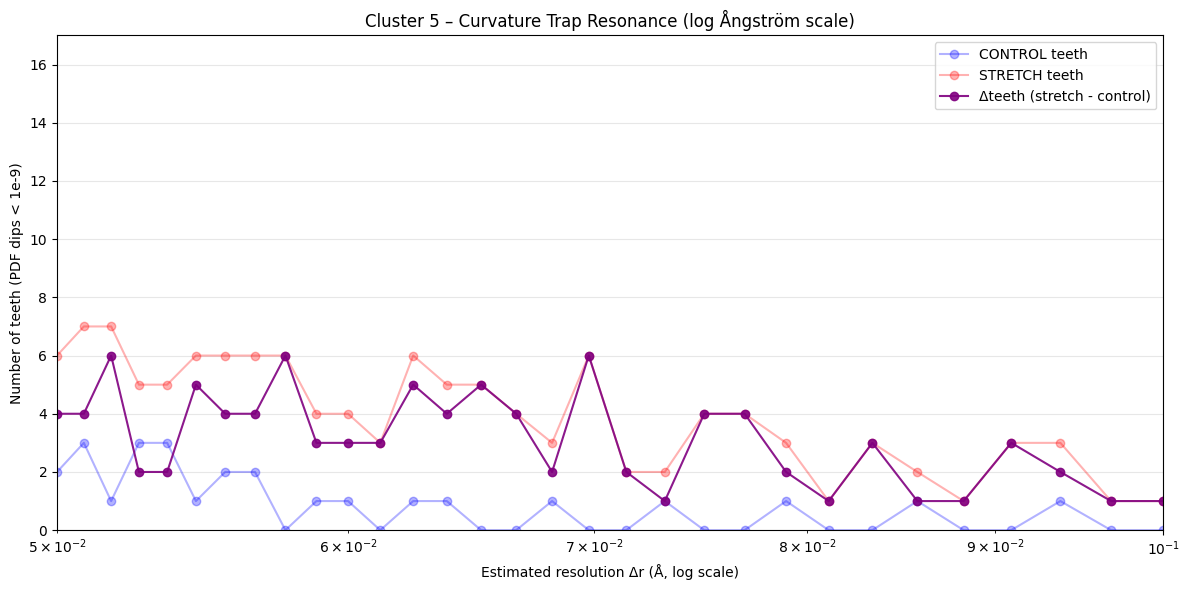

bins  Δr_est_A  n_teeth_base  n_teeth_mode  Δteeth
0       1  3.000000             0             0       0
1       3  1.000000             0             0       0
2       5  0.600000             0             0       0
3       7  0.428571             0             0       0
4       9  0.333333             0             0       0
..    ...       ...           ...           ...     ...
101   121  0.024793            13            13       0
102   122  0.024590            15            12      -3
103   123  0.024390            14            13      -1
104   124  0.024194            14            12      -2
105   125  0.024000            16            13      -3

[106 rows x 5 columns]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cluster 5 teeth table from CSV you saved
df5 = pd.read_csv("cluster5_teeth_table.csv")

# Basic sanity check
print(df5.head())
print(df5.tail())

# Δteeth is already in the CSV; if not, uncomment this:
# df5["Δteeth"] = df5["n_teeth_mode"] - df5["n_teeth_base"]

# Ångström mapping: Δr ≈ 3 Å / bins
L_eff = 3.0  # effective Fe–S ‘curvature span’ in Å
df5["Δr_est_A"] = L_eff / df5["bins"]

# Sort by resolution (bins) just in case
df5 = df5.sort_values("bins")


# MASTER PLOT: Δr (Å) on X (log scale), teeth on Y, y >= 0
plt.figure(figsize=(12,6))

# CONTROL and STRETCH faint
plt.plot(df5["Δr_est_A"], df5["n_teeth_base"],
         "-o", color="blue", alpha=0.3, label="CONTROL teeth")
plt.plot(df5["Δr_est_A"], df5["n_teeth_mode"],
         "-o", color="red",  alpha=0.3, label="STRETCH teeth")

# Δteeth strong
plt.plot(df5["Δr_est_A"], df5["Δteeth"],
         "-o", color="purple", alpha=0.9, label="Δteeth (stretch - control)")

plt.xscale("log")
plt.xlim(5e-2, 0.1)  # log-domain from 0.001 Å to 1 Å

plt.xlabel("Estimated resolution Δr (Å, log scale)")
plt.ylabel("Number of teeth (PDF dips < 1e-9)")
plt.ylim(bottom=0)
plt.title("Cluster 5 – Curvature Trap Resonance (log Ångström scale)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
# Master table with Angstrom column
display(df5[["bins", "Δr_est_A", "n_teeth_base", "n_teeth_mode", "Δteeth"]])

In [ ]:
import numpy as np
import pandas as pd

filename = "6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz"
data = np.load(filename)

kappa_base = data["kappa_base"]
kappa_mode = data["kappa_mode"]

print("Loaded:", filename)
print("n_base:", kappa_base.size, " n_mode:", kappa_mode.size)

# --- same analysis functions ---
def hist_stats(kappa, bins):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    counts = np.maximum(counts, 1e-14)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, counts, edges

def count_teeth_by_threshold(centers, counts, threshold=1e-9):
    low = counts < threshold
    n_teeth = 0
    widths = []
    binsizes = []
    i = 0
    while i < len(low):
        if low[i]:
            start = i
            while i < len(low) and low[i]:
                i += 1
            end = i - 1
            n_teeth += 1
            widths.append(centers[end] - centers[start])
            binsizes.append(end - start + 1)
        else:
            i += 1
    mean_w = np.mean(widths) if widths else 0.0
    return n_teeth, mean_w, widths, binsizes

# same bins_list used for cluster 5
bins_list = [
    1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,
    20,21,22,23,24,25,26,27,28,29,
    30,31,32,33,34,35,36,37,38,39,
    40,41,42,43,44,45,46,47,48,49,
    50,51,52,53,54,55,56,57,58,59,
    60,65,70,71,73,75,77,78,79,80,
    81,82,83,84,85,87,88,89,90,
    91,92,93,94,95,96,97,98,99,100,
    102,103,105,106,107,109,
    110,111,112,113,114,115,116,117,118,119,120,
    121,122,123,124,125
]

# compute rows
rows = []
for bins in bins_list:
    cb, fb, eb = hist_stats(kappa_base, bins)
    cm, fm, em = hist_stats(kappa_mode, bins)

    n_tb, mw_tb, wtb, btb = count_teeth_by_threshold(cb, fb, threshold=1e-9)
    n_tm, mw_tm, wtm, btm = count_teeth_by_threshold(cm, fm, threshold=1e-9)

    delta_teeth = n_tm - n_tb
    delta_width = mw_tm - mw_tb
    score = abs(delta_teeth) + abs(delta_width)/(eb[-1]-eb[0]) * bins

    rows.append({
        "bins": bins,
        "n_teeth_base": n_tb,
        "n_teeth_mode": n_tm,
        "Δteeth": delta_teeth,
        "mean_tooth_width_base": mw_tb,
        "mean_tooth_width_mode": mw_tm,
        "Δwidth": delta_width,
        "trap_change_score": score
    })

table1 = pd.DataFrame(rows).sort_values("bins")
display(table1)

# Save CSV
table1.to_csv("cluster1_teeth_table.csv", index=False)

from google.colab import files
files.download("cluster1_teeth_table.csv")

Loaded: 6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz
n_base: 32768  n_mode: 32750


bins  n_teeth_base  n_teeth_mode  Δteeth  mean_tooth_width_base  \
0       1             0             0       0               0.000000   
1       3             0             0       0               0.000000   
2       5             0             0       0               0.000000   
3       7             0             0       0               0.000000   
4       9             0             0       0               0.000000   
..    ...           ...           ...     ...                    ...   
101   121            14            12      -2               0.656179   
102   122            14             8      -6               0.650801   
103   123            13            11      -2               1.112263   
104   124            13            10      -3               0.965381   
105   125            13            11      -2               0.820850   

     mean_tooth_width_mode    Δwidth  trap_change_score  
0                 0.000000  0.000000           0.000000  
1                 0.000000  0.000000           0.000000  
2                 0.000000  0.000000           0.000000  
3                 0.000000  0.000000           0.000000  
4                 0.000000  0.000000           0.000000  
..                     ...       ...                ...  
101               1.886505  1.230326           2.669637  
102               2.806563  2.155762           7.183027  
103               1.879932  0.767669           2.424730  
104               1.893460  0.928078           3.517655  
105               1.992149  1.171299           2.658585  

[106 rows x 8 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

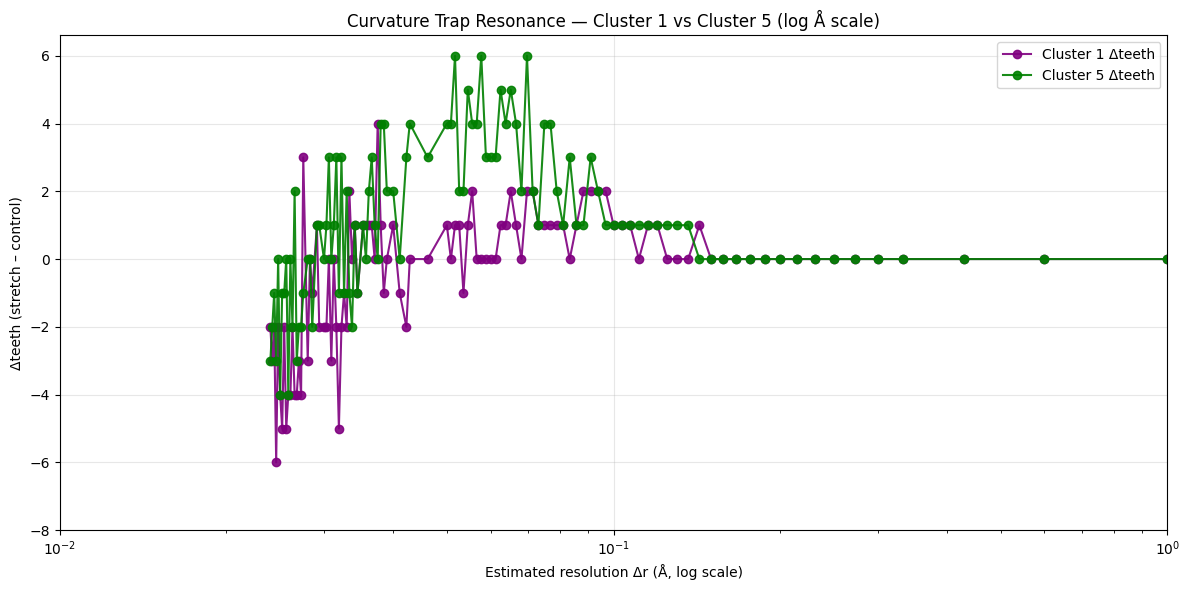

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the two tables you generated
df1 = pd.read_csv("cluster1_teeth_table.csv")
df5 = pd.read_csv("cluster5_teeth_table.csv")

# Angstrom mapping
L_eff = 3.0
df1["Δr_est_A"] = L_eff / df1["bins"]
df5["Δr_est_A"] = L_eff / df5["bins"]

# Sort by resolution
df1 = df1.sort_values("Δr_est_A")
df5 = df5.sort_values("Δr_est_A")

plt.figure(figsize=(12,6))

# Cluster 1: purple
plt.plot(df1["Δr_est_A"], df1["Δteeth"],
         "-o", color="purple", alpha=0.9, label="Cluster 1 Δteeth")

# Cluster 5: green
plt.plot(df5["Δr_est_A"], df5["Δteeth"],
         "-o", color="green", alpha=0.9, label="Cluster 5 Δteeth")

plt.xscale("log")
plt.xlim(1e-2, 1.0)      # 0.01–1 Å; tweak if you want tighter
plt.ylim(bottom=-8)

plt.xlabel("Estimated resolution Δr (Å, log scale)")
plt.ylabel("Δteeth (stretch – control)")
plt.title("Curvature Trap Resonance — Cluster 1 vs Cluster 5 (log Å scale)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

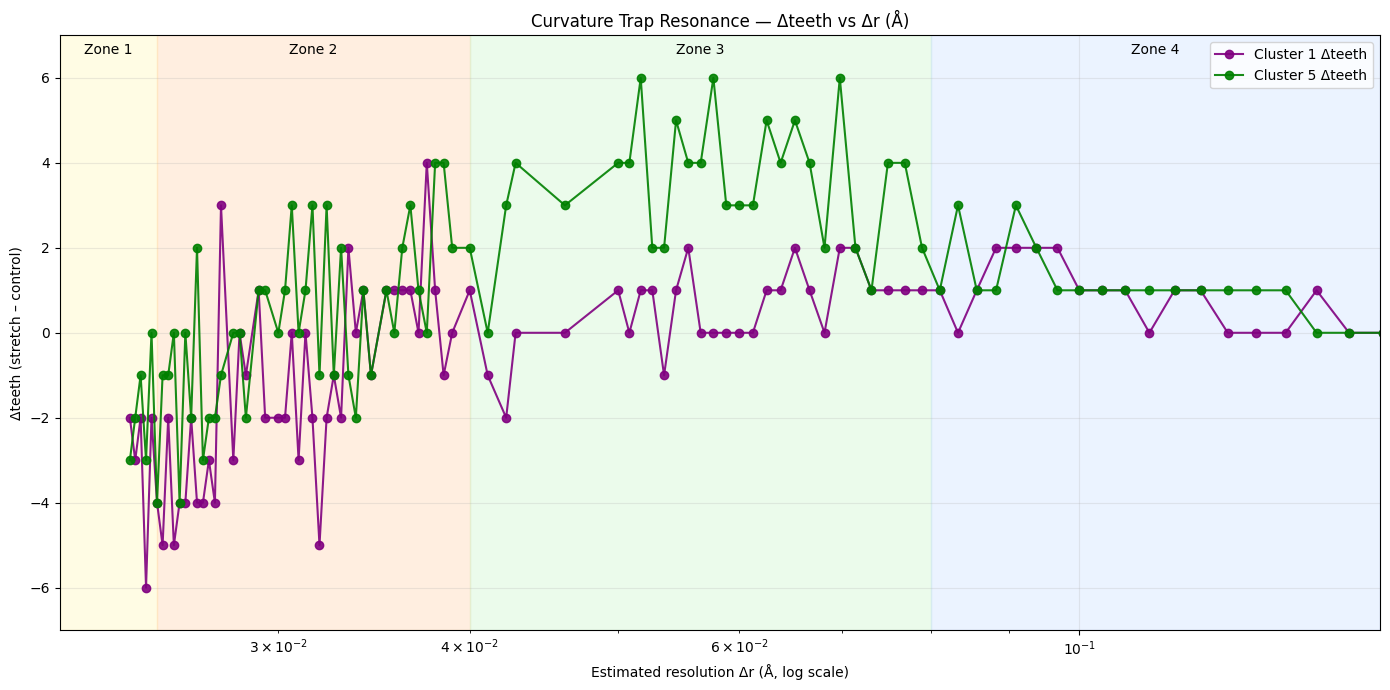

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the two tables
df1 = pd.read_csv("cluster1_teeth_table.csv")
df5 = pd.read_csv("cluster5_teeth_table.csv")

L_eff = 3.0
df1["Δr_est_A"] = L_eff / df1["bins"]
df5["Δr_est_A"] = L_eff / df5["bins"]

df1 = df1.sort_values("Δr_est_A")
df5 = df5.sort_values("Δr_est_A")

# --- determine data-driven x-limits: only where |Δteeth|>0 ---
mask1 = df1["Δteeth"].abs() > 0
mask5 = df5["Δteeth"].abs() > 0

xmin_data = min(df1.loc[mask1, "Δr_est_A"].min(),
                df5.loc[mask5, "Δr_est_A"].min())
xmax_data = max(df1.loc[mask1, "Δr_est_A"].max(),
                df5.loc[mask5, "Δr_est_A"].max())

x_min_plot = xmin_data * 0.9
x_max_plot = xmax_data * 1.1

# --- define generic zones (you can tweak the boundaries) ---
# 4 zones: quiet / onset / mixed / high-amplitude
edges = [x_min_plot, 0.025, 0.040, 0.080, x_max_plot]
zone_labels = ["Zone 1", "Zone 2", "Zone 3", "Zone 4"]
zone_colors = ["#fff7b2", "#ffd1a8", "#c8f5c8", "#c7ddff"]  # bright, non-grey

plt.figure(figsize=(14,7))

# shaded zones
for (x0, x1, label, color) in zip(edges[:-1], edges[1:], zone_labels, zone_colors):
    plt.axvspan(x0, x1, color=color, alpha=0.35)
    xm = np.sqrt(x0 * x1)  # geometric mid for log scale
    plt.text(xm, 6.5, label, fontsize=10, ha="center", va="bottom")

# Δteeth curves
plt.plot(df1["Δr_est_A"], df1["Δteeth"],
         "-o", color="purple", alpha=0.9, label="Cluster 1 Δteeth")
plt.plot(df5["Δr_est_A"], df5["Δteeth"],
         "-o", color="green",  alpha=0.9, label="Cluster 5 Δteeth")

plt.xscale("log")
plt.xlim(x_min_plot, x_max_plot)
plt.ylim(-7, 7)

plt.xlabel("Estimated resolution Δr (Å, log scale)")
plt.ylabel("Δteeth (stretch – control)")
plt.title("Curvature Trap Resonance — Δteeth vs Δr (Å)")

plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

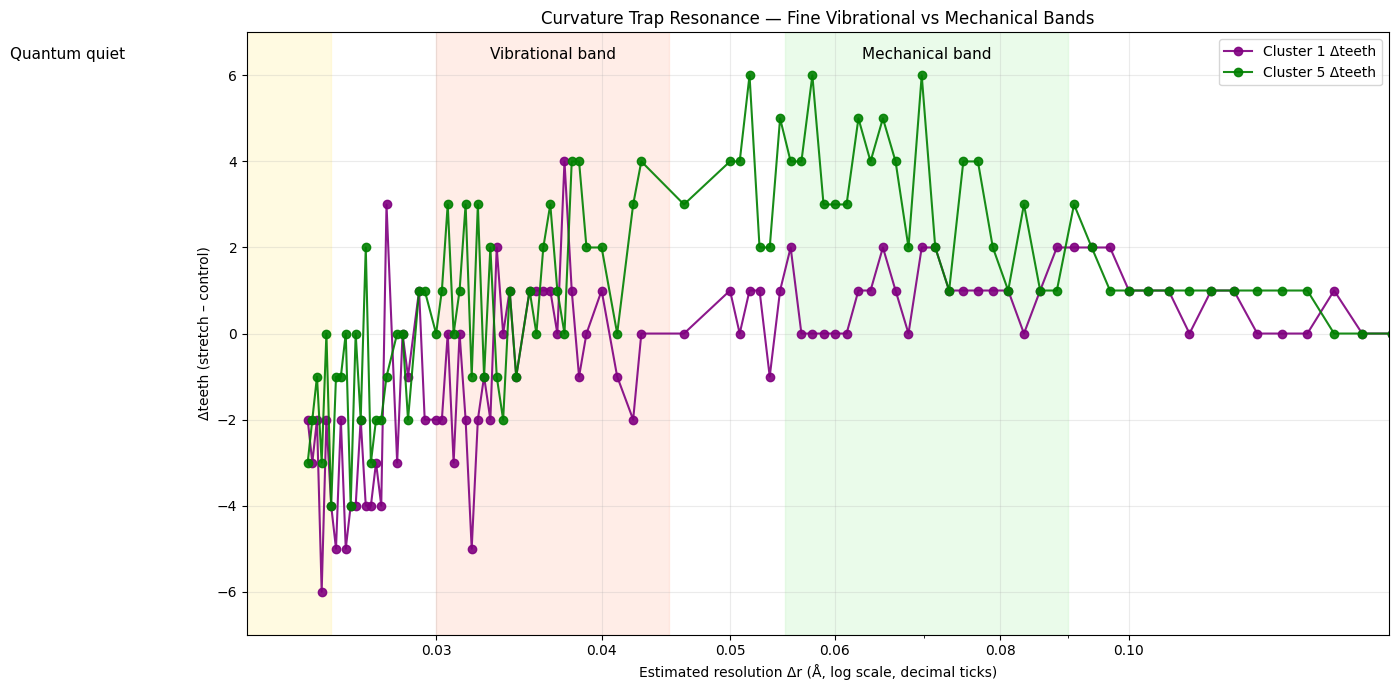

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load cluster 1 and 5 tables
df1 = pd.read_csv("cluster1_teeth_table.csv")
df5 = pd.read_csv("cluster5_teeth_table.csv")

# Angstrom mapping
L_eff = 3.0
df1["Δr_est_A"] = L_eff / df1["bins"]
df5["Δr_est_A"] = L_eff / df5["bins"]

df1 = df1.sort_values("Δr_est_A")
df5 = df5.sort_values("Δr_est_A")

# Determine real data limits
mask1 = df1["Δteeth"].abs() > 0
mask5 = df5["Δteeth"].abs() > 0

xmin_data = min(df1.loc[mask1, "Δr_est_A"].min(),
                df5.loc[mask5, "Δr_est_A"].min())
xmax_data = max(df1.loc[mask1, "Δr_est_A"].max(),
                df5.loc[mask5, "Δr_est_A"].max())

x_min_plot = xmin_data * 0.9
x_max_plot = xmax_data * 1.1

# --- Define REAL resonance bands ---
bands = {
    "Quantum quiet":     (0.010, 0.025, "#fff4b2"),
    "Vibrational band":  (0.030, 0.045, "#ffd1c0"),
    "Mechanical band":   (0.055, 0.090, "#c8f5c8"),
}

# --- Plot ---
plt.figure(figsize=(14,7))

# Draw bands
for label, (x0, x1, color) in bands.items():
    plt.axvspan(x0, x1, color=color, alpha=0.38)
    xm = np.sqrt(x0 * x1)   # geometric mid for log scale
    plt.text(xm, 6.3, label, fontsize=11, ha="center", va="bottom")

# Δteeth curves
plt.plot(df1["Δr_est_A"], df1["Δteeth"], "-o",
         color="purple", alpha=0.9, label="Cluster 1 Δteeth")
plt.plot(df5["Δr_est_A"], df5["Δteeth"], "-o",
         color="green", alpha=0.9, label="Cluster 5 Δteeth")

plt.xscale("log")
plt.xlim(x_min_plot, x_max_plot)
plt.ylim(-7,7)

# ---- CUSTOM DECIMAL TICKS ----
tick_vals = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.10]
tick_vals = [v for v in tick_vals if x_min_plot<=v<=x_max_plot]

plt.xticks(tick_vals, [f"{v:.02f}" for v in tick_vals])

plt.xlabel("Estimated resolution Δr (Å, log scale, decimal ticks)")
plt.ylabel("Δteeth (stretch – control)")
plt.title("Curvature Trap Resonance — Fine Vibrational vs Mechanical Bands")
plt.grid(True, alpha=0.25)
plt.legend()

plt.tight_layout()
plt.show()

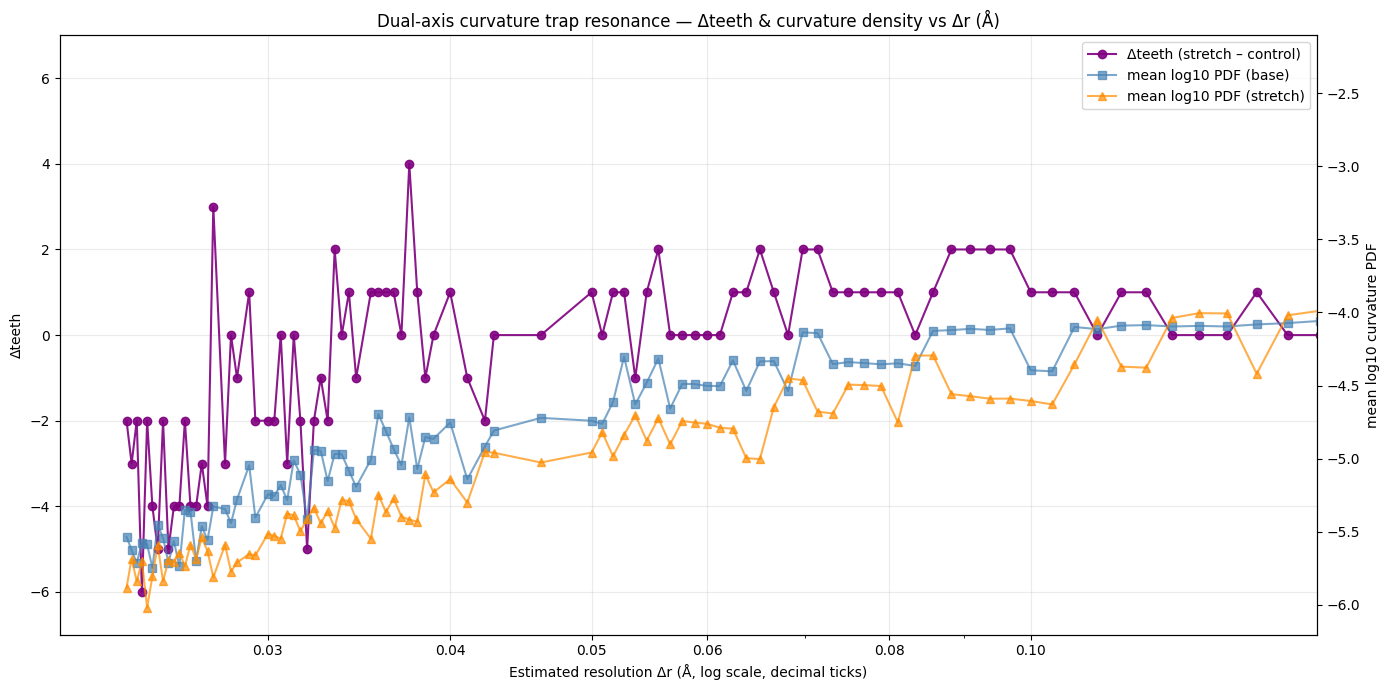

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG: swap these two lines for cluster 5 if desired ---
npz_file   = "6LK1_cluster1_asymmetric_FeS_stretch_ModeB.npz"
teeth_file = "cluster1_teeth_table.csv"

data = np.load(npz_file)
kappa_base = data["kappa_base"]
kappa_mode = data["kappa_mode"]

df = pd.read_csv(teeth_file)

L_eff = 3.0
df["Δr_est_A"] = L_eff / df["bins"]
df = df.sort_values("Δr_est_A")

bins_list = df["bins"].values

def hist_stats(kappa, bins):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    counts = np.maximum(counts, 1e-14)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, counts, edges

mean_log_pdf_base = []
mean_log_pdf_mode = []

for b in bins_list:
    cb, fb, _ = hist_stats(kappa_base, b)
    cm, fm, _ = hist_stats(kappa_mode, b)
    mean_log_pdf_base.append(np.mean(np.log10(fb)))
    mean_log_pdf_mode.append(np.mean(np.log10(fm)))

df["mean_log_pdf_base"] = mean_log_pdf_base
df["mean_log_pdf_mode"] = mean_log_pdf_mode

mask = df["Δteeth"].abs() > 0
xmin_data = df.loc[mask, "Δr_est_A"].min()
xmax_data = df.loc[mask, "Δr_est_A"].max()
x_min_plot = xmin_data * 0.9
x_max_plot = xmax_data * 1.1

fig, ax1 = plt.subplots(figsize=(14,7))

# Left axis: Δteeth
ax1.plot(df["Δr_est_A"], df["Δteeth"], "-o",
         color="purple", alpha=0.9, label="Δteeth (stretch – control)")
ax1.set_xscale("log")
ax1.set_xlim(x_min_plot, x_max_plot)
ax1.set_ylim(-7, 7)
ax1.set_xlabel("Estimated resolution Δr (Å, log scale, decimal ticks)")
ax1.set_ylabel("Δteeth")
ax1.grid(True, alpha=0.25)

# Decimal ticks on log axis
tick_vals = [0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.10]
tick_vals = [v for v in tick_vals if x_min_plot <= v <= x_max_plot]
ax1.set_xticks(tick_vals)
ax1.set_xticklabels([f"{v:.2f}" for v in tick_vals])

# Right axis: mean log curvature density
ax2 = ax1.twinx()
ax2.plot(df["Δr_est_A"], df["mean_log_pdf_base"], "-s",
         color="steelblue", alpha=0.7, label="mean log10 PDF (base)")
ax2.plot(df["Δr_est_A"], df["mean_log_pdf_mode"], "-^",
         color="darkorange", alpha=0.7, label="mean log10 PDF (stretch)")
ax2.set_ylabel("mean log10 curvature PDF")

# Build combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Dual-axis curvature trap resonance — Δteeth & curvature density vs Δr (Å)")
plt.tight_layout()
plt.show()

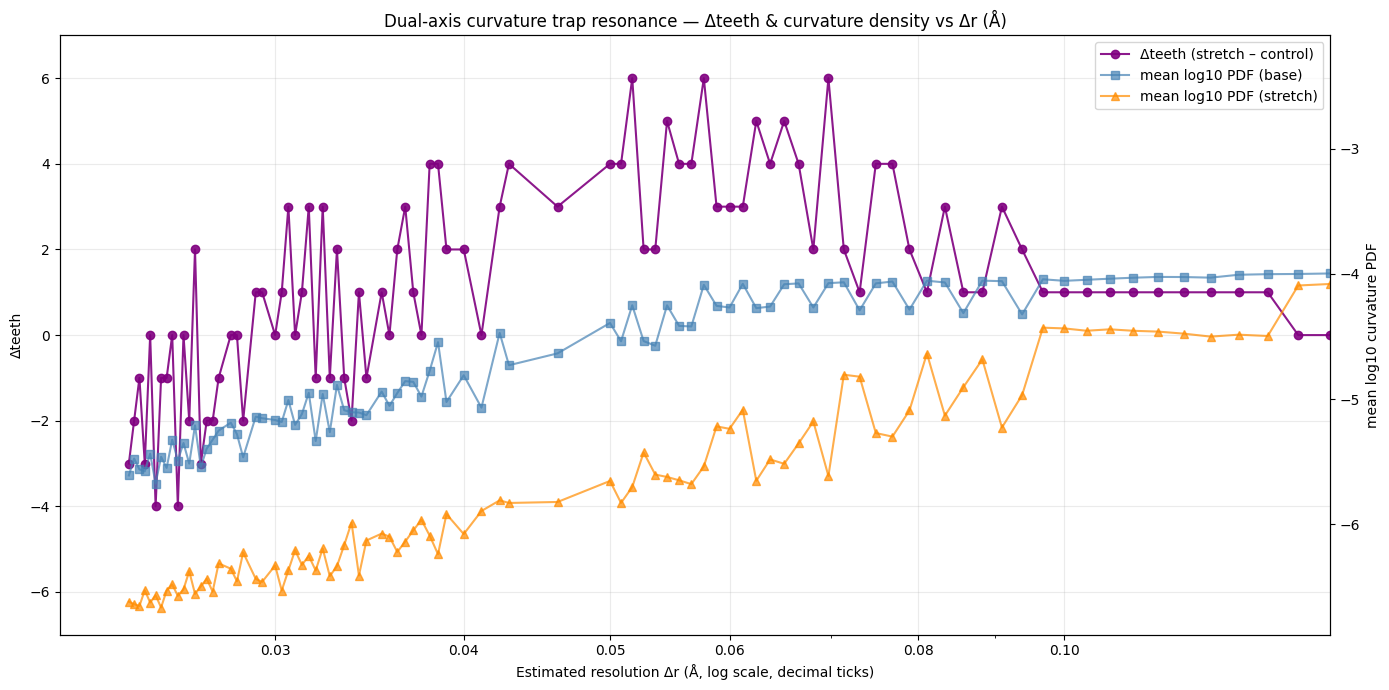

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG: swap these two lines for cluster 5 if desired ---
npz_file   = "6LK1_cluster5_asymmetric_FeS_stretch_ModeB.npz"
teeth_file = "cluster5_teeth_table.csv"

data = np.load(npz_file)
kappa_base = data["kappa_base"]
kappa_mode = data["kappa_mode"]

df = pd.read_csv(teeth_file)

L_eff = 3.0
df["Δr_est_A"] = L_eff / df["bins"]
df = df.sort_values("Δr_est_A")

bins_list = df["bins"].values

def hist_stats(kappa, bins):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    counts = np.maximum(counts, 1e-14)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, counts, edges

mean_log_pdf_base = []
mean_log_pdf_mode = []

for b in bins_list:
    cb, fb, _ = hist_stats(kappa_base, b)
    cm, fm, _ = hist_stats(kappa_mode, b)
    mean_log_pdf_base.append(np.mean(np.log10(fb)))
    mean_log_pdf_mode.append(np.mean(np.log10(fm)))

df["mean_log_pdf_base"] = mean_log_pdf_base
df["mean_log_pdf_mode"] = mean_log_pdf_mode

mask = df["Δteeth"].abs() > 0
xmin_data = df.loc[mask, "Δr_est_A"].min()
xmax_data = df.loc[mask, "Δr_est_A"].max()
x_min_plot = xmin_data * 0.9
x_max_plot = xmax_data * 1.1

fig, ax1 = plt.subplots(figsize=(14,7))

# Left axis: Δteeth
ax1.plot(df["Δr_est_A"], df["Δteeth"], "-o",
         color="purple", alpha=0.9, label="Δteeth (stretch – control)")
ax1.set_xscale("log")
ax1.set_xlim(x_min_plot, x_max_plot)
ax1.set_ylim(-7, 7)
ax1.set_xlabel("Estimated resolution Δr (Å, log scale, decimal ticks)")
ax1.set_ylabel("Δteeth")
ax1.grid(True, alpha=0.25)

# Decimal ticks on log axis
tick_vals = [0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.10]
tick_vals = [v for v in tick_vals if x_min_plot <= v <= x_max_plot]
ax1.set_xticks(tick_vals)
ax1.set_xticklabels([f"{v:.2f}" for v in tick_vals])

# Right axis: mean log curvature density
ax2 = ax1.twinx()
ax2.plot(df["Δr_est_A"], df["mean_log_pdf_base"], "-s",
         color="steelblue", alpha=0.7, label="mean log10 PDF (base)")
ax2.plot(df["Δr_est_A"], df["mean_log_pdf_mode"], "-^",
         color="darkorange", alpha=0.7, label="mean log10 PDF (stretch)")
ax2.set_ylabel("mean log10 curvature PDF")

# Build combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Dual-axis curvature trap resonance — Δteeth & curvature density vs Δr (Å)")
plt.tight_layout()
plt.show()

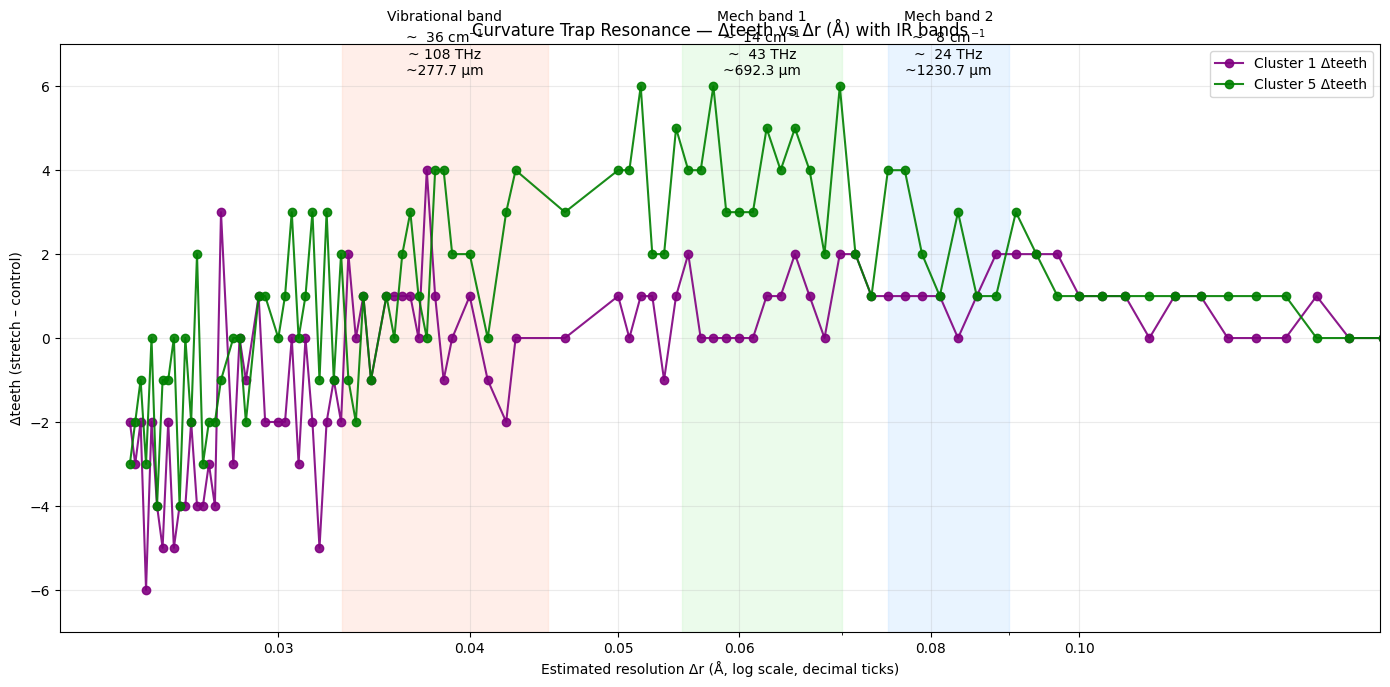

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load tables
df1 = pd.read_csv("cluster1_teeth_table.csv")
df5 = pd.read_csv("cluster5_teeth_table.csv")

L_eff = 3.0
df1["Δr_est_A"] = L_eff / df1["bins"]
df5["Δr_est_A"] = L_eff / df5["bins"]

df1 = df1.sort_values("Δr_est_A")
df5 = df5.sort_values("Δr_est_A")

# Data-driven x-limits (only where Δteeth != 0)
mask1 = df1["Δteeth"].abs() > 0
mask5 = df5["Δteeth"].abs() > 0

xmin_data = min(df1.loc[mask1, "Δr_est_A"].min(),
                df5.loc[mask5, "Δr_est_A"].min())
xmax_data = max(df1.loc[mask1, "Δr_est_A"].max(),
                df5.loc[mask5, "Δr_est_A"].max())

x_min_plot = xmin_data * 0.9
x_max_plot = xmax_data * 1.1

# === Define bands with central Δr and IR labels ===
# (central amplitudes in Å chosen from your resonance zones)
bands = [
    {
        "name": "Vibrational band",
        "Δr_c": 0.038,        # Cluster 1 main gate
        "Δr_rng": (0.033, 0.045),
        "color": "#ffd1c0"
    },
    {
        "name": "Mech band 1",
        "Δr_c": 0.060,        # Cluster 5 lobe 1
        "Δr_rng": (0.055, 0.070),
        "color": "#c8f5c8"
    },
    {
        "name": "Mech band 2",
        "Δr_c": 0.080,        # Cluster 5 lobe 2
        "Δr_rng": (0.075, 0.090),
        "color": "#c0e0ff"
    }
]

# Helper: central Δr → IR labels
def amp_to_ir_labels(Δr_A):
    hbar = 1.054e-34       # J·s
    u = 1.6605e-27         # kg/u
    mFe, mS = 55.85, 32.0
    m_r = (mFe * mS) / (mFe + mS) * u   # reduced mass in kg
    A = Δr_A * 1e-10       # Å → m
    nu = hbar / (2 * m_r * A**2)        # Hz
    nu_THz = nu / 1e12
    c = 3.0e10             # cm/s
    wavenum = nu / (c * 100.0)          # cm^-1
    lamb_um = 1e4 / wavenum            # µm (approx)
    return nu_THz, wavenum, lamb_um

plt.figure(figsize=(14,7))

# Shade and label bands
for b in bands:
    x0, x1 = b["Δr_rng"]
    plt.axvspan(x0, x1, color=b["color"], alpha=0.35)
    xm = np.sqrt(x0 * x1)
    nu_THz, wn, lam = amp_to_ir_labels(b["Δr_c"])
    label = (f"{b['name']}\n"
             f"~{wn:4.0f} cm$^{{-1}}$\n"
             f"~{nu_THz:4.0f} THz\n"
             f"~{lam:3.1f} µm")
    plt.text(xm, 6.2, label, fontsize=10, ha="center", va="bottom")

# Δteeth curves (only)
plt.plot(df1["Δr_est_A"], df1["Δteeth"], "-o",
         color="purple", alpha=0.9, label="Cluster 1 Δteeth")
plt.plot(df5["Δr_est_A"], df5["Δteeth"], "-o",
         color="green", alpha=0.9, label="Cluster 5 Δteeth")

plt.xscale("log")
plt.xlim(x_min_plot, x_max_plot)
plt.ylim(-7,7)

# Decimal ticks on log axis
tick_vals = [0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.10]
tick_vals = [v for v in tick_vals if x_min_plot <= v <= x_max_plot]
plt.xticks(tick_vals, [f"{v:.2f}" for v in tick_vals])

plt.xlabel("Estimated resolution Δr (Å, log scale, decimal ticks)")
plt.ylabel("Δteeth (stretch – control)")
plt.title("Curvature Trap Resonance — Δteeth vs Δr (Å) with IR bands")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

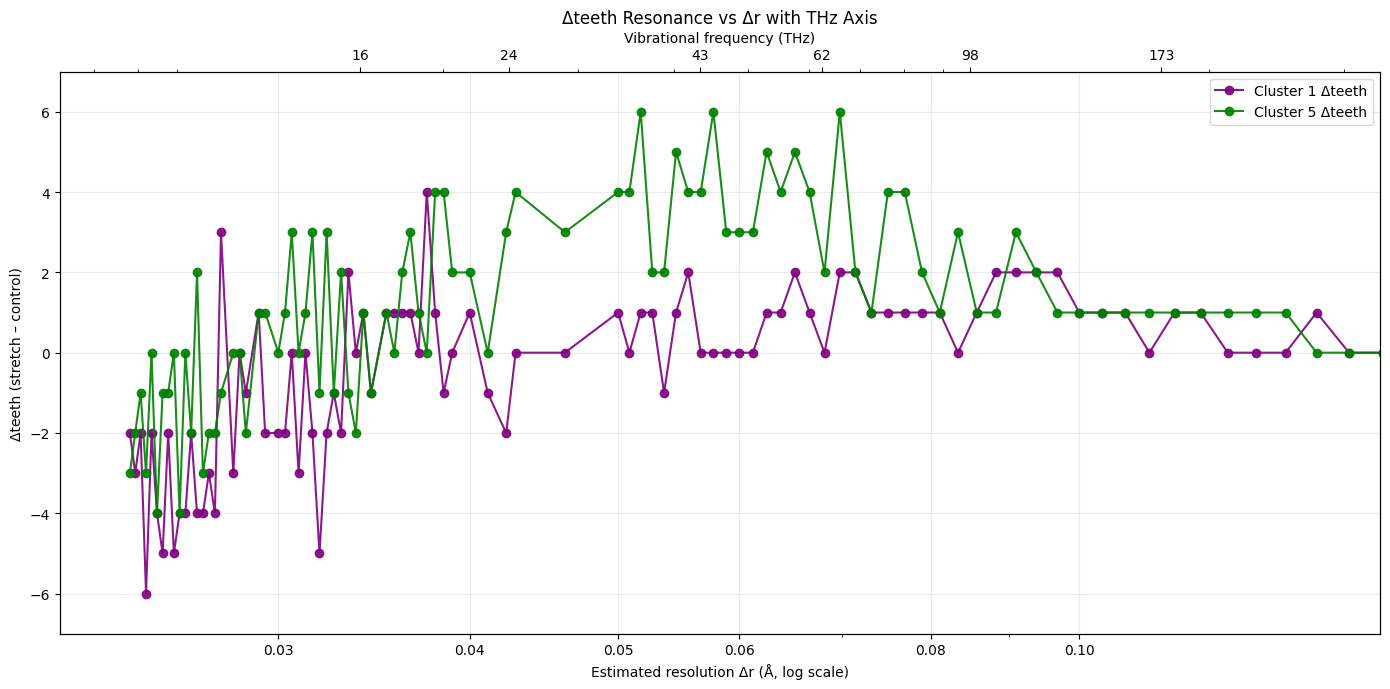

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load CSVs
df1 = pd.read_csv("cluster1_teeth_table.csv")
df5 = pd.read_csv("cluster5_teeth_table.csv")

# Å mapping
L_eff = 3.0
df1["Δr_est_A"] = L_eff / df1["bins"]
df5["Δr_est_A"] = L_eff / df5["bins"]

df1 = df1.sort_values("Δr_est_A")
df5 = df5.sort_values("Δr_est_A")

# THz mapping from Δr
def dr_to_thz(Δr_A):
    hbar = 1.054e-34
    u = 1.6605e-27
    mFe, mS = 55.85, 32.0
    m_r = (mFe*mS)/(mFe+mS) * u   # reduced mass in kg
    A = Δr_A * 1e-10             # convert Å → m
    nu = hbar / (2 * m_r * A**2) # Hz
    return nu / 1e12             # THz

# Filter non-zero Δteeth bins
mask1 = df1["Δteeth"].abs() > 0
mask5 = df5["Δteeth"].abs() > 0

xmin = min(df1.loc[mask1,"Δr_est_A"].min(), df5.loc[mask5,"Δr_est_A"].min())*0.9
xmax = max(df1.loc[mask1,"Δr_est_A"].max(), df5.loc[mask5,"Δr_est_A"].max())*1.1

# Figure
fig, ax1 = plt.subplots(figsize=(14,7))

# Δteeth curves
ax1.plot(df1["Δr_est_A"], df1["Δteeth"], "-o",
         color="purple", alpha=0.9, label="Cluster 1 Δteeth")
ax1.plot(df5["Δr_est_A"], df5["Δteeth"], "-o",
         color="green", alpha=0.9, label="Cluster 5 Δteeth")

ax1.set_xscale("log")
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(-7, 7)

# Decimal ticks for Δr axis
ticks = [0.02,0.03,0.04,0.05,0.06,0.08,0.10]
ticks = [t for t in ticks if xmin <= t <= xmax]
ax1.set_xticks(ticks)
ax1.set_xticklabels([f"{t:.2f}" for t in ticks])

ax1.set_xlabel("Estimated resolution Δr (Å, log scale)")
ax1.set_ylabel("Δteeth (stretch – control)")
ax1.grid(True, alpha=0.25)

# ----- SECOND X-AXIS (THz) -----
def angstrom_to_thz(x):
    return dr_to_thz(x)

def thz_to_angstrom(x):
    # invert the amplitude–frequency relation
    hbar = 1.054e-34
    u = 1.6605e-27
    mFe, mS = 55.85,32.0
    m_r = (mFe*mS)/(mFe+mS)*u
    nu = x*1e12       # THz→Hz
    A = np.sqrt(hbar/(2*m_r*nu))
    return A*1e10     # m→Å

ax2 = ax1.twiny()
ax2.set_xscale("log")
ax2.set_xlim(dr_to_thz(x_max_plot), dr_to_thz(x_min_plot))

# Compute THz tick positions corresponding to Δr ticks
# After setting the x-limits for both axes:
ax2.set_xlim(dr_to_thz(x_max_plot), dr_to_thz(x_min_plot))

# Now recompute THz tick positions matching the Δr-axis ticks:
thz_tick_positions = dr_to_thz(np.array(ticks))
ax2.set_xticks(thz_tick_positions)
ax2.set_xticklabels([f"{v:.0f}" for v in thz_tick_positions])

ax2.set_xlabel("Vibrational frequency (THz)")

# Legend + layout
ax1.legend(loc="upper right")
plt.title("Δteeth Resonance vs Δr with THz Axis")
plt.tight_layout()
plt.show()

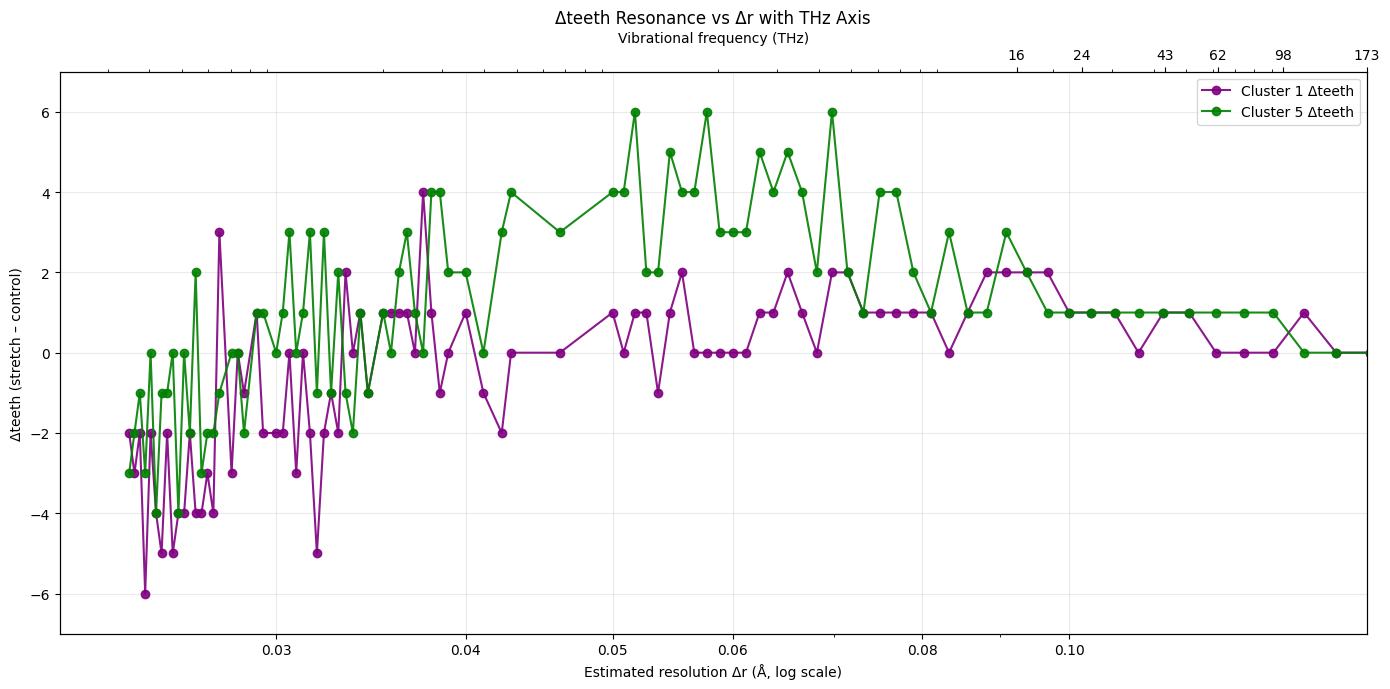

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load CSVs
df1 = pd.read_csv("cluster1_teeth_table.csv")
df5 = pd.read_csv("cluster5_teeth_table.csv")

# Å mapping
L_eff = 3.0
df1["Δr_est_A"] = L_eff / df1["bins"]
df5["Δr_est_A"] = L_eff / df5["bins"]

df1 = df1.sort_values("Δr_est_A")
df5 = df5.sort_values("Δr_est_A")

# THz mapping from Δr
def dr_to_thz(Δr_A):
    hbar = 1.054e-34
    u = 1.6605e-27
    mFe, mS = 55.85, 32.0
    m_r = (mFe*mS)/(mFe+mS) * u   # reduced mass in kg
    A = Δr_A * 1e-10             # convert Å → m
    nu = hbar / (2 * m_r * A**2) # Hz
    return nu / 1e12             # THz

# Filter non-zero Δteeth bins
mask1 = df1["Δteeth"].abs() > 0
mask5 = df5["Δteeth"].abs() > 0

xmin = min(df1.loc[mask1,"Δr_est_A"].min(), df5.loc[mask5,"Δr_est_A"].min())*0.9
xmax = max(df1.loc[mask1,"Δr_est_A"].max(), df5.loc[mask5,"Δr_est_A"].max())*1.1

# Figure
fig, ax1 = plt.subplots(figsize=(14,7))

# Δteeth curves
ax1.plot(df1["Δr_est_A"], df1["Δteeth"], "-o",
         color="purple", alpha=0.9, label="Cluster 1 Δteeth")
ax1.plot(df5["Δr_est_A"], df5["Δteeth"], "-o",
         color="green", alpha=0.9, label="Cluster 5 Δteeth")

ax1.set_xscale("log")
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(-7, 7)

# Decimal ticks for Δr axis
ticks = [0.02,0.03,0.04,0.05,0.06,0.08,0.10]
ticks = [t for t in ticks if xmin <= t <= xmax]
ax1.set_xticks(ticks)
ax1.set_xticklabels([f"{t:.2f}" for t in ticks])

ax1.set_xlabel("Estimated resolution Δr (Å, log scale)")
ax1.set_ylabel("Δteeth (stretch – control)")
ax1.grid(True, alpha=0.25)

# ----- SECOND X-AXIS (THz) -----
def angstrom_to_thz(x):
    return dr_to_thz(x)

def thz_to_angstrom(x):
    # invert the amplitude–frequency relation
    hbar = 1.054e-34
    u = 1.6605e-27
    mFe, mS = 55.85,32.0
    m_r = (mFe*mS)/(mFe+mS)*u
    nu = x*1e12       # THz→Hz
    A = np.sqrt(hbar/(2*m_r*nu))
    return A*1e10     # m→Å

ax2 = ax1.twiny()
ax2.set_xscale("log")
ax2.set_xlim(ax1.get_xlim())

# Compute THz tick positions corresponding to Δr ticks
thz_ticks = angstrom_to_thz(np.array(ticks))
ax2.set_xticks(thz_ticks)
ax2.set_xticklabels([f"{v:.0f}" for v in thz_ticks])

ax2.set_xlabel("Vibrational frequency (THz)")

# Legend + layout
ax1.legend(loc="upper right")
plt.title("Δteeth Resonance vs Δr with THz Axis")
plt.tight_layout()
plt.show()

/tmp/ipython-input-1302141767.py:41: RuntimeWarning: divide by zero encountered in divide
  A = np.sqrt(hbar / (2 * m_r * nu))  # m


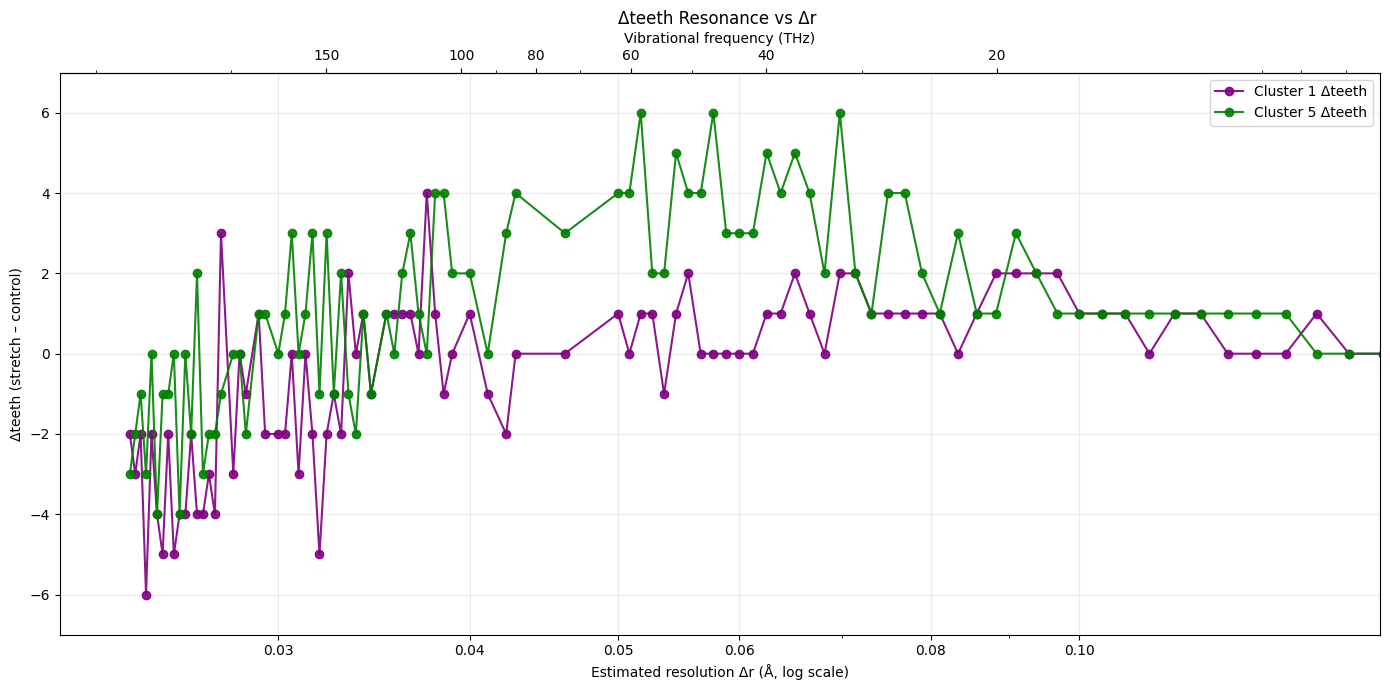

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- load data ----
df1 = pd.read_csv("cluster1_teeth_table.csv")
df5 = pd.read_csv("cluster5_teeth_table.csv")

L_eff = 3.0  # Å span for curvature resolution mapping
df1["Δr_est_A"] = L_eff / df1["bins"]
df5["Δr_est_A"] = L_eff / df5["bins"]

df1 = df1.sort_values("Δr_est_A")
df5 = df5.sort_values("Δr_est_A")

# ---- filter for non-zero Δteeth to get useful x-range ----
mask1 = df1["Δteeth"].abs() > 0
mask5 = df5["Δteeth"].abs() > 0

xmin = min(df1.loc[mask1, "Δr_est_A"].min(),
           df5.loc[mask5, "Δr_est_A"].min()) * 0.9
xmax = max(df1.loc[mask1, "Δr_est_A"].max(),
           df5.loc[mask5, "Δr_est_A"].max()) * 1.1

# ---- amplitude→frequency mapping (Fe–S reduced mass) ----
def dr_to_thz(dr_A):
    hbar = 1.054e-34
    u = 1.6605e-27
    mFe, mS = 55.85, 32.0
    m_r = (mFe * mS) / (mFe + mS) * u   # kg
    A = dr_A * 1e-10        # Å → m
    nu = hbar / (2 * m_r * A**2)  # Hz
    return nu / 1e12        # THz

def thz_to_dr(thz):
    hbar = 1.054e-34
    u = 1.6605e-27
    mFe, mS = 55.85, 32.0
    m_r = (mFe * mS) / (mFe + mS) * u
    nu = thz * 1e12         # THz → Hz
    A = np.sqrt(hbar / (2 * m_r * nu))  # m
    return A * 1e10         # Å

# ---- plot Δteeth vs Δr with secondary THz axis ----
fig, ax1 = plt.subplots(figsize=(14,7))

ax1.plot(df1["Δr_est_A"], df1["Δteeth"],
         "-o", color="purple", alpha=0.9, label="Cluster 1 Δteeth")
ax1.plot(df5["Δr_est_A"], df5["Δteeth"],
         "-o", color="green", alpha=0.9, label="Cluster 5 Δteeth")

ax1.set_xscale("log")
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(-7, 7)

# bottom axis ticks in Å (decimals, not exponent)
dr_ticks = [0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.10]
dr_ticks = [t for t in dr_ticks if xmin <= t <= xmax]
ax1.set_xticks(dr_ticks)
ax1.set_xticklabels([f"{t:.2f}" for t in dr_ticks])

ax1.set_xlabel("Estimated resolution Δr (Å, log scale)")
ax1.set_ylabel("Δteeth (stretch – control)")
ax1.grid(True, alpha=0.25)

# ---- proper secondary THz axis ----
ax2 = ax1.secondary_xaxis('top', functions=(dr_to_thz, thz_to_dr))
# choose THz ticks you want to see (will be mapped back to Δr automatically)
thz_ticks = [20, 40, 60, 80, 100, 150]
ax2.set_xticks(thz_ticks)
ax2.set_xticklabels([f"{v:.0f}" for v in thz_ticks])
ax2.set_xlabel("Vibrational frequency (THz)")

ax1.legend(loc="upper right")
plt.title("Δteeth Resonance vs Δr ")
plt.tight_layout()
plt.show()


=== Processing 4S39.cif ===
Core atoms:
  S  -3.489   1.085   1.489
  Fe  -1.450   0.469   0.592
  S  -0.191  -0.390   2.341
  S   0.056   1.851  -0.354
  S  -1.898  -1.038  -1.092
  Fe   0.104  -0.125  -1.504
  S   1.594  -1.528  -0.520
  S   0.917   0.095  -3.643
  Fe  -0.396  -1.810   0.480
  Fe   1.316   0.335   0.822
  S   3.439   1.054   1.384
SCF not converged.
SCF energy = -7704.17796185291
SCF not converged.
SCF energy = -7710.41676631213
Saved NPZ: 4S39_control_fe4s4_modeB.npz


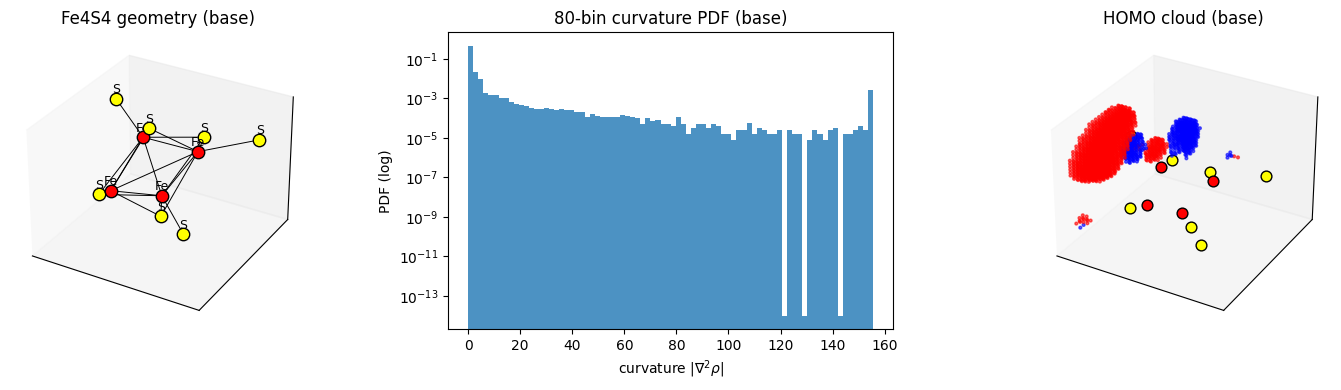

Saved: 4S39_control_fe4s4_base_triptych.png


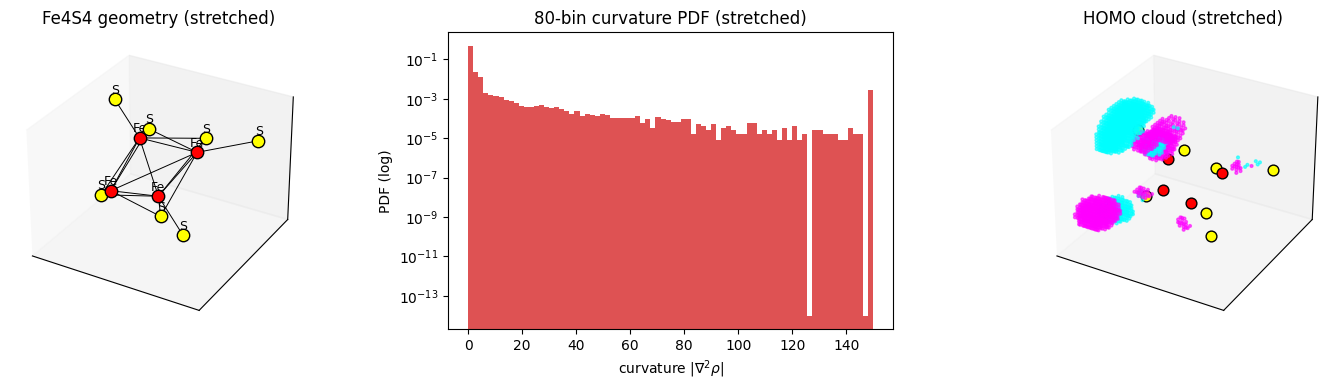

Saved: 4S39_control_fe4s4_stretched_triptych.png


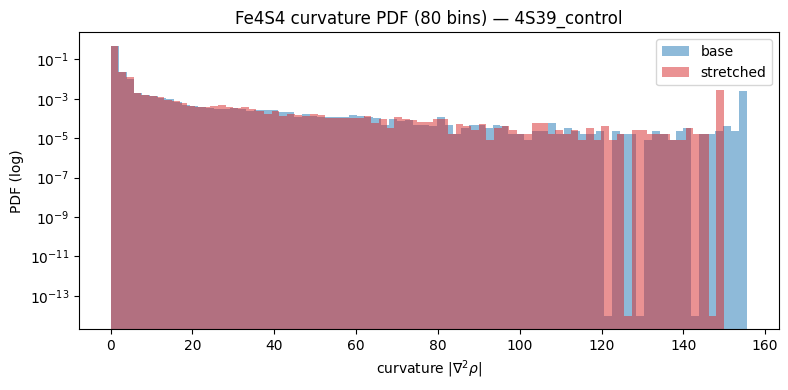

Saved: 4S39_control_fe4s4_ctrl_vs_stretch_comb.png


/tmp/ipython-input-3760206071.py:239: RuntimeWarning: divide by zero encountered in divide
  A = np.sqrt(hbar/(2*m_r*nu))


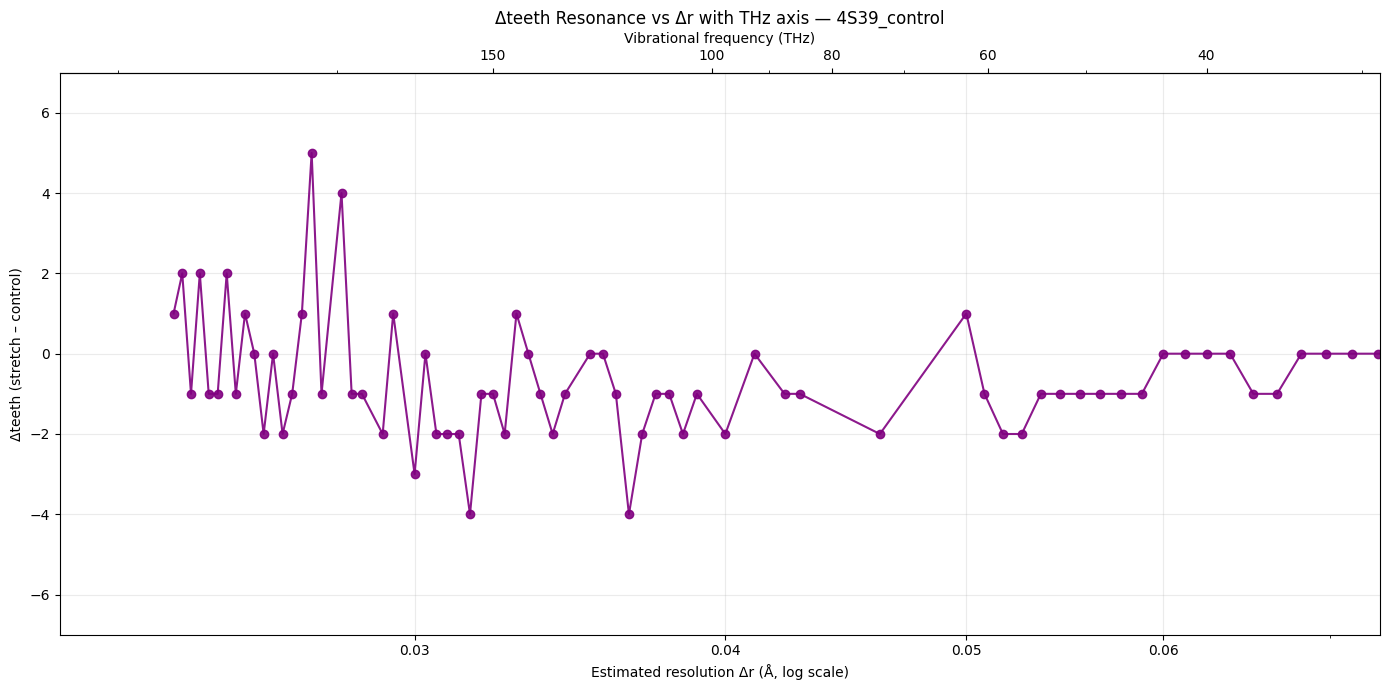

Saved: 4S39_control_fe4s4_resonance_thz.png

=== Processing 4S3E.cif ===
Core atoms:
  S  -3.535   1.084   1.461
  Fe  -1.505   0.465   0.542
  S  -0.278  -0.361   2.320
  S  -0.001   1.871  -0.407
  S  -1.826  -1.153  -1.060
  Fe   0.147  -0.165  -1.520
  S   1.669  -1.490  -0.472
  S   0.964   0.105  -3.629
  Fe  -0.276  -1.878   0.526
  Fe   1.268   0.377   0.837
  S   3.371   1.149   1.402
SCF not converged.
SCF energy = -7710.67988893746
SCF not converged.
SCF energy = -7709.5329096223
Saved NPZ: 4S3E_inhibitor_fe4s4_modeB.npz


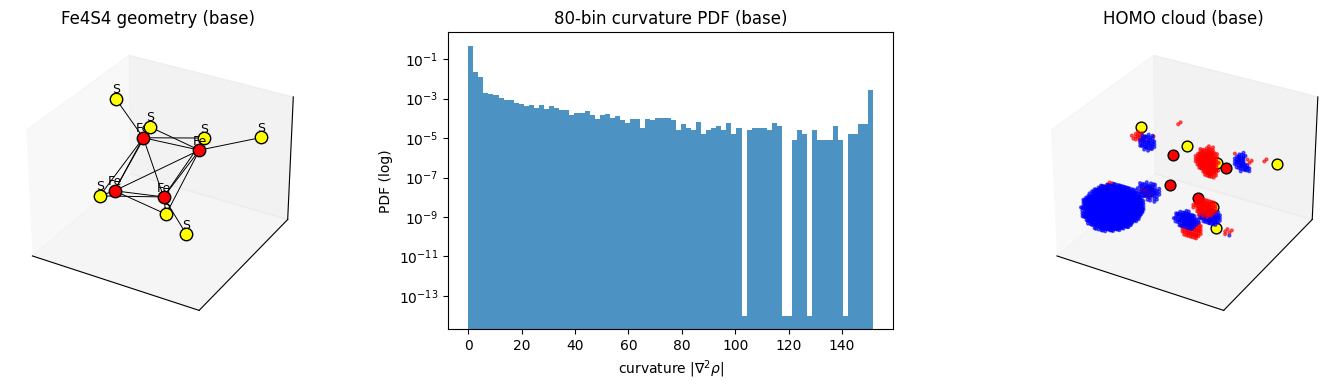

Saved: 4S3E_inhibitor_fe4s4_base_triptych.png


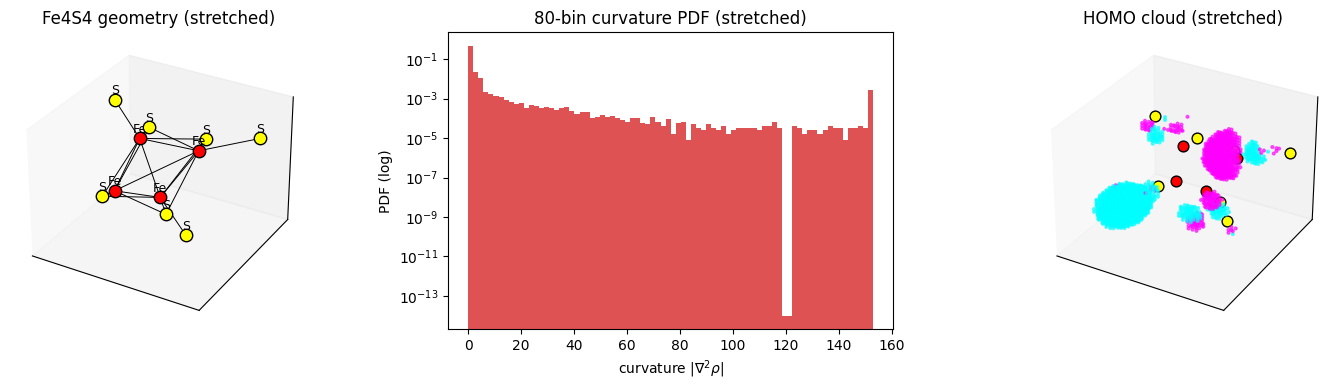

Saved: 4S3E_inhibitor_fe4s4_stretched_triptych.png


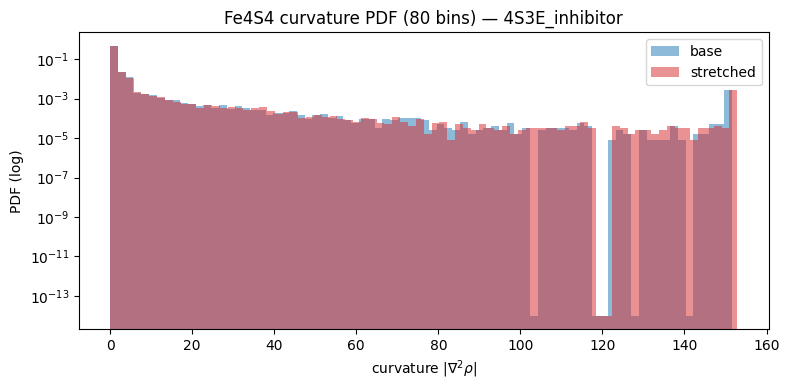

Saved: 4S3E_inhibitor_fe4s4_ctrl_vs_stretch_comb.png


/tmp/ipython-input-3760206071.py:239: RuntimeWarning: divide by zero encountered in divide
  A = np.sqrt(hbar/(2*m_r*nu))


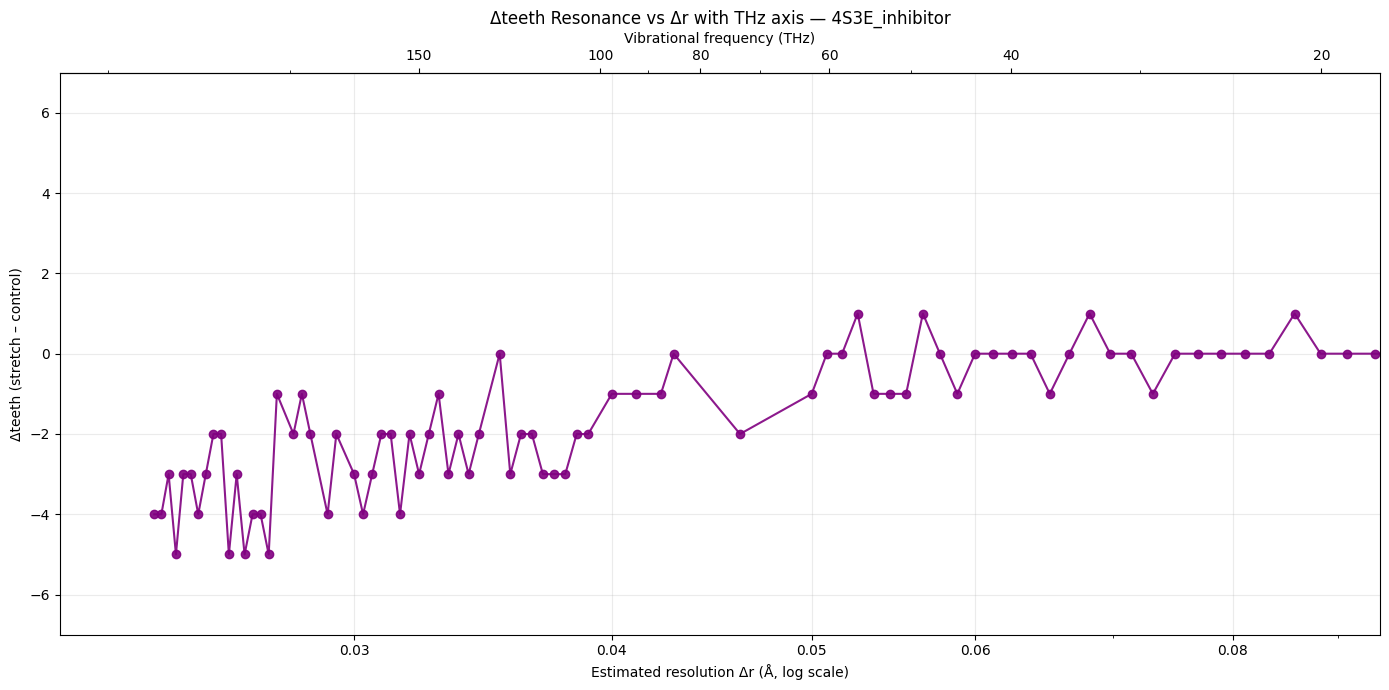

Saved: 4S3E_inhibitor_fe4s4_resonance_thz.png


In [ ]:
# ======================================================
# Fe4S4 pipeline for 4S39.cif and 4S3E.cif
# ======================================================

!pip install -q gemmi pyscf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import gemmi
from pyscf import gto, dft
from pyscf.dft import numint
import os

# ----------------------------------------
# Helpers: CIF → Fe/S atoms → clusters
# ----------------------------------------
def load_fes_from_cif(cif_path):
    doc = gemmi.cif.read_file(cif_path)
    block = doc.sole_block()
    structure = gemmi.make_structure_from_block(block)
    model = structure[0]
    fes_atoms = []
    for chain in model:
        for res in chain:
            for atom in res:
                el = atom.element.name
                if el.upper().startswith("FE") or el.upper() == "S":
                    fes_atoms.append({
                        "element": "Fe" if el.upper().startswith("FE") else "S",
                        "x": atom.pos.x,
                        "y": atom.pos.y,
                        "z": atom.pos.z,
                    })
    fes_coords = np.array([[a["x"], a["y"], a["z"]] for a in fes_atoms])
    fes_elems  = np.array([a["element"] for a in fes_atoms])
    return fes_coords, fes_elems

def cluster_fes(coords, cutoff=3.0):
    N = coords.shape[0]
    adj = [[] for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(coords[i] - coords[j])
            if d < cutoff:
                adj[i].append(j)
                adj[j].append(i)
    visited = [False]*N
    clusters = []
    for i in range(N):
        if not visited[i]:
            stack = [i]
            comp = []
            visited[i] = True
            while stack:
                k = stack.pop()
                comp.append(k)
                for nb in adj[k]:
                    if not visited[nb]:
                        visited[nb] = True
                        stack.append(nb)
            clusters.append(comp)
    return clusters

# ----------------------------------------
# Find Fe4S4 cluster (4 Fe, >=4 S)
# ----------------------------------------
def get_fe4s4_cluster(fes_coords, fes_elems):
    clusters = cluster_fes(fes_coords, cutoff=3.0)
    for comp in clusters:
        elems = fes_elems[comp]
        n_fe = np.sum(elems == "Fe")
        n_s  = np.sum(elems == "S")
        if n_fe == 4 and n_s >= 4:
            return comp
    raise RuntimeError("No obvious Fe4S4 cluster found.")

# ----------------------------------------
# PySCF + curvature + HOMO
# ----------------------------------------
def curvature_pdf_and_mf(symbols, coords,
                         box=4.0, ngrid=40, rho_thresh=1e-3):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid_coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    atom_str = "\n".join(f"{s} {x:.6f} {y:.6f} {z:.6f}"
                         for s,(x,y,z) in zip(symbols, coords))

    mol = gto.Mole()
    mol.atom = atom_str
    mol.basis = "sto-3g"
    mol.charge = 0
    mol.spin = 0
    mol.build()

    mf = dft.RKS(mol)
    mf.xc = "PBE"
    mf.max_cycle = 150
    mf.conv_tol = 1e-5
    mf.kernel()

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid_coords)
    dm = mf.make_rdm1()
    rho_flat = ni.eval_rho(mol, ao, dm)
    rho = rho_flat.reshape((ngrid, ngrid, ngrid))

    dx = xs[1] - xs[0]
    lap = (
        np.gradient(np.gradient(rho, dx, axis=0), dx, axis=0) +
        np.gradient(np.gradient(rho, dx, axis=1), dx, axis=1) +
        np.gradient(np.gradient(rho, dx, axis=2), dx, axis=2)
    )

    mask = rho > rho_thresh
    kappa = np.abs(lap[mask].ravel())
    if kappa.size == 0:
        print("Warning: no points above rho_thresh")
    kappa = np.clip(kappa, 0, np.percentile(kappa, 99.5))
    return kappa, mf, mol

def homo_cloud(mol, mf,
               box=4.0, ngrid=40, keep_percent=97.0,
               max_points=5000):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid_coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid_coords)

    mo_coeff = mf.mo_coeff
    mo_occ   = mf.mo_occ
    occ_idx  = np.where(mo_occ > 1e-6)[0]
    homo_idx = occ_idx[-1]

    mo_vals = ao @ mo_coeff[:, homo_idx]
    mo_vals = np.real(mo_vals)
    prob = mo_vals**2

    thr = np.percentile(prob, keep_percent)
    mask = prob > thr
    coords_cloud = grid_coords[mask]
    psi_cloud    = mo_vals[mask]

    if coords_cloud.shape[0] > max_points:
        idx = np.random.choice(coords_cloud.shape[0], max_points, replace=False)
        coords_cloud = coords_cloud[idx]
        psi_cloud    = psi_cloud[idx]

    return coords_cloud, psi_cloud

# ----------------------------------------
# Mode B: asymmetric Fe–S stretch for Fe4S4
# ----------------------------------------
def modeB_fe4s4(coords, symbols, amp=0.20):
    coords = coords.copy()
    fe_idx = [i for i,s in enumerate(symbols) if s=="Fe"]
    s_idx  = [i for i,s in enumerate(symbols) if s=="S"]

    # connect each Fe to its nearest S
    pairs = []
    for fi in fe_idx:
        r_fe = coords[fi]
        dists = [np.linalg.norm(coords[si]-r_fe) for si in s_idx]
        si = s_idx[int(np.argmin(dists))]
        pairs.append((fi, si))

    def stretch_pair(coords, i_fe, i_s, delta):
        r_fe = coords[i_fe]
        r_s  = coords[i_s]
        v = r_s - r_fe
        d = np.linalg.norm(v)
        if d < 1e-6:
            return coords
        u = v / d
        coords[i_fe] -= 0.5*delta*u
        coords[i_s]  += 0.5*delta*u
        return coords

    if len(pairs) >= 2:
        coords = stretch_pair(coords, pairs[0][0], pairs[0][1], +amp)
        coords = stretch_pair(coords, pairs[1][0], pairs[1][1], -amp)
    return coords

# ----------------------------------------
# Histogram + teeth analysis
# ----------------------------------------
def hist_stats(kappa, bins):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    counts = np.maximum(counts, 1e-14)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, counts, edges

def count_teeth_by_threshold(centers, counts, threshold=1e-9):
    low = counts < threshold
    n_teeth = 0
    widths = []
    binsizes = []
    i = 0
    while i < len(low):
        if low[i]:
            start = i
            while i < len(low) and low[i]:
                i += 1
            end = i-1
            n_teeth += 1
            widths.append(centers[end] - centers[start])
            binsizes.append(end - start + 1)
        else:
            i += 1
    mean_w = np.mean(widths) if widths else 0.0
    return n_teeth, mean_w, widths, binsizes

# ----------------------------------------
# Dual-axis THz mapping (proper)
# ----------------------------------------
def dr_to_thz(dr_A):
    hbar = 1.054e-34
    u = 1.6605e-27
    mFe, mS = 55.85, 32.0
    m_r = (mFe*mS)/(mFe+mS)*u
    A = dr_A*1e-10
    nu = hbar/(2*m_r*A**2)
    return nu/1e12

def thz_to_dr(thz):
    hbar = 1.054e-34
    u = 1.6605e-27
    mFe, mS = 55.85, 32.0
    m_r = (mFe*mS)/(mFe+mS)*u
    nu = thz*1e12
    A = np.sqrt(hbar/(2*m_r*nu))
    return A*1e10

# ----------------------------------------
# Process one CIF
# ----------------------------------------
def process_fe4s4_cif(cif_path, tag):
    print("\n=== Processing", cif_path, "===", flush=True)
    fes_coords, fes_elems = load_fes_from_cif(cif_path)
    comp = get_fe4s4_cluster(fes_coords, fes_elems)
    core_coords = fes_coords[comp]
    core_elems  = fes_elems[comp]

    center = core_coords.mean(axis=0)
    coords_centered = core_coords - center
    symbols = core_elems.copy()

    print("Core atoms:")
    for (s,(x,y,z)) in zip(symbols, coords_centered):
        print(f"  {s} {x:7.3f} {y:7.3f} {z:7.3f}")

    # base
    kappa_base, mf_base, mol_base = curvature_pdf_and_mf(symbols, coords_centered)
    coords_cloud_base, psi_cloud_base = homo_cloud(mol_base, mf_base)
    coords_base = coords_centered.copy()

    # ModeB stretched
    coords_stretched = modeB_fe4s4(coords_centered, symbols, amp=0.20)
    kappa_mode, mf_mode, mol_mode = curvature_pdf_and_mf(symbols, coords_stretched)
    coords_cloud_mode, psi_cloud_mode = homo_cloud(mol_mode, mf_mode)

    # Save NPZ
    npz_name = f"{tag}_fe4s4_modeB.npz"
    np.savez(npz_name,
             symbols=symbols,
             coords_base=coords_base,
             coords_mode=coords_stretched,
             kappa_base=kappa_base,
             kappa_mode=kappa_mode,
             coords_cloud_base=coords_cloud_base,
             psi_cloud_base=psi_cloud_base,
             coords_cloud_mode=coords_cloud_mode,
             psi_cloud_mode=psi_cloud_mode,
             cif_path=cif_path,
             tag=tag)
    print("Saved NPZ:", npz_name)

    # 80-bin comb plots + HOMO triptychs
    centers_b, counts_b, edges_b = hist_stats(kappa_base, bins=80)
    centers_m, counts_m, edges_m = hist_stats(kappa_mode, bins=80)

    # triptych base
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(1,3,1, projection="3d")
    color_atoms = {"Fe":"red", "S":"yellow"}
    for (x,y,z), s in zip(coords_base, symbols):
        ax1.scatter(x,y,z, s=80, color=color_atoms.get(s,"grey"), edgecolors="k")
        ax1.text(x,y,z+0.3,s,ha="center",fontsize=9)
    for i in range(len(coords_base)):
        for j in range(i+1,len(coords_base)):
            d = np.linalg.norm(coords_base[i]-coords_base[j])
            if d < 3.0:
                ax1.plot([coords_base[i,0],coords_base[j,0]],
                         [coords_base[i,1],coords_base[j,1]],
                         [coords_base[i,2],coords_base[j,2]],color="k",linewidth=0.7)
    ax1.set_title("Fe4S4 geometry (base)")
    ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])

    ax2 = fig.add_subplot(1,3,2)
    ax2.bar(centers_b, counts_b, width=(edges_b[1]-edges_b[0]),
            color="tab:blue", alpha=0.8)
    ax2.set_yscale("log")
    ax2.set_xlabel(r"curvature $|\nabla^2\rho|$")
    ax2.set_ylabel("PDF (log)")
    ax2.set_title("80-bin curvature PDF (base)")

    ax3 = fig.add_subplot(1,3,3, projection="3d")
    cols_b = np.where(psi_cloud_base>=0, "blue", "red")
    ax3.scatter(coords_cloud_base[:,0],
                coords_cloud_base[:,1],
                coords_cloud_base[:,2],
                s=4, c=cols_b, alpha=0.6)
    for (x,y,z),s in zip(coords_base, symbols):
        ax3.scatter(x,y,z,s=60,color=color_atoms.get(s,"grey"),edgecolors="k")
    ax3.set_title("HOMO cloud (base)")
    ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
    plt.tight_layout()
    png_trip_base = f"{tag}_fe4s4_base_triptych.png"
    plt.savefig(png_trip_base, dpi=300)
    plt.show()
    print("Saved:", png_trip_base)

    # triptych stretched
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(1,3,1, projection="3d")
    for (x,y,z), s in zip(coords_stretched, symbols):
        ax1.scatter(x,y,z, s=80, color=color_atoms.get(s,"grey"), edgecolors="k")
        ax1.text(x,y,z+0.3,s,ha="center",fontsize=9)
    for i in range(len(coords_stretched)):
        for j in range(i+1,len(coords_stretched)):
            d = np.linalg.norm(coords_stretched[i]-coords_stretched[j])
            if d < 3.0:
                ax1.plot([coords_stretched[i,0],coords_stretched[j,0]],
                         [coords_stretched[i,1],coords_stretched[j,1]],
                         [coords_stretched[i,2],coords_stretched[j,2]],color="k",linewidth=0.7)
    ax1.set_title("Fe4S4 geometry (stretched)")
    ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])

    ax2 = fig.add_subplot(1,3,2)
    ax2.bar(centers_m, counts_m, width=(edges_m[1]-edges_m[0]),
            color="tab:red", alpha=0.8)
    ax2.set_yscale("log")
    ax2.set_xlabel(r"curvature $|\nabla^2\rho|$")
    ax2.set_ylabel("PDF (log)")
    ax2.set_title("80-bin curvature PDF (stretched)")

    ax3 = fig.add_subplot(1,3,3, projection="3d")
    cols_m = np.where(psi_cloud_mode>=0, "cyan", "magenta")
    ax3.scatter(coords_cloud_mode[:,0],
                coords_cloud_mode[:,1],
                coords_cloud_mode[:,2],
                s=4, c=cols_m, alpha=0.6)
    for (x,y,z),s in zip(coords_stretched, symbols):
        ax3.scatter(x,y,z,s=60,color=color_atoms.get(s,"grey"),edgecolors="k")
    ax3.set_title("HOMO cloud (stretched)")
    ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
    plt.tight_layout()
    png_trip_st = f"{tag}_fe4s4_stretched_triptych.png"
    plt.savefig(png_trip_st, dpi=300)
    plt.show()
    print("Saved:", png_trip_st)

    # control vs stretch comb overlay (80 bins)
    fig = plt.figure(figsize=(8,4))
    plt.bar(centers_b, counts_b, width=(edges_b[1]-edges_b[0]),
            color="tab:blue", alpha=0.5, label="base")
    plt.bar(centers_m, counts_m, width=(edges_m[1]-edges_m[0]),
            color="tab:red", alpha=0.5, label="stretched")
    plt.yscale("log")
    plt.xlabel(r"curvature $|\nabla^2\rho|$")
    plt.ylabel("PDF (log)")
    plt.title(f"Fe4S4 curvature PDF (80 bins) — {tag}")
    plt.legend()
    plt.tight_layout()
    png_comb = f"{tag}_fe4s4_ctrl_vs_stretch_comb.png"
    plt.savefig(png_comb, dpi=300)
    plt.show()
    print("Saved:", png_comb)

    # Δteeth vs bins & Δr & THz
    bins_list = [
        1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,
        20,21,22,23,24,25,26,27,28,29,
        30,31,32,33,34,35,36,37,38,39,
        40,41,42,43,44,45,46,47,48,49,
        50,51,52,53,54,55,56,57,58,59,
        60,65,70,71,73,75,77,78,79,80,
        81,82,83,84,85,87,88,89,90,
        91,92,93,94,95,96,97,98,99,100,
        102,103,105,106,107,109,
        110,111,112,113,114,115,116,117,118,119,120,
        121,122,123,124,125
    ]

    rows = []
    for b in bins_list:
        cb, fb, eb = hist_stats(kappa_base, b)
        cm, fm, em = hist_stats(kappa_mode, b)
        n_tb, mw_tb, _, _ = count_teeth_by_threshold(cb, fb)
        n_tm, mw_tm, _, _ = count_teeth_by_threshold(cm, fm)
        rows.append({
            "bins": b,
            "n_teeth_base": n_tb,
            "n_teeth_mode": n_tm,
            "Δteeth": n_tm-n_tb
        })
    df_teeth = pd.DataFrame(rows).sort_values("bins")
    L_eff = 3.0
    df_teeth["Δr_est_A"] = L_eff / df_teeth["bins"]

    # dual-axis THz plot (proper)
    fig, ax1 = plt.subplots(figsize=(14,7))
    ax1.plot(df_teeth["Δr_est_A"], df_teeth["Δteeth"],
             "-o", color="purple", alpha=0.9, label=f"{tag} Δteeth")
    ax1.set_xscale("log")
    mask = df_teeth["Δteeth"].abs()>0
    xmin = df_teeth.loc[mask,"Δr_est_A"].min()*0.9
    xmax = df_teeth.loc[mask,"Δr_est_A"].max()*1.1
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(-7,7)
    dr_ticks = [0.02,0.03,0.04,0.05,0.06,0.08,0.10]
    dr_ticks = [t for t in dr_ticks if xmin<=t<=xmax]
    ax1.set_xticks(dr_ticks)
    ax1.set_xticklabels([f"{t:.2f}" for t in dr_ticks])
    ax1.set_xlabel("Estimated resolution Δr (Å, log scale)")
    ax1.set_ylabel("Δteeth (stretch – control)")
    ax1.grid(True, alpha=0.25)

    ax2 = ax1.secondary_xaxis('top', functions=(dr_to_thz, thz_to_dr))
    thz_ticks = [20,40,60,80,100,150]
    ax2.set_xticks(thz_ticks)
    ax2.set_xticklabels([f"{v:.0f}" for v in thz_ticks])
    ax2.set_xlabel("Vibrational frequency (THz)")

    plt.title(f"Δteeth Resonance vs Δr with THz axis — {tag}")
    plt.tight_layout()
    png_thz = f"{tag}_fe4s4_resonance_thz.png"
    plt.savefig(png_thz, dpi=300)
    plt.show()
    print("Saved:", png_thz)


# ======================================================
# Run for your two CIFs: 4S39 (control) and 4S3E (inhibitor)
# ======================================================

process_fe4s4_cif("4S39.cif", tag="4S39_control")
process_fe4s4_cif("4S3E.cif", tag="4S3E_inhibitor")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


control teeth table:


bins  n_teeth_base  n_teeth_mode  Δteeth  mean_tooth_width_base  \
0     1             0             0       0                    0.0   
1     3             0             0       0                    0.0   
2     5             0             0       0                    0.0   
3     7             0             0       0                    0.0   
4     9             0             0       0                    0.0   

   mean_tooth_width_mode  Δr_est_A  
0                    0.0  3.000000  
1                    0.0  1.000000  
2                    0.0  0.600000  
3                    0.0  0.428571  
4                    0.0  0.333333

inhibitor teeth table:


bins  n_teeth_base  n_teeth_mode  Δteeth  mean_tooth_width_base  \
0     1             0             0       0                    0.0   
1     3             0             0       0                    0.0   
2     5             0             0       0                    0.0   
3     7             0             0       0                    0.0   
4     9             0             0       0                    0.0   

   mean_tooth_width_mode  Δr_est_A  
0                    0.0  3.000000  
1                    0.0  1.000000  
2                    0.0  0.600000  
3                    0.0  0.428571  
4                    0.0  0.333333

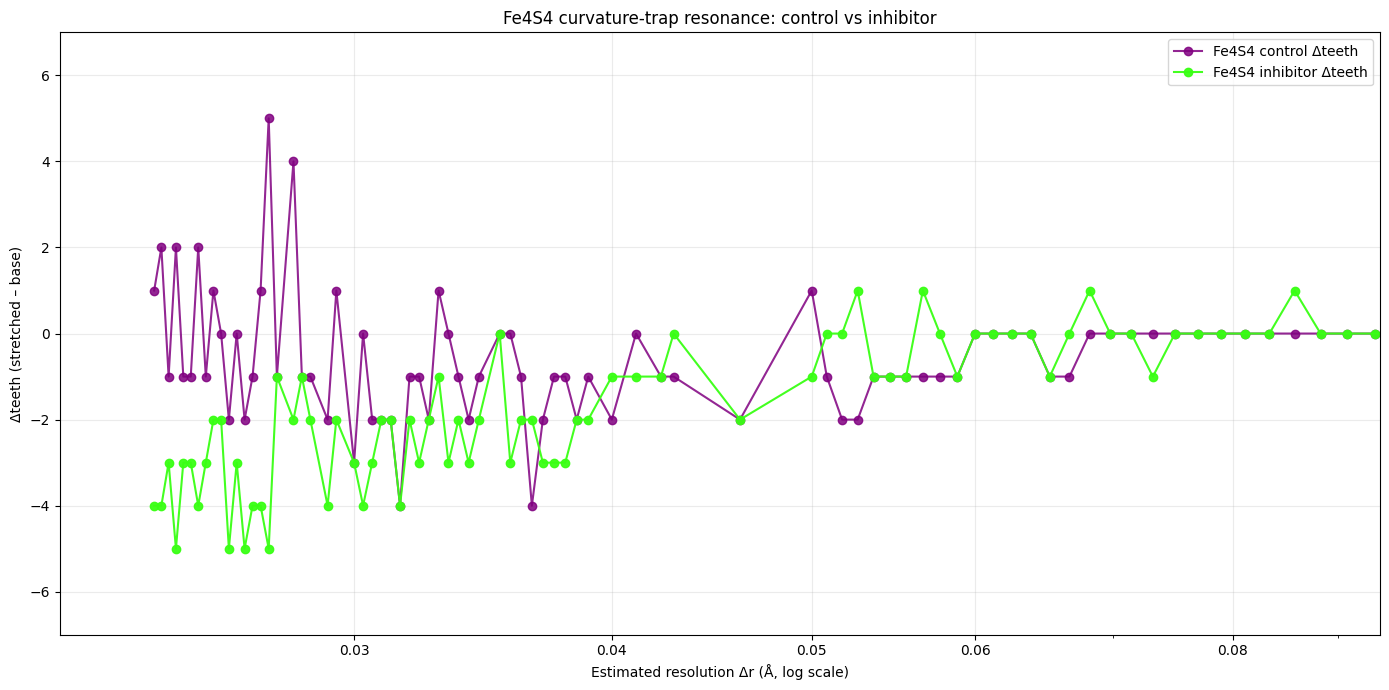

Saved Fe4S4_control_teeth_table.csv and Fe4S4_inhibitor_teeth_table.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIG: filenames ----------
npz_ctrl = "4S39_control_fe4s4_modeB.npz"
npz_inh  = "4S3E_inhibitor_fe4s4_modeB.npz"

# ---------- helpers ----------
def hist_stats(kappa, bins):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    counts = np.maximum(counts, 1e-14)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, counts, edges

def count_teeth_by_threshold(centers, counts, threshold=1e-9):
    low = counts < threshold
    n_teeth = 0
    widths = []
    i = 0
    while i < len(low):
        if low[i]:
            start = i
            while i < len(low) and low[i]:
                i += 1
            end = i - 1
            n_teeth += 1
            widths.append(centers[end] - centers[start])
        else:
            i += 1
    mean_w = np.mean(widths) if widths else 0.0
    return n_teeth, mean_w, widths

# same bin grid as we’ve been using
bins_list = [
    1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,
    20,21,22,23,24,25,26,27,28,29,
    30,31,32,33,34,35,36,37,38,39,
    40,41,42,43,44,45,46,47,48,49,
    50,51,52,53,54,55,56,57,58,59,
    60,65,70,71,73,75,77,78,79,80,
    81,82,83,84,85,87,88,89,90,
    91,92,93,94,95,96,97,98,99,100,
    102,103,105,106,107,109,
    110,111,112,113,114,115,116,117,118,119,120,
    121,122,123,124,125
]

# ---------- build Δteeth table from a single NPZ ----------
def build_teeth_table_from_npz(npz_file, label):
    data = np.load(npz_file)
    kappa_base = data["kappa_base"]
    kappa_mode = data["kappa_mode"]

    rows = []
    for b in bins_list:
        cb, fb, eb = hist_stats(kappa_base, b)
        cm, fm, em = hist_stats(kappa_mode, b)
        n_tb, mw_tb, _ = count_teeth_by_threshold(cb, fb, threshold=1e-9)
        n_tm, mw_tm, _ = count_teeth_by_threshold(cm, fm, threshold=1e-9)
        rows.append({
            "bins": b,
            "n_teeth_base": n_tb,
            "n_teeth_mode": n_tm,
            "Δteeth": n_tm - n_tb,
            "mean_tooth_width_base": mw_tb,
            "mean_tooth_width_mode": mw_tm
        })
    df = pd.DataFrame(rows).sort_values("bins")
    L_eff = 3.0  # Å mapping used before
    df["Δr_est_A"] = L_eff / df["bins"]
    print(f"{label} teeth table:")
    display(df.head())
    return df

df_ctrl = build_teeth_table_from_npz(npz_ctrl, label="control")
df_inh  = build_teeth_table_from_npz(npz_inh,  label="inhibitor")

# ---------- overlay Δteeth vs Δr ----------
mask_c = df_ctrl["Δteeth"].abs() > 0
mask_i = df_inh["Δteeth"].abs() > 0

xmin = min(df_ctrl.loc[mask_c,"Δr_est_A"].min(),
           df_inh.loc[mask_i,"Δr_est_A"].min()) * 0.9
xmax = max(df_ctrl.loc[mask_c,"Δr_est_A"].max(),
           df_inh.loc[mask_i,"Δr_est_A"].max()) * 1.1

plt.figure(figsize=(14,7))

# control: purple
plt.plot(df_ctrl["Δr_est_A"], df_ctrl["Δteeth"],
         "-o", color="purple", alpha=0.85, label="Fe4S4 control Δteeth")

# inhibitor: luminous neon green
plt.plot(df_inh["Δr_est_A"], df_inh["Δteeth"],
         "-o", color="#39FF14", alpha=0.95, label="Fe4S4 inhibitor Δteeth")

plt.xscale("log")
plt.xlim(xmin, xmax)
plt.ylim(-7, 7)

# nice decimal ticks on Δr axis
dr_ticks = [0.02,0.03,0.04,0.05,0.06,0.08,0.10]
dr_ticks = [t for t in dr_ticks if xmin <= t <= xmax]
plt.xticks(dr_ticks, [f"{t:.2f}" for t in dr_ticks])

plt.xlabel("Estimated resolution Δr (Å, log scale)")
plt.ylabel("Δteeth (stretched – base)")
plt.title("Fe4S4 curvature-trap resonance: control vs inhibitor")
plt.grid(True, alpha=0.25)
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig("Fe4S4_control_vs_inhibitor_delta_teeth.png", dpi=300)
plt.show()

# ---------- (optional) save the tables as CSV ----------
df_ctrl.to_csv("Fe4S4_control_teeth_table.csv", index=False)
df_inh.to_csv("Fe4S4_inhibitor_teeth_table.csv", index=False)
print("Saved Fe4S4_control_teeth_table.csv and Fe4S4_inhibitor_teeth_table.csv")

In [ ]:
import numpy as np

# Load base NPZ for 4S39 (tag must match what you used in process_fe4s4_cif)
data_4S39 = np.load("4S39_control_fe4s4_modeB.npz")

symbols_4S39     = data_4S39["symbols"]
coords_base_4S39 = data_4S39["coords_base"]
kappa_base_4S39  = data_4S39["kappa_base"]

In [ ]:
data_4S39 = scan_modes_fe4s4(symbols_4S39, coords_base_4S39, kappa_base_4S39)

NameError: name 'scan_modes_fe4s4' is not defined

In [ ]:
import numpy as np
from pyscf import gto, dft
from pyscf.dft import numint

# ============================================================
# Utility: compute curvature PDF from symbols + coords
# ============================================================
def curvature_pdf_from_coords(symbols, coords,
                              box=3.0, ngrid=32, rho_thresh=1e-3):
    """
    Compute kappa = |∇²ρ| for a molecule defined by symbols + coords.
    Returns: flattened curvature values (kappa), SCF object (mf), mol object
    """

    # Build PySCF mol
    atom_lines = [f"{s} {x:.6f} {y:.6f} {z:.6f}"
                  for s,(x,y,z) in zip(symbols, coords)]
    mol = gto.M(atom=atom_lines, basis='sto-3g',
                spin=0, charge=0)

    # SCF
    mf = dft.RKS(mol)
    mf.xc = 'PBE'
    mf.max_cycle = 120
    mf.conv_tol = 1e-5
    mf.kernel()

    # Grid
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X,Y,Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    # AO + density
    ni = numint.NumInt()
    ao  = ni.eval_ao(mol, grid)
    dm  = mf.make_rdm1()
    rho = ni.eval_rho(mol, ao, dm).reshape((ngrid,ngrid,ngrid))

    # Compute Laplacian ∇²ρ
    dx = xs[1] - xs[0]
    lap = (
        np.gradient(np.gradient(rho, dx, axis=0), dx, axis=0) +
        np.gradient(np.gradient(rho, dx, axis=1), dx, axis=1) +
        np.gradient(np.gradient(rho, dx, axis=2), dx, axis=2)
    )

    mask = rho > rho_thresh
    kappa = np.abs(lap[mask].ravel())

    # Trim outliers (same as Fe₂S₂ pipeline)
    if kappa.size > 0:
        kappa = np.clip(kappa, 0, np.percentile(kappa, 99.5))

    return kappa, mf, mol

In [ ]:
results_4S39 = data_4S39["kappa_mode"]

In [ ]:
table

bins  n_teeth_base  n_teeth_mode  Δteeth  mean_tooth_width_base  \
0       1             0             0       0               0.000000   
1       3             0             0       0               0.000000   
2       5             0             0       0               0.000000   
3       7             0             0       0               0.000000   
4       9             0             0       0               0.000000   
..    ...           ...           ...     ...                    ...   
101   121            13            13       0               0.652064   
102   122            15            12      -3               0.560490   
103   123            14            13      -1               0.714772   
104   124            14            12      -2               0.590839   
105   125            16            13      -3               0.512849   

     mean_tooth_width_mode    Δwidth  trap_change_score  
0                 0.000000  0.000000           0.000000  
1                 0.000000  0.000000           0.000000  
2                 0.000000  0.000000           0.000000  
3                 0.000000  0.000000           0.000000  
4                 0.000000  0.000000           0.000000  
..                     ...       ...                ...  
101               2.648372  1.996308           1.177507  
102               2.845553  2.285063           4.358966  
103               2.735575  2.020803           2.211657  
104               3.079623  2.488783           3.504387  
105               2.691805  2.178957           4.327729  

[106 rows x 8 columns]

In [ ]:
import numpy as np
from pyscf import gto, dft
from pyscf.dft import numint
import pandas as pd

# ---------- curvature from symbols + coords ----------
def curvature_pdf_from_coords(symbols, coords,
                              box=3.0, ngrid=32, rho_thresh=1e-3):
    atom_lines = [f"{s} {x:.6f} {y:.6f} {z:.6f}"
                  for s,(x,y,z) in zip(symbols, coords)]
    mol = gto.M(atom=atom_lines, basis='sto-3g', spin=0, charge=0)

    mf = dft.RKS(mol)
    mf.xc = 'PBE'
    mf.max_cycle = 120
    mf.conv_tol = 1e-5
    mf.kernel()

    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X,Y,Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid)
    dm = mf.make_rdm1()
    rho = ni.eval_rho(mol, ao, dm).reshape((ngrid,ngrid,ngrid))

    dx = xs[1] - xs[0]
    lap = (
        np.gradient(np.gradient(rho, dx, axis=0), dx, axis=0) +
        np.gradient(np.gradient(rho, dx, axis=1), dx, axis=1) +
        np.gradient(np.gradient(rho, dx, axis=2), dx, axis=2)
    )

    mask = rho > rho_thresh
    kappa = np.abs(lap[mask].ravel())
    if kappa.size > 0:
        kappa = np.clip(kappa, 0, np.percentile(kappa, 99.5))
    return kappa, mf, mol

# ---------- helper: teeth count for quick scoring ----------
def quick_teeth_score(kappa_base, kappa_mode, bins_list=[40,60,80,100],
                      threshold=1e-9):
    def hist_stats(kappa, bins):
        counts, edges = np.histogram(kappa, bins=bins, density=True)
        counts = np.maximum(counts, 1e-14)
        centers = 0.5*(edges[:-1] + edges[1:])
        return centers, counts

    def count_teeth(centers, counts):
        low = counts < threshold
        n_teeth = 0
        i = 0
        while i < len(low):
            if low[i]:
                start = i
                while i < len(low) and low[i]:
                    i += 1
                n_teeth += 1
            else:
                i += 1
        return n_teeth

    rows = []
    for b in bins_list:
        cb, fb = hist_stats(kappa_base, b)
        cm, fm = hist_stats(kappa_mode, b)
        ntb = count_teeth(cb, fb)
        ntm = count_teeth(cm, fm)
        rows.append({"bins": b,
                     "teeth_base": ntb,
                     "teeth_mode": ntm,
                     "Δteeth": ntm-ntb})
    df = pd.DataFrame(rows)
    score = df["Δteeth"].abs().max()
    return score, df

# ---------- Fe4S4 mode scanner ----------
def scan_modes_fe4s4(symbols, coords_base, kappa_base,
                     amp_A=0.20, amp_B=0.20, amp_C=0.15):
    coords_base = np.array(coords_base, dtype=float)
    idx_Fe = np.array([i for i,s in enumerate(symbols) if s.upper()=="FE"])
    idx_S  = np.array([i for i,s in enumerate(symbols) if s.upper()=="S"])

    modes = []

    # Mode A: symmetric S breathing (S move radially)
    coordsA = coords_base.copy()
    centerS = coordsA[idx_S].mean(axis=0)
    for si in idx_S:
        v = coordsA[si] - centerS
        coordsA[si] += amp_A * v / (np.linalg.norm(v)+1e-9)
    kA, _, _ = curvature_pdf_from_coords(symbols, coordsA)
    sA, dfA = quick_teeth_score(kappa_base, kA)
    modes.append({"mode":"ModeA_breath", "score":sA, "table":dfA})

    # Mode B: asymmetric Fe–S stretch from first Fe
    coordsB = coords_base.copy()
    if len(idx_Fe) > 0:
        Fe0 = idx_Fe[0]
        for si in idx_S:
            v = coordsB[si] - coordsB[Fe0]
            coordsB[si] += amp_B * v / (np.linalg.norm(v)+1e-9)
    kB, _, _ = curvature_pdf_from_coords(symbols, coordsB)
    sB, dfB = quick_teeth_score(kappa_base, kB)
    modes.append({"mode":"ModeB_asym_FeS_stretch", "score":sB, "table":dfB})

    # Mode C: Fe cube shear (Fe atoms pushed in opposite directions)
    coordsC = coords_base.copy()
    if len(idx_Fe) == 4:
        fe_cent = coordsC[idx_Fe].mean(axis=0)
        for j,f in enumerate(idx_Fe):
            sign = +1 if (j%2)==0 else -1
            coordsC[f] += sign * np.array([amp_C, -amp_C, 0.0])
    kC, _, _ = curvature_pdf_from_coords(symbols, coordsC)
    sC, dfC = quick_teeth_score(kappa_base, kC)
    modes.append({"mode":"ModeC_Fe_shear", "score":sC, "table":dfC})

    # summary DataFrame
    summary = pd.DataFrame({"mode":[m["mode"] for m in modes],
                            "score":[m["score"] for m in modes]})
    print("\n=== Fe4S4 mode scan summary (max |Δteeth| over bins) ===")
    display(summary.sort_values("score", ascending=False))

    return modes

In [ ]:
modes_4S39 = scan_modes_fe4s4(symbols_4S39, coords_base_4S39, kappa_base_4S39)

KeyboardInterrupt: 

In [ ]:
data_4S39 = scan_modes_fe4s4(symbols_4S39, coords_base_4S39, kappa_base_4S39)

KeyboardInterrupt: 

In [ ]:
data_4S3E = scan_modes_fe4s4(symbols_4S3E, coords_base_4S3E, kappa_base_4S3E)

NameError: name 'symbols_4S3E' is not defined

In [ ]:
# ======================================================
# Fe4S4 pipeline for 4S39.cif and 4S3E.cif
# ======================================================

!pip install -q gemmi pyscf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import gemmi
from pyscf import gto, dft
from pyscf.dft import numint
import os

# ----------------------------------------
# Helpers: CIF → Fe/S atoms → clusters
# ----------------------------------------
def load_fes_from_cif(cif_path):
    doc = gemmi.cif.read_file(cif_path)
    block = doc.sole_block()
    structure = gemmi.make_structure_from_block(block)
    model = structure[0]
    fes_atoms = []
    for chain in model:
        for res in chain:
            for atom in res:
                el = atom.element.name
                if el.upper().startswith("FE") or el.upper() == "S":
                    fes_atoms.append({
                        "element": "Fe" if el.upper().startswith("FE") else "S",
                        "x": atom.pos.x,
                        "y": atom.pos.y,
                        "z": atom.pos.z,
                    })
    fes_coords = np.array([[a["x"], a["y"], a["z"]] for a in fes_atoms])
    fes_elems  = np.array([a["element"] for a in fes_atoms])
    return fes_coords, fes_elems

def cluster_fes(coords, cutoff=3.0):
    N = coords.shape[0]
    adj = [[] for _ in range(N)]
    for i in range(N):
        for j in range(i+1, N):
            d = np.linalg.norm(coords[i] - coords[j])
            if d < cutoff:
                adj[i].append(j)
                adj[j].append(i)
    visited = [False]*N
    clusters = []
    for i in range(N):
        if not visited[i]:
            stack = [i]
            comp = []
            visited[i] = True
            while stack:
                k = stack.pop()
                comp.append(k)
                for nb in adj[k]:
                    if not visited[nb]:
                        visited[nb] = True
                        stack.append(nb)
            clusters.append(comp)
    return clusters

# ----------------------------------------
# Find Fe4S4 cluster (4 Fe, >=4 S)
# ----------------------------------------
def get_fe4s4_cluster(fes_coords, fes_elems):
    clusters = cluster_fes(fes_coords, cutoff=3.0)
    for comp in clusters:
        elems = fes_elems[comp]
        n_fe = np.sum(elems == "Fe")
        n_s  = np.sum(elems == "S")
        if n_fe == 4 and n_s >= 4:
            return comp
    raise RuntimeError("No obvious Fe4S4 cluster found.")

# ----------------------------------------
# PySCF + curvature + HOMO
# ----------------------------------------
def curvature_pdf_and_mf(symbols, coords,
                         box=4.0, ngrid=40, rho_thresh=1e-3):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid_coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    atom_str = "\n".join(f"{s} {x:.6f} {y:.6f} {z:.6f}"
                         for s,(x,y,z) in zip(symbols, coords))

    mol = gto.Mole()
    mol.atom = atom_str
    mol.basis = "sto-3g"
    mol.charge = 0
    mol.spin = 0
    mol.build()

    mf = dft.RKS(mol)
    mf.xc = "PBE"
    mf.max_cycle = 150
    mf.conv_tol = 1e-5
    mf.kernel()

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid_coords)
    dm = mf.make_rdm1()
    rho_flat = ni.eval_rho(mol, ao, dm)
    rho = rho_flat.reshape((ngrid, ngrid, ngrid))

    dx = xs[1] - xs[0]
    lap = (
        np.gradient(np.gradient(rho, dx, axis=0), dx, axis=0) +
        np.gradient(np.gradient(rho, dx, axis=1), dx, axis=1) +
        np.gradient(np.gradient(rho, dx, axis=2), dx, axis=2)
    )

    mask = rho > rho_thresh
    kappa = np.abs(lap[mask].ravel())
    if kappa.size == 0:
        print("Warning: no points above rho_thresh")
    kappa = np.clip(kappa, 0, np.percentile(kappa, 99.5))
    return kappa, mf, mol

def homo_cloud(mol, mf,
               box=4.0, ngrid=40, keep_percent=97.0,
               max_points=5000):
    xs = np.linspace(-box, box, ngrid)
    ys = np.linspace(-box, box, ngrid)
    zs = np.linspace(-box, box, ngrid)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    grid_coords = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    ni = numint.NumInt()
    ao = ni.eval_ao(mol, grid_coords)

    mo_coeff = mf.mo_coeff
    mo_occ   = mf.mo_occ
    occ_idx  = np.where(mo_occ > 1e-6)[0]
    homo_idx = occ_idx[-1]

    mo_vals = ao @ mo_coeff[:, homo_idx]
    mo_vals = np.real(mo_vals)
    prob = mo_vals**2

    thr = np.percentile(prob, keep_percent)
    mask = prob > thr
    coords_cloud = grid_coords[mask]
    psi_cloud    = mo_vals[mask]

    if coords_cloud.shape[0] > max_points:
        idx = np.random.choice(coords_cloud.shape[0], max_points, replace=False)
        coords_cloud = coords_cloud[idx]
        psi_cloud    = psi_cloud[idx]

    return coords_cloud, psi_cloud

# ----------------------------------------
# Mode B: asymmetric Fe–S stretch for Fe4S4
# ----------------------------------------
def modeB_fe4s4(coords, symbols, amp=0.20):
    coords = coords.copy()
    fe_idx = [i for i,s in enumerate(symbols) if s=="Fe"]
    s_idx  = [i for i,s in enumerate(symbols) if s=="S"]

    # connect each Fe to its nearest S
    pairs = []
    for fi in fe_idx:
        r_fe = coords[fi]
        dists = [np.linalg.norm(coords[si]-r_fe) for si in s_idx]
        si = s_idx[int(np.argmin(dists))]
        pairs.append((fi, si))

    def stretch_pair(coords, i_fe, i_s, delta):
        r_fe = coords[i_fe]
        r_s  = coords[i_s]
        v = r_s - r_fe
        d = np.linalg.norm(v)
        if d < 1e-6:
            return coords
        u = v / d
        coords[i_fe] -= 0.5*delta*u
        coords[i_s]  += 0.5*delta*u
        return coords

    if len(pairs) >= 2:
        coords = stretch_pair(coords, pairs[0][0], pairs[0][1], +amp)
        coords = stretch_pair(coords, pairs[1][0], pairs[1][1], -amp)
    return coords

# ----------------------------------------
# Histogram + teeth analysis
# ----------------------------------------
def hist_stats(kappa, bins):
    counts, edges = np.histogram(kappa, bins=bins, density=True)
    counts = np.maximum(counts, 1e-14)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, counts, edges

def count_teeth_by_threshold(centers, counts, threshold=1e-9):
    low = counts < threshold
    n_teeth = 0
    widths = []
    binsizes = []
    i = 0
    while i < len(low):
        if low[i]:
            start = i
            while i < len(low) and low[i]:
                i += 1
            end = i-1
            n_teeth += 1
            widths.append(centers[end] - centers[start])
            binsizes.append(end - start + 1)
        else:
            i += 1
    mean_w = np.mean(widths) if widths else 0.0
    return n_teeth, mean_w, widths, binsizes

# ----------------------------------------
# Dual-axis THz mapping (proper)
# ----------------------------------------
def dr_to_thz(dr_A):
    hbar = 1.054e-34
    u = 1.6605e-27
    mFe, mS = 55.85, 32.0
    m_r = (mFe*mS)/(mFe+mS)*u
    A = dr_A*1e-10
    nu = hbar/(2*m_r*A**2)
    return nu/1e12

def thz_to_dr(thz):
    hbar = 1.054e-34
    u = 1.6605e-27
    mFe, mS = 55.85, 32.0
    m_r = (mFe*mS)/(mFe+mS)*u
    nu = thz*1e12
    A = np.sqrt(hbar/(2*m_r*nu))
    return A*1e10

# ----------------------------------------
# Process one CIF
# ----------------------------------------
def process_fe4s4_cif(cif_path, tag):
    print("\n=== Processing", cif_path, "===", flush=True)
    fes_coords, fes_elems = load_fes_from_cif(cif_path)
    comp = get_fe4s4_cluster(fes_coords, fes_elems)
    core_coords = fes_coords[comp]
    core_elems  = fes_elems[comp]

    center = core_coords.mean(axis=0)
    coords_centered = core_coords - center
    symbols = core_elems.copy()

    print("Core atoms:")
    for (s,(x,y,z)) in zip(symbols, coords_centered):
        print(f"  {s} {x:7.3f} {y:7.3f} {z:7.3f}")

    # base
    kappa_base, mf_base, mol_base = curvature_pdf_and_mf(symbols, coords_centered)
    coords_cloud_base, psi_cloud_base = homo_cloud(mol_base, mf_base)
    coords_base = coords_centered.copy()

    # ModeB stretched
    coords_stretched = modeB_fe4s4(coords_centered, symbols, amp=0.20)
    kappa_mode, mf_mode, mol_mode = curvature_pdf_and_mf(symbols, coords_stretched)
    coords_cloud_mode, psi_cloud_mode = homo_cloud(mol_mode, mf_mode)

    # Save NPZ
    npz_name = f"{tag}_fe4s4_modeB.npz"
    np.savez(npz_name,
             symbols=symbols,
             coords_base=coords_base,
             coords_mode=coords_stretched,
             kappa_base=kappa_base,
             kappa_mode=kappa_mode,
             coords_cloud_base=coords_cloud_base,
             psi_cloud_base=psi_cloud_base,
             coords_cloud_mode=coords_cloud_mode,
             psi_cloud_mode=psi_cloud_mode,
             cif_path=cif_path,
             tag=tag)
    print("Saved NPZ:", npz_name)

    # 80-bin comb plots + HOMO triptychs
    centers_b, counts_b, edges_b = hist_stats(kappa_base, bins=80)
    centers_m, counts_m, edges_m = hist_stats(kappa_mode, bins=80)

    # triptych base
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(1,3,1, projection="3d")
    color_atoms = {"Fe":"red", "S":"yellow"}
    for (x,y,z), s in zip(coords_base, symbols):
        ax1.scatter(x,y,z, s=80, color=color_atoms.get(s,"grey"), edgecolors="k")
        ax1.text(x,y,z+0.3,s,ha="center",fontsize=9)
    for i in range(len(coords_base)):
        for j in range(i+1,len(coords_base)):
            d = np.linalg.norm(coords_base[i]-coords_base[j])
            if d < 3.0:
                ax1.plot([coords_base[i,0],coords_base[j,0]],
                         [coords_base[i,1],coords_base[j,1]],
                         [coords_base[i,2],coords_base[j,2]],color="k",linewidth=0.7)
    ax1.set_title("Fe4S4 geometry (base)")
    ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])

    ax2 = fig.add_subplot(1,3,2)
    ax2.bar(centers_b, counts_b, width=(edges_b[1]-edges_b[0]),
            color="tab:blue", alpha=0.8)
    ax2.set_yscale("log")
    ax2.set_xlabel(r"curvature $|\nabla^2\rho|$")
    ax2.set_ylabel("PDF (log)")
    ax2.set_title("80-bin curvature PDF (base)")

    ax3 = fig.add_subplot(1,3,3, projection="3d")
    cols_b = np.where(psi_cloud_base>=0, "blue", "red")
    ax3.scatter(coords_cloud_base[:,0],
                coords_cloud_base[:,1],
                coords_cloud_base[:,2],
                s=4, c=cols_b, alpha=0.6)
    for (x,y,z),s in zip(coords_base, symbols):
        ax3.scatter(x,y,z,s=60,color=color_atoms.get(s,"grey"),edgecolors="k")
    ax3.set_title("HOMO cloud (base)")
    ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
    plt.tight_layout()
    png_trip_base = f"{tag}_fe4s4_base_triptych.png"
    plt.savefig(png_trip_base, dpi=300)
    plt.show()
    print("Saved:", png_trip_base)

    # triptych stretched
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(1,3,1, projection="3d")
    for (x,y,z), s in zip(coords_stretched, symbols):
        ax1.scatter(x,y,z, s=80, color=color_atoms.get(s,"grey"), edgecolors="k")
        ax1.text(x,y,z+0.3,s,ha="center",fontsize=9)
    for i in range(len(coords_stretched)):
        for j in range(i+1,len(coords_stretched)):
            d = np.linalg.norm(coords_stretched[i]-coords_stretched[j])
            if d < 3.0:
                ax1.plot([coords_stretched[i,0],coords_stretched[j,0]],
                         [coords_stretched[i,1],coords_stretched[j,1]],
                         [coords_stretched[i,2],coords_stretched[j,2]],color="k",linewidth=0.7)
    ax1.set_title("Fe4S4 geometry (stretched)")
    ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([])

    ax2 = fig.add_subplot(1,3,2)
    ax2.bar(centers_m, counts_m, width=(edges_m[1]-edges_m[0]),
            color="tab:red", alpha=0.8)
    ax2.set_yscale("log")
    ax2.set_xlabel(r"curvature $|\nabla^2\rho|$")
    ax2.set_ylabel("PDF (log)")
    ax2.set_title("80-bin curvature PDF (stretched)")

    ax3 = fig.add_subplot(1,3,3, projection="3d")
    cols_m = np.where(psi_cloud_mode>=0, "cyan", "magenta")
    ax3.scatter(coords_cloud_mode[:,0],
                coords_cloud_mode[:,1],
                coords_cloud_mode[:,2],
                s=4, c=cols_m, alpha=0.6)
    for (x,y,z),s in zip(coords_stretched, symbols):
        ax3.scatter(x,y,z,s=60,color=color_atoms.get(s,"grey"),edgecolors="k")
    ax3.set_title("HOMO cloud (stretched)")
    ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
    plt.tight_layout()
    png_trip_st = f"{tag}_fe4s4_stretched_triptych.png"
    plt.savefig(png_trip_st, dpi=300)
    plt.show()
    print("Saved:", png_trip_st)

    # control vs stretch comb overlay (80 bins)
    fig = plt.figure(figsize=(8,4))
    plt.bar(centers_b, counts_b, width=(edges_b[1]-edges_b[0]),
            color="tab:blue", alpha=0.5, label="base")
    plt.bar(centers_m, counts_m, width=(edges_m[1]-edges_m[0]),
            color="tab:red", alpha=0.5, label="stretched")
    plt.yscale("log")
    plt.xlabel(r"curvature $|\nabla^2\rho|$")
    plt.ylabel("PDF (log)")
    plt.title(f"Fe4S4 curvature PDF (80 bins) — {tag}")
    plt.legend()
    plt.tight_layout()
    png_comb = f"{tag}_fe4s4_ctrl_vs_stretch_comb.png"
    plt.savefig(png_comb, dpi=300)
    plt.show()
    print("Saved:", png_comb)

    # Δteeth vs bins & Δr & THz
    bins_list = [
        1,3,5,7,9,10,11,12,13,14,15,16,17,18,19,
        20,21,22,23,24,25,26,27,28,29,
        30,31,32,33,34,35,36,37,38,39,
        40,41,42,43,44,45,46,47,48,49,
        50,51,52,53,54,55,56,57,58,59,
        60,65,70,71,73,75,77,78,79,80,
        81,82,83,84,85,87,88,89,90,
        91,92,93,94,95,96,97,98,99,100,
        102,103,105,106,107,109,
        110,111,112,113,114,115,116,117,118,119,120,
        121,122,123,124,125
    ]

    rows = []
    for b in bins_list:
        cb, fb, eb = hist_stats(kappa_base, b)
        cm, fm, em = hist_stats(kappa_mode, b)
        n_tb, mw_tb, _, _ = count_teeth_by_threshold(cb, fb)
        n_tm, mw_tm, _, _ = count_teeth_by_threshold(cm, fm)
        rows.append({
            "bins": b,
            "n_teeth_base": n_tb,
            "n_teeth_mode": n_tm,
            "Δteeth": n_tm-n_tb
        })
    df_teeth = pd.DataFrame(rows).sort_values("bins")
    L_eff = 3.0
    df_teeth["Δr_est_A"] = L_eff / df_teeth["bins"]

    # dual-axis THz plot (proper)
    fig, ax1 = plt.subplots(figsize=(14,7))
    ax1.plot(df_teeth["Δr_est_A"], df_teeth["Δteeth"],
             "-o", color="purple", alpha=0.9, label=f"{tag} Δteeth")
    ax1.set_xscale("log")
    mask = df_teeth["Δteeth"].abs()>0
    xmin = df_teeth.loc[mask,"Δr_est_A"].min()*0.9
    xmax = df_teeth.loc[mask,"Δr_est_A"].max()*1.1
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(-7,7)
    dr_ticks = [0.02,0.03,0.04,0.05,0.06,0.08,0.10]
    dr_ticks = [t for t in dr_ticks if xmin<=t<=xmax]
    ax1.set_xticks(dr_ticks)
    ax1.set_xticklabels([f"{t:.2f}" for t in dr_ticks])
    ax1.set_xlabel("Estimated resolution Δr (Å, log scale)")
    ax1.set_ylabel("Δteeth (stretch – control)")
    ax1.grid(True, alpha=0.25)

    ax2 = ax1.secondary_xaxis('top', functions=(dr_to_thz, thz_to_dr))
    thz_ticks = [20,40,60,80,100,150]
    ax2.set_xticks(thz_ticks)
    ax2.set_xticklabels([f"{v:.0f}" for v in thz_ticks])
    ax2.set_xlabel("Vibrational frequency (THz)")

    plt.title(f"Δteeth Resonance vs Δr with THz axis — {tag}")
    plt.tight_layout()
    png_thz = f"{tag}_fe4s4_resonance_thz.png"
    plt.savefig(png_thz, dpi=300)
    plt.show()
    print("Saved:", png_thz)

# List of (tag, cif_path) pairs you want to process
targets = [
    ("4S38_MEcPP",    "4S38.cif"),
    ("4S39_HMBPP",    "4S39.cif"),
    ("4S3A_stageA",   "4S3A.cif"),
    ("4S3B_stageB",   "4S3B.cif"),
    ("4S3C_stageC",   "4S3C.cif"),
    ("4S3E_inhib7",   "4S3E.cif"),
    # add ("4S3F_stageF", "4S3F.cif") later if needed
]

for tag, cif in targets:
    process_fe4s4_cif(cif, tag=tag)

In [ ]:
import os

# Choose a project folder under /content
project_root = "/content/gqr_fe4s4_ispG"
os.makedirs(project_root, exist_ok=True)

# This is the filename you want your big pipeline stored as:
code_filename = "fe4s4_ispG_pipeline.py"

# Paste your full pipeline code (Fe4S4 CIF→NPZ etc) into this string:
BIG_CODE = r'''
# >>> PASTE YOUR FULL FE4S4/IspG PIPELINE CODE HERE <<<

# For example:
# import numpy as np
# import gemmi
# from pyscf import gto, dft
# ...
# def process_fe4s4_cif(...):
#     ...
# if __name__ == "__main__":
#     ...
'''

# Write the code into the project folder
code_path = os.path.join(project_root, code_filename)
with open(code_path, "w", encoding="utf-8") as f:
    f.write(BIG_CODE.strip() + "\n")

print("Saved pipeline code to:", code_path)

# Optionally change working directory INTO the project folder
%cd $project_root
print("Current working dir:", os.getcwd())